In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [14]:
def model_input(state_size, reward_size=3):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None, reward_size], name='rewards')
    rewards_ex = tf.placeholder(tf.float32, [None], name='rewards_ex')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, rewards_ex, dones, rates

In [15]:
def Act(states, rewards, action_size, hidden_size, reward_size=3, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=reward_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, rewards])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [16]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [20]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, rewards_ex, dones, rates):
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    A = tf.one_hot(indices=actions, depth=action_size, dtype=states.dtype)
    next_states_, Q = Env(actions=A, states=states, hidden_size=hidden_size, action_size=action_size,
                          state_size=state_size)
    eloss = tf.reduce_mean(tf.square(next_states_-next_states), axis=0) # MSE
    ################################################
    Qlogits = tf.reshape(Q, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qlogits,
                                                                    labels=rates)) # real rate
    ################################################ a = act(s, r)
    nextA = Act(states=next_states, rewards=rewards, hidden_size=hidden_size, action_size=action_size,
                state_size=state_size)
    nextS, nextQ = Env(actions=nextA, states=next_states, hidden_size=hidden_size, action_size=action_size,
                       state_size=state_size, reuse=True)
    nextS_, nextQ_ = Env(actions=nextA, states=next_states_, hidden_size=hidden_size, action_size=action_size,
                         state_size=state_size, reuse=True)
    eloss += tf.reduce_mean(tf.square(nextS-nextS_), axis=0) # MSE
    nextQ = tf.reshape(nextQ, shape=[-1]) * dones
    nextQ_ = tf.reshape(nextQ_, shape=[-1]) * dones
    eloss += tf.reduce_mean(tf.square(nextQ-nextQ_), axis=0) # MSE
    ################################################ Adverserial learning: max prob
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qlogits,
                                                                    labels=tf.zeros_like(rates))) # min rate/pain
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQ,
                                                                    labels=tf.ones_like(rates))) # max rate/gain
    ################################################## Qlearning: max value
    targetQ = rewards_ex + (gamma * nextQ)
    eloss += tf.reduce_mean(tf.square(Q-targetQ), axis=0) # MSE: realQ
    eloss += tf.reduce_mean(tf.square(Q-rewards_ex), axis=0) # MSE: minQ
    #aloss += tf.reduce_mean(tf.square(Q-targetQ), axis=0) # MSE: maxQ=targetQ no
    aloss += -tf.reduce_mean(targetQ) # max
    return actions_logits, eloss, aloss

In [21]:
def model_reward(state_size, action_size, hidden_size, gamma,
                 state, action, next_state, reward, done):
    ################################################ s', r = env(s, a)
    ################################################ a = act(s, r_in, r_ex, Q)
    ################################################ s', Q = env_(s, a)
    #################################################### r_in = sum(square(s'-s'_))
    A = tf.one_hot(indices=action, depth=action_size, dtype=state.dtype)
    next_state_, Q = Env(actions=A, states=state, hidden_size=hidden_size, action_size=action_size,
                   state_size=state_size)
    r_in = tf.reduce_sum(tf.square(next_state_-next_state), axis=1) # SSE
    rQ = tf.nn.sigmoid(Q)
    R = tf.concat(values=[reward, r_in, rQ], axis=0)
    #######################################################
    nextA = Act(states=next_state, rewards=R, hidden_size=hidden_size, action_size=action_size, 
                state_size=state_size)
    nextA_ = Act(states=next_state_, rewards=R, hidden_size=hidden_size, action_size=action_size, 
                 state_size=state_size, reuse=True)
    nnextS, nextQ = Env(actions=nextA, states=next_state, hidden_size=hidden_size, action_size=action_size,
                        state_size=state_size, reuse=True)
    nnextS_, nextQ_ = Env(actions=nextA_, states=next_state_, hidden_size=hidden_size, action_size=action_size,
                          state_size=state_size, reuse=True)
    ################################################
    nextQ = tf.reshape(nextQ, shape=[-1]) * done
    #targetQ = rewards_ex + (gamma * nextQ)
    r_ex = Q - (gamma*nextQ)
    return R, r_ex

In [22]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [24]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.rewards_ex, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, # model input
            rewards=self.rewards, rewards_ex=self.rewards_ex, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, 
                                           e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [25]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [26]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [27]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [28]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

TypeError: Act() got an unexpected keyword argument 'state_size'

In [33]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [34]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(111111111111111):
        aloss_batch, eloss_batch = [], []
        total_reward = 0
        rate = -1
        state = env.reset()

        # Online Training batches: on-policy learning
        for num_step in range(111111111):
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break
        ################## End Online-training
            
        # Offline Training batches: off-policy learning
        for idx in range(memory_size// batch_size):
            batch = memory.buffer
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates >= np.max(rates)]
            actions = actions[rates >= np.max(rates)]
            next_states = next_states[rates >= np.max(rates)]
            rewards = rewards[rates >= np.max(rates)]
            dones = dones[rates >= np.max(rates)]
            rates = rates[rates >= np.max(rates)]
            if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                break
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
        ################## End offline-training
                

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # The task is episodic, and in order to solve the environment, 
        # your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 R:10.0000 rate:0.0200 aloss:0.6885 eloss:6.8153 aloss2:0.6782 exploreP:0.9990
Episode:1 meanR:11.0000 R:12.0000 rate:0.0240 aloss:0.6846 eloss:6.6278 aloss2:0.6797 exploreP:0.9978
Episode:2 meanR:25.3333 R:54.0000 rate:0.1080 aloss:0.6864 eloss:6.1957 aloss2:0.6691 exploreP:0.9925
Episode:3 meanR:34.0000 R:60.0000 rate:0.1200 aloss:0.6841 eloss:5.5247 aloss2:0.6601 exploreP:0.9866
Episode:4 meanR:32.0000 R:24.0000 rate:0.0480 aloss:0.6864 eloss:5.4677 aloss2:0.6572 exploreP:0.9843
Episode:5 meanR:29.5000 R:17.0000 rate:0.0340 aloss:0.6836 eloss:5.3710 aloss2:0.6490 exploreP:0.9826
Episode:6 meanR:28.2857 R:21.0000 rate:0.0420 aloss:0.6834 eloss:5.3305 aloss2:0.6440 exploreP:0.9806
Episode:7 meanR:27.7500 R:24.0000 rate:0.0480 aloss:0.6870 eloss:5.4129 aloss2:0.6471 exploreP:0.9783
Episode:8 meanR:25.7778 R:10.0000 rate:0.0200 aloss:0.6825 eloss:5.3638 aloss2:0.6487 exploreP:0.9773
Episode:9 meanR:24.1000 R:9.0000 rate:0.0180 aloss:0.6840 eloss:5.4916 aloss2:0.64

Episode:80 meanR:23.8025 R:14.0000 rate:0.0280 aloss:0.6831 eloss:3.7367 aloss2:0.6009 exploreP:0.8264
Episode:81 meanR:24.0976 R:48.0000 rate:0.0960 aloss:0.6869 eloss:3.7889 aloss2:0.6217 exploreP:0.8225
Episode:82 meanR:23.9880 R:15.0000 rate:0.0300 aloss:0.6872 eloss:3.7865 aloss2:0.6305 exploreP:0.8213
Episode:83 meanR:23.9167 R:18.0000 rate:0.0360 aloss:0.7763 eloss:4.2108 aloss2:0.6238 exploreP:0.8198
Episode:84 meanR:24.0000 R:31.0000 rate:0.0620 aloss:0.6891 eloss:3.6695 aloss2:0.6191 exploreP:0.8173
Episode:85 meanR:24.0698 R:30.0000 rate:0.0600 aloss:0.6937 eloss:3.8084 aloss2:0.6359 exploreP:0.8149
Episode:86 meanR:24.0460 R:22.0000 rate:0.0440 aloss:0.6816 eloss:3.7438 aloss2:0.6427 exploreP:0.8131
Episode:87 meanR:24.2841 R:45.0000 rate:0.0900 aloss:0.6957 eloss:3.7061 aloss2:0.6381 exploreP:0.8095
Episode:88 meanR:24.2584 R:22.0000 rate:0.0440 aloss:0.7017 eloss:3.6049 aloss2:0.6339 exploreP:0.8078
Episode:89 meanR:24.1889 R:18.0000 rate:0.0360 aloss:0.7121 eloss:3.5213 

Episode:159 meanR:29.4400 R:38.0000 rate:0.0760 aloss:0.7031 eloss:2.7606 aloss2:0.7372 exploreP:0.6498
Episode:160 meanR:29.2100 R:16.0000 rate:0.0320 aloss:0.7126 eloss:2.8183 aloss2:0.7358 exploreP:0.6487
Episode:161 meanR:29.1300 R:21.0000 rate:0.0420 aloss:0.7326 eloss:2.7963 aloss2:0.7367 exploreP:0.6474
Episode:162 meanR:28.9500 R:16.0000 rate:0.0320 aloss:0.7545 eloss:2.8188 aloss2:0.7307 exploreP:0.6464
Episode:163 meanR:28.8100 R:14.0000 rate:0.0280 aloss:0.7481 eloss:2.7648 aloss2:0.7329 exploreP:0.6455
Episode:164 meanR:28.8800 R:24.0000 rate:0.0480 aloss:0.7339 eloss:2.8050 aloss2:0.7419 exploreP:0.6440
Episode:165 meanR:28.7300 R:13.0000 rate:0.0260 aloss:0.7202 eloss:2.7179 aloss2:0.7471 exploreP:0.6431
Episode:166 meanR:28.9100 R:42.0000 rate:0.0840 aloss:0.6992 eloss:2.7323 aloss2:0.7432 exploreP:0.6405
Episode:167 meanR:29.0400 R:28.0000 rate:0.0560 aloss:0.7115 eloss:2.8046 aloss2:0.7427 exploreP:0.6387
Episode:168 meanR:29.1500 R:28.0000 rate:0.0560 aloss:0.7005 elo

Episode:238 meanR:25.2600 R:10.0000 rate:0.0200 aloss:0.7413 eloss:2.5617 aloss2:0.8024 exploreP:0.5420
Episode:239 meanR:25.2200 R:14.0000 rate:0.0280 aloss:0.8580 eloss:2.7882 aloss2:0.7806 exploreP:0.5413
Episode:240 meanR:25.0800 R:11.0000 rate:0.0220 aloss:0.7279 eloss:2.5259 aloss2:0.8096 exploreP:0.5407
Episode:241 meanR:24.9300 R:40.0000 rate:0.0800 aloss:0.7347 eloss:2.5554 aloss2:0.8012 exploreP:0.5386
Episode:242 meanR:24.5100 R:9.0000 rate:0.0180 aloss:0.7539 eloss:2.5338 aloss2:0.7995 exploreP:0.5381
Episode:243 meanR:24.3200 R:13.0000 rate:0.0260 aloss:0.7378 eloss:2.5214 aloss2:0.8059 exploreP:0.5374
Episode:244 meanR:23.7500 R:16.0000 rate:0.0320 aloss:0.7387 eloss:2.5478 aloss2:0.8024 exploreP:0.5366
Episode:245 meanR:23.7100 R:16.0000 rate:0.0320 aloss:0.7625 eloss:2.5377 aloss2:0.8112 exploreP:0.5357
Episode:246 meanR:23.6000 R:14.0000 rate:0.0280 aloss:0.7668 eloss:2.6152 aloss2:0.7870 exploreP:0.5350
Episode:247 meanR:23.3600 R:13.0000 rate:0.0260 aloss:0.7333 elos

Episode:317 meanR:29.2500 R:75.0000 rate:0.1500 aloss:0.6976 eloss:5.5666 aloss2:0.7371 exploreP:0.4240
Episode:318 meanR:29.7900 R:65.0000 rate:0.1300 aloss:0.6893 eloss:5.4235 aloss2:0.7591 exploreP:0.4213
Episode:319 meanR:29.9700 R:35.0000 rate:0.0700 aloss:0.6849 eloss:5.1367 aloss2:0.8136 exploreP:0.4199
Episode:320 meanR:30.6800 R:86.0000 rate:0.1720 aloss:0.6952 eloss:4.8231 aloss2:0.8748 exploreP:0.4164
Episode:321 meanR:31.2000 R:70.0000 rate:0.1400 aloss:0.6835 eloss:4.5342 aloss2:0.9560 exploreP:0.4136
Episode:322 meanR:31.7000 R:68.0000 rate:0.1360 aloss:0.6822 eloss:4.1414 aloss2:1.0384 exploreP:0.4108
Episode:323 meanR:31.8300 R:49.0000 rate:0.0980 aloss:0.6804 eloss:3.9905 aloss2:1.1371 exploreP:0.4089
Episode:324 meanR:32.4300 R:83.0000 rate:0.1660 aloss:0.6833 eloss:3.6917 aloss2:1.1479 exploreP:0.4056
Episode:325 meanR:32.9500 R:66.0000 rate:0.1320 aloss:0.6892 eloss:3.4470 aloss2:1.2093 exploreP:0.4030
Episode:326 meanR:34.3300 R:158.0000 rate:0.3160 aloss:0.6855 el

Episode:396 meanR:61.5100 R:68.0000 rate:0.1360 aloss:0.6673 eloss:2.7989 aloss2:0.8194 exploreP:0.2649
Episode:397 meanR:62.2600 R:108.0000 rate:0.2160 aloss:0.6841 eloss:2.7738 aloss2:0.8237 exploreP:0.2622
Episode:398 meanR:62.3300 R:34.0000 rate:0.0680 aloss:0.6888 eloss:2.7175 aloss2:0.8229 exploreP:0.2613
Episode:399 meanR:62.7300 R:67.0000 rate:0.1340 aloss:0.6823 eloss:2.7459 aloss2:0.8304 exploreP:0.2596
Episode:400 meanR:62.3400 R:64.0000 rate:0.1280 aloss:0.6827 eloss:2.7275 aloss2:0.8331 exploreP:0.2580
Episode:401 meanR:62.7300 R:113.0000 rate:0.2260 aloss:0.6747 eloss:2.6629 aloss2:0.8379 exploreP:0.2553
Episode:402 meanR:63.4000 R:142.0000 rate:0.2840 aloss:0.6771 eloss:2.6101 aloss2:0.8438 exploreP:0.2518
Episode:403 meanR:63.4200 R:94.0000 rate:0.1880 aloss:0.6763 eloss:2.5521 aloss2:0.8487 exploreP:0.2495
Episode:404 meanR:63.8200 R:144.0000 rate:0.2880 aloss:0.6759 eloss:2.5379 aloss2:0.8563 exploreP:0.2461
Episode:405 meanR:63.9500 R:75.0000 rate:0.1500 aloss:0.6860

Episode:475 meanR:67.6800 R:14.0000 rate:0.0280 aloss:0.7072 eloss:2.3694 aloss2:1.6749 exploreP:0.1648
Episode:476 meanR:67.3600 R:24.0000 rate:0.0480 aloss:0.7097 eloss:2.2756 aloss2:1.7806 exploreP:0.1644
Episode:477 meanR:66.7300 R:16.0000 rate:0.0320 aloss:0.7208 eloss:2.2222 aloss2:1.8590 exploreP:0.1642
Episode:478 meanR:66.7500 R:70.0000 rate:0.1400 aloss:0.7164 eloss:2.2742 aloss2:1.7657 exploreP:0.1631
Episode:479 meanR:66.2600 R:15.0000 rate:0.0300 aloss:0.7136 eloss:2.2641 aloss2:1.8225 exploreP:0.1629
Episode:480 meanR:65.2400 R:15.0000 rate:0.0300 aloss:0.7044 eloss:2.2566 aloss2:1.9368 exploreP:0.1626
Episode:481 meanR:64.5500 R:18.0000 rate:0.0360 aloss:0.7191 eloss:2.2594 aloss2:1.8746 exploreP:0.1624
Episode:482 meanR:64.1000 R:16.0000 rate:0.0320 aloss:0.7193 eloss:2.1974 aloss2:1.8447 exploreP:0.1621
Episode:483 meanR:63.6200 R:19.0000 rate:0.0380 aloss:0.7085 eloss:2.4749 aloss2:1.9085 exploreP:0.1618
Episode:484 meanR:62.3300 R:23.0000 rate:0.0460 aloss:0.7149 elo

Episode:554 meanR:77.0700 R:106.0000 rate:0.2120 aloss:0.6634 eloss:3.2514 aloss2:1.0974 exploreP:0.0938
Episode:555 meanR:77.6800 R:103.0000 rate:0.2060 aloss:0.6854 eloss:6.8044 aloss2:0.5285 exploreP:0.0929
Episode:556 meanR:82.2200 R:500.0000 rate:1.0000 aloss:0.6765 eloss:6.7623 aloss2:0.5884 exploreP:0.0889
Episode:557 meanR:83.5900 R:162.0000 rate:0.3240 aloss:0.7067 eloss:3.6159 aloss2:1.0935 exploreP:0.0876
Episode:558 meanR:83.8400 R:95.0000 rate:0.1900 aloss:0.7036 eloss:2.9318 aloss2:1.3048 exploreP:0.0869
Episode:559 meanR:83.7400 R:93.0000 rate:0.1860 aloss:0.7050 eloss:2.6447 aloss2:1.4308 exploreP:0.0861
Episode:560 meanR:83.9300 R:86.0000 rate:0.1720 aloss:0.6956 eloss:2.4720 aloss2:1.4839 exploreP:0.0855
Episode:561 meanR:82.8800 R:74.0000 rate:0.1480 aloss:0.6988 eloss:2.3960 aloss2:1.5586 exploreP:0.0849
Episode:562 meanR:81.2000 R:86.0000 rate:0.1720 aloss:0.6914 eloss:2.3868 aloss2:1.5618 exploreP:0.0843
Episode:563 meanR:80.9700 R:102.0000 rate:0.2040 aloss:0.688

Episode:633 meanR:112.2900 R:32.0000 rate:0.0640 aloss:0.7012 eloss:2.8273 aloss2:1.2801 exploreP:0.0463
Episode:634 meanR:111.4400 R:48.0000 rate:0.0960 aloss:0.7331 eloss:2.7993 aloss2:1.2931 exploreP:0.0462
Episode:635 meanR:110.3900 R:33.0000 rate:0.0660 aloss:0.7565 eloss:2.7557 aloss2:1.2885 exploreP:0.0460
Episode:636 meanR:109.2600 R:36.0000 rate:0.0720 aloss:0.7156 eloss:2.9108 aloss2:1.2864 exploreP:0.0459
Episode:637 meanR:107.8700 R:37.0000 rate:0.0740 aloss:0.7098 eloss:2.6905 aloss2:1.3288 exploreP:0.0458
Episode:638 meanR:106.9200 R:51.0000 rate:0.1020 aloss:0.7063 eloss:2.8392 aloss2:1.3352 exploreP:0.0456
Episode:639 meanR:104.2500 R:52.0000 rate:0.1040 aloss:0.7152 eloss:2.6094 aloss2:1.3472 exploreP:0.0454
Episode:640 meanR:103.4000 R:50.0000 rate:0.1000 aloss:0.7122 eloss:2.8616 aloss2:1.3103 exploreP:0.0452
Episode:641 meanR:102.6300 R:43.0000 rate:0.0860 aloss:0.7024 eloss:2.8964 aloss2:1.3044 exploreP:0.0451
Episode:642 meanR:101.3500 R:80.0000 rate:0.1600 aloss:

Episode:712 meanR:99.7000 R:153.0000 rate:0.3060 aloss:1.0833 eloss:3.0861 aloss2:1.3983 exploreP:0.0261
Episode:713 meanR:102.0500 R:303.0000 rate:0.6060 aloss:1.0022 eloss:3.1038 aloss2:1.4049 exploreP:0.0256
Episode:714 meanR:104.0300 R:253.0000 rate:0.5060 aloss:1.0194 eloss:3.1158 aloss2:1.4049 exploreP:0.0252
Episode:715 meanR:104.7400 R:117.0000 rate:0.2340 aloss:1.0616 eloss:3.0362 aloss2:1.4071 exploreP:0.0250
Episode:716 meanR:105.5900 R:128.0000 rate:0.2560 aloss:0.9960 eloss:2.9933 aloss2:1.3951 exploreP:0.0248
Episode:717 meanR:107.0200 R:216.0000 rate:0.4320 aloss:0.9791 eloss:3.0116 aloss2:1.4131 exploreP:0.0245
Episode:718 meanR:107.6400 R:143.0000 rate:0.2860 aloss:1.0413 eloss:3.0264 aloss2:1.4005 exploreP:0.0243
Episode:719 meanR:108.5100 R:188.0000 rate:0.3760 aloss:1.0311 eloss:2.9628 aloss2:1.4197 exploreP:0.0240
Episode:720 meanR:109.6500 R:298.0000 rate:0.5960 aloss:0.9727 eloss:2.9708 aloss2:1.4338 exploreP:0.0236
Episode:721 meanR:110.3000 R:166.0000 rate:0.33

Episode:790 meanR:195.7100 R:256.0000 rate:0.5120 aloss:0.7289 eloss:2.7815 aloss2:1.5496 exploreP:0.0132
Episode:791 meanR:196.8200 R:180.0000 rate:0.3600 aloss:0.7467 eloss:2.7076 aloss2:1.5651 exploreP:0.0132
Episode:792 meanR:196.8800 R:282.0000 rate:0.5640 aloss:0.6991 eloss:2.7592 aloss2:1.5648 exploreP:0.0131
Episode:793 meanR:197.4600 R:239.0000 rate:0.4780 aloss:0.7062 eloss:2.7230 aloss2:1.5743 exploreP:0.0130
Episode:794 meanR:197.0300 R:182.0000 rate:0.3640 aloss:0.7106 eloss:2.7233 aloss2:1.5681 exploreP:0.0130
Episode:795 meanR:198.0100 R:164.0000 rate:0.3280 aloss:0.6914 eloss:2.7489 aloss2:1.5584 exploreP:0.0129
Episode:796 meanR:198.2900 R:112.0000 rate:0.2240 aloss:0.6686 eloss:2.7458 aloss2:1.5536 exploreP:0.0129
Episode:797 meanR:196.1400 R:200.0000 rate:0.4000 aloss:0.6966 eloss:2.7624 aloss2:1.5665 exploreP:0.0128
Episode:798 meanR:196.3300 R:127.0000 rate:0.2540 aloss:0.7101 eloss:2.7362 aloss2:1.5691 exploreP:0.0128
Episode:799 meanR:196.0100 R:197.0000 rate:0.3

Episode:868 meanR:185.7800 R:250.0000 rate:0.5000 aloss:0.7511 eloss:2.7864 aloss2:1.5114 exploreP:0.0108
Episode:869 meanR:186.1200 R:284.0000 rate:0.5680 aloss:0.7551 eloss:2.7935 aloss2:1.5163 exploreP:0.0108
Episode:870 meanR:185.9800 R:183.0000 rate:0.3660 aloss:0.6805 eloss:2.7847 aloss2:1.5186 exploreP:0.0108
Episode:871 meanR:186.8300 R:179.0000 rate:0.3580 aloss:0.6825 eloss:2.7896 aloss2:1.5200 exploreP:0.0107
Episode:872 meanR:186.8800 R:147.0000 rate:0.2940 aloss:0.7990 eloss:2.7614 aloss2:1.4996 exploreP:0.0107
Episode:873 meanR:186.4000 R:116.0000 rate:0.2320 aloss:0.7353 eloss:2.8059 aloss2:1.5210 exploreP:0.0107
Episode:874 meanR:185.8200 R:158.0000 rate:0.3160 aloss:0.7296 eloss:2.7908 aloss2:1.5261 exploreP:0.0107
Episode:875 meanR:184.7300 R:134.0000 rate:0.2680 aloss:0.6793 eloss:2.8179 aloss2:1.5123 exploreP:0.0107
Episode:876 meanR:184.9200 R:218.0000 rate:0.4360 aloss:0.7320 eloss:2.7599 aloss2:1.5155 exploreP:0.0107
Episode:877 meanR:183.2800 R:121.0000 rate:0.2

Episode:946 meanR:215.2500 R:348.0000 rate:0.6960 aloss:0.5513 eloss:2.8896 aloss2:1.3925 exploreP:0.0101
Episode:947 meanR:214.4600 R:91.0000 rate:0.1820 aloss:0.5428 eloss:2.8857 aloss2:1.3893 exploreP:0.0101
Episode:948 meanR:216.0800 R:310.0000 rate:0.6200 aloss:0.5441 eloss:2.8909 aloss2:1.3885 exploreP:0.0101
Episode:949 meanR:218.9700 R:406.0000 rate:0.8120 aloss:0.5725 eloss:2.8946 aloss2:1.3876 exploreP:0.0101
Episode:950 meanR:216.5300 R:98.0000 rate:0.1960 aloss:0.6183 eloss:2.8668 aloss2:1.3750 exploreP:0.0101
Episode:951 meanR:215.7800 R:206.0000 rate:0.4120 aloss:0.5787 eloss:2.8932 aloss2:1.3845 exploreP:0.0101
Episode:952 meanR:215.1100 R:187.0000 rate:0.3740 aloss:0.5213 eloss:2.8974 aloss2:1.3761 exploreP:0.0101
Episode:953 meanR:215.9200 R:209.0000 rate:0.4180 aloss:0.5608 eloss:2.8832 aloss2:1.3846 exploreP:0.0101
Episode:954 meanR:215.0200 R:198.0000 rate:0.3960 aloss:0.5781 eloss:2.8721 aloss2:1.3837 exploreP:0.0101
Episode:955 meanR:215.0600 R:135.0000 rate:0.270

Episode:1024 meanR:215.2900 R:111.0000 rate:0.2220 aloss:0.4521 eloss:2.9660 aloss2:1.2330 exploreP:0.0100
Episode:1025 meanR:214.5100 R:107.0000 rate:0.2140 aloss:0.4164 eloss:2.9389 aloss2:1.2335 exploreP:0.0100
Episode:1026 meanR:215.1600 R:301.0000 rate:0.6020 aloss:0.4511 eloss:2.9619 aloss2:1.2349 exploreP:0.0100
Episode:1027 meanR:214.4300 R:149.0000 rate:0.2980 aloss:0.3884 eloss:2.9854 aloss2:1.2260 exploreP:0.0100
Episode:1028 meanR:214.4300 R:181.0000 rate:0.3620 aloss:0.4086 eloss:2.9743 aloss2:1.2211 exploreP:0.0100
Episode:1029 meanR:214.0400 R:98.0000 rate:0.1960 aloss:0.4428 eloss:3.0053 aloss2:1.2285 exploreP:0.0100
Episode:1030 meanR:211.9800 R:207.0000 rate:0.4140 aloss:0.4223 eloss:2.9671 aloss2:1.2241 exploreP:0.0100
Episode:1031 meanR:211.3800 R:123.0000 rate:0.2460 aloss:0.4444 eloss:3.0328 aloss2:1.2320 exploreP:0.0100
Episode:1032 meanR:213.4400 R:409.0000 rate:0.8180 aloss:0.3991 eloss:2.9436 aloss2:1.2164 exploreP:0.0100
Episode:1033 meanR:212.1600 R:108.0000

Episode:1101 meanR:189.2300 R:154.0000 rate:0.3080 aloss:0.3321 eloss:2.9776 aloss2:1.1170 exploreP:0.0100
Episode:1102 meanR:189.4800 R:137.0000 rate:0.2740 aloss:0.3273 eloss:2.9987 aloss2:1.1201 exploreP:0.0100
Episode:1103 meanR:188.0100 R:131.0000 rate:0.2620 aloss:0.3094 eloss:2.9997 aloss2:1.1208 exploreP:0.0100
Episode:1104 meanR:187.0400 R:100.0000 rate:0.2000 aloss:0.2821 eloss:2.9732 aloss2:1.1237 exploreP:0.0100
Episode:1105 meanR:187.7900 R:224.0000 rate:0.4480 aloss:0.3135 eloss:3.0043 aloss2:1.1254 exploreP:0.0100
Episode:1106 meanR:187.5300 R:219.0000 rate:0.4380 aloss:0.2852 eloss:2.9844 aloss2:1.1293 exploreP:0.0100
Episode:1107 meanR:186.1800 R:121.0000 rate:0.2420 aloss:0.3080 eloss:3.0382 aloss2:1.1256 exploreP:0.0100
Episode:1108 meanR:184.8400 R:172.0000 rate:0.3440 aloss:0.2975 eloss:2.9862 aloss2:1.1205 exploreP:0.0100
Episode:1109 meanR:184.7300 R:140.0000 rate:0.2800 aloss:0.2869 eloss:2.9942 aloss2:1.1191 exploreP:0.0100
Episode:1110 meanR:185.7900 R:220.000

Episode:1178 meanR:170.1000 R:160.0000 rate:0.3200 aloss:0.3071 eloss:2.9807 aloss2:1.1049 exploreP:0.0100
Episode:1179 meanR:167.4000 R:93.0000 rate:0.1860 aloss:0.2594 eloss:2.9842 aloss2:1.1072 exploreP:0.0100
Episode:1180 meanR:167.0000 R:204.0000 rate:0.4080 aloss:0.2515 eloss:2.9944 aloss2:1.1033 exploreP:0.0100
Episode:1181 meanR:167.1300 R:242.0000 rate:0.4840 aloss:0.2687 eloss:2.9840 aloss2:1.1019 exploreP:0.0100
Episode:1182 meanR:167.6200 R:229.0000 rate:0.4580 aloss:0.2717 eloss:2.9985 aloss2:1.1017 exploreP:0.0100
Episode:1183 meanR:168.1200 R:207.0000 rate:0.4140 aloss:0.2647 eloss:2.9925 aloss2:1.0983 exploreP:0.0100
Episode:1184 meanR:168.1400 R:105.0000 rate:0.2100 aloss:0.2826 eloss:2.9977 aloss2:1.0961 exploreP:0.0100
Episode:1185 meanR:168.3000 R:131.0000 rate:0.2620 aloss:0.2489 eloss:2.9834 aloss2:1.0922 exploreP:0.0100
Episode:1186 meanR:167.6800 R:129.0000 rate:0.2580 aloss:0.2451 eloss:2.9754 aloss2:1.0955 exploreP:0.0100
Episode:1187 meanR:168.9400 R:252.0000

Episode:1255 meanR:176.9500 R:219.0000 rate:0.4380 aloss:0.2309 eloss:2.9983 aloss2:1.1058 exploreP:0.0100
Episode:1256 meanR:178.2500 R:314.0000 rate:0.6280 aloss:0.2467 eloss:3.0051 aloss2:1.1018 exploreP:0.0100
Episode:1257 meanR:178.1300 R:137.0000 rate:0.2740 aloss:0.2280 eloss:2.9840 aloss2:1.1042 exploreP:0.0100
Episode:1258 meanR:177.7500 R:135.0000 rate:0.2700 aloss:0.2474 eloss:2.9891 aloss2:1.1053 exploreP:0.0100
Episode:1259 meanR:177.5500 R:127.0000 rate:0.2540 aloss:0.2383 eloss:2.9788 aloss2:1.1036 exploreP:0.0100
Episode:1260 meanR:175.2700 R:140.0000 rate:0.2800 aloss:0.2359 eloss:2.9896 aloss2:1.1050 exploreP:0.0100
Episode:1261 meanR:174.5300 R:114.0000 rate:0.2280 aloss:0.2232 eloss:2.9919 aloss2:1.0984 exploreP:0.0100
Episode:1262 meanR:173.9200 R:135.0000 rate:0.2700 aloss:0.2360 eloss:2.9847 aloss2:1.1019 exploreP:0.0100
Episode:1263 meanR:173.9000 R:226.0000 rate:0.4520 aloss:0.2483 eloss:3.0013 aloss2:1.0998 exploreP:0.0100
Episode:1264 meanR:174.6000 R:161.000

Episode:1332 meanR:191.9000 R:294.0000 rate:0.5880 aloss:0.2591 eloss:2.9843 aloss2:1.1148 exploreP:0.0100
Episode:1333 meanR:192.0300 R:318.0000 rate:0.6360 aloss:0.2535 eloss:2.9842 aloss2:1.1127 exploreP:0.0100
Episode:1334 meanR:192.6300 R:173.0000 rate:0.3460 aloss:0.2520 eloss:2.9787 aloss2:1.1128 exploreP:0.0100
Episode:1335 meanR:193.1300 R:203.0000 rate:0.4060 aloss:0.2560 eloss:2.9670 aloss2:1.1149 exploreP:0.0100
Episode:1336 meanR:193.3600 R:169.0000 rate:0.3380 aloss:0.2497 eloss:2.9819 aloss2:1.1148 exploreP:0.0100
Episode:1337 meanR:192.7900 R:192.0000 rate:0.3840 aloss:0.2481 eloss:2.9809 aloss2:1.1153 exploreP:0.0100
Episode:1338 meanR:192.9200 R:193.0000 rate:0.3860 aloss:0.2611 eloss:2.9889 aloss2:1.1165 exploreP:0.0100
Episode:1339 meanR:194.1800 R:212.0000 rate:0.4240 aloss:0.2586 eloss:2.9858 aloss2:1.1096 exploreP:0.0100
Episode:1340 meanR:193.8300 R:200.0000 rate:0.4000 aloss:0.2425 eloss:2.9646 aloss2:1.1113 exploreP:0.0100
Episode:1341 meanR:195.1100 R:216.000

Episode:1409 meanR:189.8000 R:126.0000 rate:0.2520 aloss:0.2551 eloss:2.9568 aloss2:1.1258 exploreP:0.0100
Episode:1410 meanR:187.3400 R:188.0000 rate:0.3760 aloss:0.2604 eloss:2.9629 aloss2:1.1253 exploreP:0.0100
Episode:1411 meanR:187.2500 R:107.0000 rate:0.2140 aloss:0.2659 eloss:2.9676 aloss2:1.1258 exploreP:0.0100
Episode:1412 meanR:186.0200 R:115.0000 rate:0.2300 aloss:0.2826 eloss:2.9733 aloss2:1.1231 exploreP:0.0100
Episode:1413 meanR:184.1600 R:109.0000 rate:0.2180 aloss:0.2545 eloss:2.9646 aloss2:1.1211 exploreP:0.0100
Episode:1414 meanR:184.3300 R:173.0000 rate:0.3460 aloss:0.2588 eloss:2.9605 aloss2:1.1231 exploreP:0.0100
Episode:1415 meanR:182.7200 R:112.0000 rate:0.2240 aloss:0.2565 eloss:3.0089 aloss2:1.1192 exploreP:0.0100
Episode:1416 meanR:182.7400 R:132.0000 rate:0.2640 aloss:0.2671 eloss:2.9982 aloss2:1.1148 exploreP:0.0100
Episode:1417 meanR:182.1100 R:111.0000 rate:0.2220 aloss:0.2636 eloss:2.9460 aloss2:1.1201 exploreP:0.0100
Episode:1418 meanR:181.9300 R:131.000

Episode:1486 meanR:147.9900 R:135.0000 rate:0.2700 aloss:0.2912 eloss:2.9372 aloss2:1.1791 exploreP:0.0100
Episode:1487 meanR:147.7400 R:147.0000 rate:0.2940 aloss:0.2813 eloss:2.9204 aloss2:1.1788 exploreP:0.0100
Episode:1488 meanR:148.1600 R:180.0000 rate:0.3600 aloss:0.2797 eloss:2.9137 aloss2:1.1806 exploreP:0.0100
Episode:1489 meanR:147.5900 R:130.0000 rate:0.2600 aloss:0.3142 eloss:2.9475 aloss2:1.1814 exploreP:0.0100
Episode:1490 meanR:147.3300 R:153.0000 rate:0.3060 aloss:0.2913 eloss:2.9520 aloss2:1.1773 exploreP:0.0100
Episode:1491 meanR:146.9700 R:155.0000 rate:0.3100 aloss:0.2947 eloss:2.9207 aloss2:1.1784 exploreP:0.0100
Episode:1492 meanR:147.5000 R:222.0000 rate:0.4440 aloss:0.2935 eloss:2.9389 aloss2:1.1785 exploreP:0.0100
Episode:1493 meanR:146.9600 R:150.0000 rate:0.3000 aloss:0.2953 eloss:2.9303 aloss2:1.1805 exploreP:0.0100
Episode:1494 meanR:147.1500 R:158.0000 rate:0.3160 aloss:0.2938 eloss:2.9285 aloss2:1.1799 exploreP:0.0100
Episode:1495 meanR:147.0300 R:136.000

Episode:1563 meanR:109.8200 R:118.0000 rate:0.2360 aloss:0.5086 eloss:2.8389 aloss2:1.2087 exploreP:0.0100
Episode:1564 meanR:109.1000 R:114.0000 rate:0.2280 aloss:0.4606 eloss:2.8807 aloss2:1.2010 exploreP:0.0100
Episode:1565 meanR:107.8300 R:49.0000 rate:0.0980 aloss:0.4683 eloss:2.8732 aloss2:1.2043 exploreP:0.0100
Episode:1566 meanR:107.4900 R:118.0000 rate:0.2360 aloss:0.4659 eloss:2.8486 aloss2:1.2056 exploreP:0.0100
Episode:1567 meanR:106.8200 R:93.0000 rate:0.1860 aloss:0.4607 eloss:2.8540 aloss2:1.2119 exploreP:0.0100
Episode:1568 meanR:107.0400 R:135.0000 rate:0.2700 aloss:0.4532 eloss:2.8551 aloss2:1.2103 exploreP:0.0100
Episode:1569 meanR:106.2800 R:71.0000 rate:0.1420 aloss:0.4521 eloss:2.8570 aloss2:1.2049 exploreP:0.0100
Episode:1570 meanR:105.5400 R:68.0000 rate:0.1360 aloss:0.4445 eloss:2.8414 aloss2:1.2122 exploreP:0.0100
Episode:1571 meanR:104.7000 R:82.0000 rate:0.1640 aloss:0.4432 eloss:2.8491 aloss2:1.2138 exploreP:0.0100
Episode:1572 meanR:103.9500 R:82.0000 rate

Episode:1641 meanR:120.9100 R:184.0000 rate:0.3680 aloss:0.2568 eloss:2.8718 aloss2:1.2900 exploreP:0.0100
Episode:1642 meanR:122.2500 R:204.0000 rate:0.4080 aloss:0.2530 eloss:2.8615 aloss2:1.2886 exploreP:0.0100
Episode:1643 meanR:123.4300 R:193.0000 rate:0.3860 aloss:0.2589 eloss:2.8609 aloss2:1.2897 exploreP:0.0100
Episode:1644 meanR:124.0200 R:130.0000 rate:0.2600 aloss:0.2565 eloss:2.8568 aloss2:1.2933 exploreP:0.0100
Episode:1645 meanR:125.3700 R:198.0000 rate:0.3960 aloss:0.2584 eloss:2.8756 aloss2:1.2940 exploreP:0.0100
Episode:1646 meanR:125.6000 R:124.0000 rate:0.2480 aloss:0.2264 eloss:2.8993 aloss2:1.2998 exploreP:0.0100
Episode:1647 meanR:126.4500 R:126.0000 rate:0.2520 aloss:0.2458 eloss:2.8557 aloss2:1.2952 exploreP:0.0100
Episode:1648 meanR:127.2900 R:155.0000 rate:0.3100 aloss:0.2260 eloss:2.8838 aloss2:1.2963 exploreP:0.0100
Episode:1649 meanR:128.1100 R:135.0000 rate:0.2700 aloss:0.2621 eloss:2.8770 aloss2:1.2872 exploreP:0.0100
Episode:1650 meanR:129.7800 R:237.000

Episode:1718 meanR:181.6700 R:192.0000 rate:0.3840 aloss:0.2039 eloss:2.8309 aloss2:1.3324 exploreP:0.0100
Episode:1719 meanR:181.3000 R:153.0000 rate:0.3060 aloss:0.2434 eloss:2.8390 aloss2:1.3412 exploreP:0.0100
Episode:1720 meanR:181.0000 R:181.0000 rate:0.3620 aloss:0.2092 eloss:2.8510 aloss2:1.3393 exploreP:0.0100
Episode:1721 meanR:179.8900 R:119.0000 rate:0.2380 aloss:0.2042 eloss:2.8493 aloss2:1.3398 exploreP:0.0100
Episode:1722 meanR:180.1400 R:145.0000 rate:0.2900 aloss:0.1946 eloss:2.8711 aloss2:1.3303 exploreP:0.0100
Episode:1723 meanR:180.4400 R:178.0000 rate:0.3560 aloss:0.1812 eloss:2.8617 aloss2:1.3288 exploreP:0.0100
Episode:1724 meanR:181.1300 R:205.0000 rate:0.4100 aloss:0.2000 eloss:2.8364 aloss2:1.3317 exploreP:0.0100
Episode:1725 meanR:181.6300 R:205.0000 rate:0.4100 aloss:0.2111 eloss:2.8555 aloss2:1.3342 exploreP:0.0100
Episode:1726 meanR:182.0900 R:218.0000 rate:0.4360 aloss:0.2080 eloss:2.8386 aloss2:1.3392 exploreP:0.0100
Episode:1727 meanR:180.8300 R:193.000

Episode:1795 meanR:178.8100 R:163.0000 rate:0.3260 aloss:0.2021 eloss:2.8549 aloss2:1.3541 exploreP:0.0100
Episode:1796 meanR:178.6800 R:169.0000 rate:0.3380 aloss:0.1942 eloss:2.8304 aloss2:1.3584 exploreP:0.0100
Episode:1797 meanR:177.3700 R:149.0000 rate:0.2980 aloss:0.2065 eloss:2.8410 aloss2:1.3571 exploreP:0.0100
Episode:1798 meanR:176.6000 R:156.0000 rate:0.3120 aloss:0.2071 eloss:2.8299 aloss2:1.3581 exploreP:0.0100
Episode:1799 meanR:175.7400 R:119.0000 rate:0.2380 aloss:0.2194 eloss:2.8198 aloss2:1.3631 exploreP:0.0100
Episode:1800 meanR:175.6500 R:156.0000 rate:0.3120 aloss:0.2185 eloss:2.8231 aloss2:1.3614 exploreP:0.0100
Episode:1801 meanR:174.6700 R:137.0000 rate:0.2740 aloss:0.1950 eloss:2.8351 aloss2:1.3670 exploreP:0.0100
Episode:1802 meanR:174.6200 R:159.0000 rate:0.3180 aloss:0.2164 eloss:2.8428 aloss2:1.3622 exploreP:0.0100
Episode:1803 meanR:174.2300 R:150.0000 rate:0.3000 aloss:0.1890 eloss:2.8340 aloss2:1.3639 exploreP:0.0100
Episode:1804 meanR:174.4300 R:190.000

Episode:1872 meanR:163.1800 R:135.0000 rate:0.2700 aloss:0.2859 eloss:2.8584 aloss2:1.3684 exploreP:0.0100
Episode:1873 meanR:161.9600 R:125.0000 rate:0.2500 aloss:0.2763 eloss:2.8013 aloss2:1.3855 exploreP:0.0100
Episode:1874 meanR:161.9400 R:153.0000 rate:0.3060 aloss:0.2801 eloss:2.8039 aloss2:1.3706 exploreP:0.0100
Episode:1875 meanR:161.8200 R:164.0000 rate:0.3280 aloss:0.2746 eloss:2.8503 aloss2:1.3894 exploreP:0.0100
Episode:1876 meanR:162.4300 R:242.0000 rate:0.4840 aloss:0.2707 eloss:2.8386 aloss2:1.3698 exploreP:0.0100
Episode:1877 meanR:162.0400 R:120.0000 rate:0.2400 aloss:0.2679 eloss:2.8336 aloss2:1.3904 exploreP:0.0100
Episode:1878 meanR:162.1100 R:188.0000 rate:0.3760 aloss:0.2999 eloss:2.8308 aloss2:1.3643 exploreP:0.0100
Episode:1879 meanR:163.8400 R:315.0000 rate:0.6300 aloss:0.2622 eloss:2.7854 aloss2:1.3823 exploreP:0.0100
Episode:1880 meanR:163.7300 R:155.0000 rate:0.3100 aloss:0.2716 eloss:2.7973 aloss2:1.3833 exploreP:0.0100
Episode:1881 meanR:163.0600 R:123.000

Episode:1949 meanR:160.5500 R:205.0000 rate:0.4100 aloss:0.3058 eloss:2.6384 aloss2:1.4231 exploreP:0.0100
Episode:1950 meanR:160.6100 R:148.0000 rate:0.2960 aloss:0.2892 eloss:2.9200 aloss2:1.3426 exploreP:0.0100
Episode:1951 meanR:159.0600 R:69.0000 rate:0.1380 aloss:0.2793 eloss:2.7203 aloss2:1.4322 exploreP:0.0100
Episode:1952 meanR:158.7400 R:149.0000 rate:0.2980 aloss:0.2808 eloss:2.5843 aloss2:1.5065 exploreP:0.0100
Episode:1953 meanR:158.2800 R:122.0000 rate:0.2440 aloss:0.2853 eloss:2.9480 aloss2:1.3788 exploreP:0.0100
Episode:1954 meanR:159.3600 R:245.0000 rate:0.4900 aloss:0.2964 eloss:2.6932 aloss2:1.4226 exploreP:0.0100
Episode:1955 meanR:159.1300 R:137.0000 rate:0.2740 aloss:0.2783 eloss:2.8986 aloss2:1.3452 exploreP:0.0100
Episode:1956 meanR:159.2900 R:162.0000 rate:0.3240 aloss:0.2818 eloss:2.6784 aloss2:1.4735 exploreP:0.0100
Episode:1957 meanR:159.1300 R:149.0000 rate:0.2980 aloss:0.2875 eloss:2.7418 aloss2:1.4568 exploreP:0.0100
Episode:1958 meanR:158.4600 R:134.0000

Episode:2026 meanR:138.2200 R:147.0000 rate:0.2940 aloss:0.3126 eloss:2.5820 aloss2:1.5271 exploreP:0.0100
Episode:2027 meanR:138.0700 R:117.0000 rate:0.2340 aloss:0.3158 eloss:2.8144 aloss2:1.4387 exploreP:0.0100
Episode:2028 meanR:137.8500 R:98.0000 rate:0.1960 aloss:0.3224 eloss:2.8775 aloss2:1.4103 exploreP:0.0100
Episode:2029 meanR:137.6000 R:78.0000 rate:0.1560 aloss:0.3158 eloss:2.6329 aloss2:1.4751 exploreP:0.0100
Episode:2030 meanR:137.2200 R:101.0000 rate:0.2020 aloss:0.3167 eloss:2.6636 aloss2:1.4608 exploreP:0.0100
Episode:2031 meanR:136.7600 R:98.0000 rate:0.1960 aloss:0.3122 eloss:2.8279 aloss2:1.4166 exploreP:0.0100
Episode:2032 meanR:136.8000 R:106.0000 rate:0.2120 aloss:0.3363 eloss:2.7110 aloss2:1.4667 exploreP:0.0100
Episode:2033 meanR:136.6200 R:108.0000 rate:0.2160 aloss:0.3152 eloss:2.6220 aloss2:1.5015 exploreP:0.0100
Episode:2034 meanR:136.8400 R:173.0000 rate:0.3460 aloss:0.3293 eloss:2.8012 aloss2:1.4397 exploreP:0.0100
Episode:2035 meanR:137.4700 R:195.0000 r

Episode:2103 meanR:121.7800 R:73.0000 rate:0.1460 aloss:0.3559 eloss:2.7254 aloss2:1.4700 exploreP:0.0100
Episode:2104 meanR:121.4500 R:90.0000 rate:0.1800 aloss:0.3547 eloss:2.7166 aloss2:1.4687 exploreP:0.0100
Episode:2105 meanR:120.3100 R:140.0000 rate:0.2800 aloss:0.3484 eloss:2.7176 aloss2:1.4742 exploreP:0.0100
Episode:2106 meanR:120.1500 R:87.0000 rate:0.1740 aloss:0.3475 eloss:2.7313 aloss2:1.4722 exploreP:0.0100
Episode:2107 meanR:120.4900 R:138.0000 rate:0.2760 aloss:0.3409 eloss:2.7294 aloss2:1.4703 exploreP:0.0100
Episode:2108 meanR:120.2600 R:88.0000 rate:0.1760 aloss:0.3423 eloss:2.7294 aloss2:1.4768 exploreP:0.0100
Episode:2109 meanR:120.4900 R:137.0000 rate:0.2740 aloss:0.3395 eloss:2.7128 aloss2:1.4752 exploreP:0.0100
Episode:2110 meanR:120.4000 R:105.0000 rate:0.2100 aloss:0.3337 eloss:2.7475 aloss2:1.4733 exploreP:0.0100
Episode:2111 meanR:120.4500 R:109.0000 rate:0.2180 aloss:0.3600 eloss:2.7403 aloss2:1.4674 exploreP:0.0100
Episode:2112 meanR:120.5300 R:114.0000 ra

Episode:2180 meanR:110.0800 R:161.0000 rate:0.3220 aloss:0.3390 eloss:2.7791 aloss2:1.4626 exploreP:0.0100
Episode:2181 meanR:110.6800 R:158.0000 rate:0.3160 aloss:0.3067 eloss:2.7707 aloss2:1.4502 exploreP:0.0100
Episode:2182 meanR:111.1900 R:131.0000 rate:0.2620 aloss:0.3177 eloss:2.7645 aloss2:1.4646 exploreP:0.0100
Episode:2183 meanR:110.7300 R:59.0000 rate:0.1180 aloss:0.3298 eloss:2.7909 aloss2:1.4609 exploreP:0.0100
Episode:2184 meanR:110.5200 R:102.0000 rate:0.2040 aloss:0.3266 eloss:2.7591 aloss2:1.4535 exploreP:0.0100
Episode:2185 meanR:110.5700 R:100.0000 rate:0.2000 aloss:0.3143 eloss:2.7999 aloss2:1.4468 exploreP:0.0100
Episode:2186 meanR:110.1200 R:112.0000 rate:0.2240 aloss:0.3098 eloss:2.7867 aloss2:1.4527 exploreP:0.0100
Episode:2187 meanR:110.8900 R:166.0000 rate:0.3320 aloss:0.3269 eloss:2.7643 aloss2:1.4472 exploreP:0.0100
Episode:2188 meanR:110.2300 R:96.0000 rate:0.1920 aloss:0.3228 eloss:2.7344 aloss2:1.4644 exploreP:0.0100
Episode:2189 meanR:110.5100 R:106.0000 

Episode:2257 meanR:112.0800 R:93.0000 rate:0.1860 aloss:0.2852 eloss:2.7589 aloss2:1.4520 exploreP:0.0100
Episode:2258 meanR:112.2300 R:114.0000 rate:0.2280 aloss:0.2972 eloss:2.7977 aloss2:1.4536 exploreP:0.0100
Episode:2259 meanR:112.3500 R:95.0000 rate:0.1900 aloss:0.3194 eloss:2.7833 aloss2:1.4764 exploreP:0.0100
Episode:2260 meanR:111.7900 R:87.0000 rate:0.1740 aloss:0.3248 eloss:2.8012 aloss2:1.4424 exploreP:0.0100
Episode:2261 meanR:111.3900 R:89.0000 rate:0.1780 aloss:0.2971 eloss:2.6703 aloss2:1.4740 exploreP:0.0100
Episode:2262 meanR:111.9700 R:152.0000 rate:0.3040 aloss:0.2910 eloss:2.7946 aloss2:1.4365 exploreP:0.0100
Episode:2263 meanR:113.0800 R:193.0000 rate:0.3860 aloss:0.2979 eloss:2.7755 aloss2:1.4766 exploreP:0.0100
Episode:2264 meanR:112.5800 R:85.0000 rate:0.1700 aloss:0.3080 eloss:2.7538 aloss2:1.4614 exploreP:0.0100
Episode:2265 meanR:112.8700 R:124.0000 rate:0.2480 aloss:0.2894 eloss:2.7367 aloss2:1.4526 exploreP:0.0100
Episode:2266 meanR:113.8500 R:189.0000 rat

Episode:2334 meanR:126.3400 R:171.0000 rate:0.3420 aloss:0.3581 eloss:2.6748 aloss2:1.5169 exploreP:0.0100
Episode:2335 meanR:126.1500 R:81.0000 rate:0.1620 aloss:0.3639 eloss:2.6967 aloss2:1.4934 exploreP:0.0100
Episode:2336 meanR:126.9600 R:197.0000 rate:0.3940 aloss:0.3731 eloss:2.6433 aloss2:1.4917 exploreP:0.0100
Episode:2337 meanR:126.6400 R:70.0000 rate:0.1400 aloss:0.3937 eloss:2.7277 aloss2:1.4681 exploreP:0.0100
Episode:2338 meanR:126.5400 R:76.0000 rate:0.1520 aloss:0.3758 eloss:2.6333 aloss2:1.5092 exploreP:0.0100
Episode:2339 meanR:126.0900 R:110.0000 rate:0.2200 aloss:0.3770 eloss:2.6222 aloss2:1.5160 exploreP:0.0100
Episode:2340 meanR:126.1400 R:118.0000 rate:0.2360 aloss:0.3921 eloss:2.6782 aloss2:1.4921 exploreP:0.0100
Episode:2341 meanR:127.1300 R:161.0000 rate:0.3220 aloss:0.4070 eloss:2.6506 aloss2:1.4897 exploreP:0.0100
Episode:2342 meanR:127.5200 R:107.0000 rate:0.2140 aloss:0.3925 eloss:2.6958 aloss2:1.4900 exploreP:0.0100
Episode:2343 meanR:127.2700 R:93.0000 ra

Episode:2412 meanR:95.4200 R:48.0000 rate:0.0960 aloss:0.3738 eloss:2.7292 aloss2:1.4584 exploreP:0.0100
Episode:2413 meanR:95.0400 R:87.0000 rate:0.1740 aloss:0.3755 eloss:2.7180 aloss2:1.4690 exploreP:0.0100
Episode:2414 meanR:94.5600 R:88.0000 rate:0.1760 aloss:0.3664 eloss:2.7500 aloss2:1.4810 exploreP:0.0100
Episode:2415 meanR:94.0400 R:60.0000 rate:0.1200 aloss:0.3673 eloss:2.7453 aloss2:1.4775 exploreP:0.0100
Episode:2416 meanR:93.8500 R:114.0000 rate:0.2280 aloss:0.3809 eloss:2.7248 aloss2:1.4728 exploreP:0.0100
Episode:2417 meanR:93.5100 R:84.0000 rate:0.1680 aloss:0.3661 eloss:2.7463 aloss2:1.4657 exploreP:0.0100
Episode:2418 meanR:93.1100 R:83.0000 rate:0.1660 aloss:0.3613 eloss:2.7447 aloss2:1.4702 exploreP:0.0100
Episode:2419 meanR:93.0700 R:96.0000 rate:0.1920 aloss:0.3827 eloss:2.7997 aloss2:1.4691 exploreP:0.0100
Episode:2420 meanR:93.5500 R:141.0000 rate:0.2820 aloss:0.3568 eloss:2.7295 aloss2:1.4699 exploreP:0.0100
Episode:2421 meanR:92.4900 R:67.0000 rate:0.1340 alos

Episode:2490 meanR:100.4900 R:106.0000 rate:0.2120 aloss:0.3066 eloss:2.7778 aloss2:1.4877 exploreP:0.0100
Episode:2491 meanR:100.8100 R:78.0000 rate:0.1560 aloss:0.3177 eloss:2.7481 aloss2:1.4810 exploreP:0.0100
Episode:2492 meanR:100.8100 R:116.0000 rate:0.2320 aloss:0.3006 eloss:2.7778 aloss2:1.4958 exploreP:0.0100
Episode:2493 meanR:101.7900 R:173.0000 rate:0.3460 aloss:0.3462 eloss:2.7369 aloss2:1.4955 exploreP:0.0100
Episode:2494 meanR:102.5800 R:122.0000 rate:0.2440 aloss:0.3158 eloss:2.7819 aloss2:1.4988 exploreP:0.0100
Episode:2495 meanR:103.0500 R:152.0000 rate:0.3040 aloss:0.3144 eloss:2.7655 aloss2:1.4967 exploreP:0.0100
Episode:2496 meanR:104.4600 R:183.0000 rate:0.3660 aloss:0.3271 eloss:2.7755 aloss2:1.4935 exploreP:0.0100
Episode:2497 meanR:104.8800 R:83.0000 rate:0.1660 aloss:0.3305 eloss:2.7703 aloss2:1.4879 exploreP:0.0100
Episode:2498 meanR:105.2900 R:88.0000 rate:0.1760 aloss:0.3156 eloss:2.7342 aloss2:1.5161 exploreP:0.0100
Episode:2499 meanR:105.4700 R:90.0000 ra

Episode:2567 meanR:124.4100 R:144.0000 rate:0.2880 aloss:0.2819 eloss:2.7668 aloss2:1.5121 exploreP:0.0100
Episode:2568 meanR:123.9800 R:69.0000 rate:0.1380 aloss:0.2942 eloss:2.7429 aloss2:1.5064 exploreP:0.0100
Episode:2569 meanR:123.7500 R:97.0000 rate:0.1940 aloss:0.2581 eloss:2.7222 aloss2:1.5294 exploreP:0.0100
Episode:2570 meanR:124.0900 R:111.0000 rate:0.2220 aloss:0.2970 eloss:2.7406 aloss2:1.5146 exploreP:0.0100
Episode:2571 meanR:123.0200 R:82.0000 rate:0.1640 aloss:0.2594 eloss:2.7540 aloss2:1.5103 exploreP:0.0100
Episode:2572 meanR:123.8100 R:131.0000 rate:0.2620 aloss:0.2622 eloss:2.7390 aloss2:1.5302 exploreP:0.0100
Episode:2573 meanR:123.7700 R:148.0000 rate:0.2960 aloss:0.2719 eloss:2.7640 aloss2:1.5121 exploreP:0.0100
Episode:2574 meanR:123.6100 R:84.0000 rate:0.1680 aloss:0.2728 eloss:2.7084 aloss2:1.5409 exploreP:0.0100
Episode:2575 meanR:125.2400 R:228.0000 rate:0.4560 aloss:0.2839 eloss:2.7990 aloss2:1.5109 exploreP:0.0100
Episode:2576 meanR:125.7400 R:199.0000 ra

Episode:2644 meanR:127.1600 R:119.0000 rate:0.2380 aloss:0.2682 eloss:2.7726 aloss2:1.4987 exploreP:0.0100
Episode:2645 meanR:128.4500 R:212.0000 rate:0.4240 aloss:0.2651 eloss:2.7571 aloss2:1.5116 exploreP:0.0100
Episode:2646 meanR:128.2000 R:93.0000 rate:0.1860 aloss:0.2706 eloss:2.7750 aloss2:1.4998 exploreP:0.0100
Episode:2647 meanR:128.4100 R:135.0000 rate:0.2700 aloss:0.2848 eloss:2.7420 aloss2:1.5093 exploreP:0.0100
Episode:2648 meanR:128.7500 R:148.0000 rate:0.2960 aloss:0.3210 eloss:2.7754 aloss2:1.5035 exploreP:0.0100
Episode:2649 meanR:128.8900 R:133.0000 rate:0.2660 aloss:0.2653 eloss:2.7870 aloss2:1.4947 exploreP:0.0100
Episode:2650 meanR:129.1900 R:111.0000 rate:0.2220 aloss:0.3452 eloss:2.7172 aloss2:1.5120 exploreP:0.0100
Episode:2651 meanR:128.9000 R:143.0000 rate:0.2860 aloss:0.2490 eloss:2.7504 aloss2:1.4973 exploreP:0.0100
Episode:2652 meanR:129.6500 R:160.0000 rate:0.3200 aloss:0.2737 eloss:2.7718 aloss2:1.5026 exploreP:0.0100
Episode:2653 meanR:129.5300 R:113.0000

Episode:2721 meanR:130.1000 R:126.0000 rate:0.2520 aloss:0.3167 eloss:2.7618 aloss2:1.5237 exploreP:0.0100
Episode:2722 meanR:130.0900 R:138.0000 rate:0.2760 aloss:0.3063 eloss:2.7101 aloss2:1.5449 exploreP:0.0100
Episode:2723 meanR:130.3700 R:141.0000 rate:0.2820 aloss:0.3024 eloss:2.7671 aloss2:1.5250 exploreP:0.0100
Episode:2724 meanR:130.5100 R:104.0000 rate:0.2080 aloss:0.4540 eloss:2.7486 aloss2:1.5227 exploreP:0.0100
Episode:2725 meanR:131.0000 R:178.0000 rate:0.3560 aloss:0.3337 eloss:2.7262 aloss2:1.5445 exploreP:0.0100
Episode:2726 meanR:130.6800 R:97.0000 rate:0.1940 aloss:0.2844 eloss:2.7494 aloss2:1.5222 exploreP:0.0100
Episode:2727 meanR:130.3100 R:98.0000 rate:0.1960 aloss:0.3322 eloss:2.7275 aloss2:1.5370 exploreP:0.0100
Episode:2728 meanR:130.6900 R:161.0000 rate:0.3220 aloss:0.3300 eloss:2.7399 aloss2:1.5442 exploreP:0.0100
Episode:2729 meanR:130.7600 R:99.0000 rate:0.1980 aloss:0.2814 eloss:2.7186 aloss2:1.5264 exploreP:0.0100
Episode:2730 meanR:130.2500 R:80.0000 ra

Episode:2798 meanR:125.9400 R:120.0000 rate:0.2400 aloss:0.3154 eloss:2.6919 aloss2:1.5652 exploreP:0.0100
Episode:2799 meanR:125.1300 R:132.0000 rate:0.2640 aloss:0.2807 eloss:2.7565 aloss2:1.5286 exploreP:0.0100
Episode:2800 meanR:124.4300 R:90.0000 rate:0.1800 aloss:0.3753 eloss:2.7274 aloss2:1.5313 exploreP:0.0100
Episode:2801 meanR:123.5400 R:112.0000 rate:0.2240 aloss:0.3032 eloss:2.6597 aloss2:1.5777 exploreP:0.0100
Episode:2802 meanR:123.9600 R:176.0000 rate:0.3520 aloss:0.3074 eloss:2.7768 aloss2:1.5385 exploreP:0.0100
Episode:2803 meanR:123.9800 R:92.0000 rate:0.1840 aloss:0.3422 eloss:2.7236 aloss2:1.5436 exploreP:0.0100
Episode:2804 meanR:123.5500 R:116.0000 rate:0.2320 aloss:0.2710 eloss:2.7369 aloss2:1.5490 exploreP:0.0100
Episode:2805 meanR:123.5900 R:137.0000 rate:0.2740 aloss:0.2807 eloss:2.7631 aloss2:1.5290 exploreP:0.0100
Episode:2806 meanR:123.5900 R:97.0000 rate:0.1940 aloss:0.2838 eloss:2.7337 aloss2:1.5460 exploreP:0.0100
Episode:2807 meanR:123.2600 R:102.0000 r

Episode:2875 meanR:122.9700 R:129.0000 rate:0.2580 aloss:0.3160 eloss:2.7601 aloss2:1.5618 exploreP:0.0100
Episode:2876 meanR:123.5100 R:136.0000 rate:0.2720 aloss:0.2968 eloss:2.7382 aloss2:1.5468 exploreP:0.0100
Episode:2877 meanR:123.6200 R:118.0000 rate:0.2360 aloss:0.2641 eloss:2.6864 aloss2:1.5835 exploreP:0.0100
Episode:2878 meanR:123.7200 R:108.0000 rate:0.2160 aloss:0.2827 eloss:2.7881 aloss2:1.5375 exploreP:0.0100
Episode:2879 meanR:124.1200 R:166.0000 rate:0.3320 aloss:0.2993 eloss:2.7296 aloss2:1.5583 exploreP:0.0100
Episode:2880 meanR:124.5300 R:127.0000 rate:0.2540 aloss:0.2431 eloss:2.7623 aloss2:1.5443 exploreP:0.0100
Episode:2881 meanR:124.5800 R:162.0000 rate:0.3240 aloss:0.2865 eloss:2.7232 aloss2:1.5472 exploreP:0.0100
Episode:2882 meanR:124.3200 R:101.0000 rate:0.2020 aloss:0.2380 eloss:2.7280 aloss2:1.5645 exploreP:0.0100
Episode:2883 meanR:123.9300 R:80.0000 rate:0.1600 aloss:0.2241 eloss:2.7797 aloss2:1.5389 exploreP:0.0100
Episode:2884 meanR:125.3500 R:250.0000

Episode:2952 meanR:130.8500 R:95.0000 rate:0.1900 aloss:0.2693 eloss:2.7446 aloss2:1.5362 exploreP:0.0100
Episode:2953 meanR:131.9400 R:237.0000 rate:0.4740 aloss:0.2645 eloss:2.7573 aloss2:1.5381 exploreP:0.0100
Episode:2954 meanR:132.5000 R:143.0000 rate:0.2860 aloss:0.2713 eloss:2.7565 aloss2:1.5426 exploreP:0.0100
Episode:2955 meanR:132.8900 R:127.0000 rate:0.2540 aloss:0.2350 eloss:2.7601 aloss2:1.5233 exploreP:0.0100
Episode:2956 meanR:133.6400 R:127.0000 rate:0.2540 aloss:0.2544 eloss:2.7086 aloss2:1.5473 exploreP:0.0100
Episode:2957 meanR:134.2500 R:133.0000 rate:0.2660 aloss:0.2558 eloss:2.8016 aloss2:1.5221 exploreP:0.0100
Episode:2958 meanR:134.3700 R:81.0000 rate:0.1620 aloss:0.2334 eloss:2.6782 aloss2:1.5528 exploreP:0.0100
Episode:2959 meanR:133.3500 R:170.0000 rate:0.3400 aloss:0.2402 eloss:2.7618 aloss2:1.5454 exploreP:0.0100
Episode:2960 meanR:132.7800 R:79.0000 rate:0.1580 aloss:0.2569 eloss:2.7331 aloss2:1.5425 exploreP:0.0100
Episode:2961 meanR:132.9100 R:159.0000 r

Episode:3029 meanR:136.4300 R:130.0000 rate:0.2600 aloss:0.2003 eloss:2.7685 aloss2:1.5176 exploreP:0.0100
Episode:3030 meanR:134.9400 R:125.0000 rate:0.2500 aloss:0.2361 eloss:2.7296 aloss2:1.5163 exploreP:0.0100
Episode:3031 meanR:135.3700 R:145.0000 rate:0.2900 aloss:0.2107 eloss:2.7607 aloss2:1.5186 exploreP:0.0100
Episode:3032 meanR:137.3500 R:312.0000 rate:0.6240 aloss:0.2867 eloss:2.7654 aloss2:1.5187 exploreP:0.0100
Episode:3033 meanR:137.2400 R:122.0000 rate:0.2440 aloss:0.2562 eloss:2.8028 aloss2:1.4996 exploreP:0.0100
Episode:3034 meanR:138.0600 R:161.0000 rate:0.3220 aloss:0.2267 eloss:2.7634 aloss2:1.5032 exploreP:0.0100
Episode:3035 meanR:138.9300 R:243.0000 rate:0.4860 aloss:0.2052 eloss:2.7658 aloss2:1.5007 exploreP:0.0100
Episode:3036 meanR:138.9500 R:104.0000 rate:0.2080 aloss:0.2227 eloss:2.7943 aloss2:1.4914 exploreP:0.0100
Episode:3037 meanR:139.5700 R:194.0000 rate:0.3880 aloss:0.2579 eloss:2.7573 aloss2:1.5039 exploreP:0.0100
Episode:3038 meanR:140.6500 R:225.000

Episode:3106 meanR:140.9500 R:134.0000 rate:0.2680 aloss:0.2023 eloss:2.7626 aloss2:1.4870 exploreP:0.0100
Episode:3107 meanR:140.6600 R:128.0000 rate:0.2560 aloss:0.2018 eloss:2.7779 aloss2:1.4921 exploreP:0.0100
Episode:3108 meanR:141.4200 R:187.0000 rate:0.3740 aloss:0.1969 eloss:2.7572 aloss2:1.4918 exploreP:0.0100
Episode:3109 meanR:142.3400 R:204.0000 rate:0.4080 aloss:0.2309 eloss:2.7726 aloss2:1.4957 exploreP:0.0100
Episode:3110 meanR:142.4400 R:139.0000 rate:0.2780 aloss:0.2890 eloss:2.7847 aloss2:1.4941 exploreP:0.0100
Episode:3111 meanR:142.5400 R:126.0000 rate:0.2520 aloss:0.2166 eloss:2.7779 aloss2:1.5001 exploreP:0.0100
Episode:3112 meanR:142.1700 R:117.0000 rate:0.2340 aloss:0.2082 eloss:2.7730 aloss2:1.4956 exploreP:0.0100
Episode:3113 meanR:139.9300 R:78.0000 rate:0.1560 aloss:0.1830 eloss:2.7917 aloss2:1.4864 exploreP:0.0100
Episode:3114 meanR:139.8900 R:137.0000 rate:0.2740 aloss:0.4183 eloss:2.7683 aloss2:1.4894 exploreP:0.0100
Episode:3115 meanR:139.4400 R:58.0000 

Episode:3183 meanR:131.5900 R:117.0000 rate:0.2340 aloss:0.1686 eloss:2.8077 aloss2:1.4757 exploreP:0.0100
Episode:3184 meanR:131.4500 R:81.0000 rate:0.1620 aloss:0.1558 eloss:2.7589 aloss2:1.4749 exploreP:0.0100
Episode:3185 meanR:132.2500 R:177.0000 rate:0.3540 aloss:0.1748 eloss:2.7732 aloss2:1.4773 exploreP:0.0100
Episode:3186 meanR:131.5000 R:71.0000 rate:0.1420 aloss:0.1863 eloss:2.7658 aloss2:1.4798 exploreP:0.0100
Episode:3187 meanR:131.0300 R:105.0000 rate:0.2100 aloss:0.1629 eloss:2.8065 aloss2:1.4756 exploreP:0.0100
Episode:3188 meanR:131.6000 R:120.0000 rate:0.2400 aloss:0.1683 eloss:2.7768 aloss2:1.4836 exploreP:0.0100
Episode:3189 meanR:130.5500 R:72.0000 rate:0.1440 aloss:0.1713 eloss:2.8545 aloss2:1.4732 exploreP:0.0100
Episode:3190 meanR:129.6300 R:115.0000 rate:0.2300 aloss:0.1541 eloss:2.7796 aloss2:1.4761 exploreP:0.0100
Episode:3191 meanR:127.9300 R:72.0000 rate:0.1440 aloss:0.1792 eloss:2.8091 aloss2:1.4849 exploreP:0.0100
Episode:3192 meanR:127.6000 R:112.0000 ra

Episode:3260 meanR:128.6800 R:154.0000 rate:0.3080 aloss:0.1464 eloss:2.8121 aloss2:1.4461 exploreP:0.0100
Episode:3261 meanR:128.2600 R:106.0000 rate:0.2120 aloss:0.1428 eloss:2.7687 aloss2:1.4514 exploreP:0.0100
Episode:3262 meanR:127.5400 R:109.0000 rate:0.2180 aloss:0.1724 eloss:2.8351 aloss2:1.4418 exploreP:0.0100
Episode:3263 meanR:127.5000 R:127.0000 rate:0.2540 aloss:0.1454 eloss:2.8135 aloss2:1.4496 exploreP:0.0100
Episode:3264 meanR:127.1600 R:103.0000 rate:0.2060 aloss:0.1579 eloss:2.7866 aloss2:1.4506 exploreP:0.0100
Episode:3265 meanR:127.5500 R:135.0000 rate:0.2700 aloss:0.1440 eloss:2.7957 aloss2:1.4473 exploreP:0.0100
Episode:3266 meanR:128.3800 R:194.0000 rate:0.3880 aloss:0.1494 eloss:2.8048 aloss2:1.4483 exploreP:0.0100
Episode:3267 meanR:128.5200 R:140.0000 rate:0.2800 aloss:0.1392 eloss:2.7967 aloss2:1.4480 exploreP:0.0100
Episode:3268 meanR:128.5900 R:90.0000 rate:0.1800 aloss:0.1419 eloss:2.7823 aloss2:1.4544 exploreP:0.0100
Episode:3269 meanR:129.1200 R:162.0000

Episode:3337 meanR:140.4700 R:129.0000 rate:0.2580 aloss:0.1509 eloss:2.8265 aloss2:1.4594 exploreP:0.0100
Episode:3338 meanR:139.7700 R:145.0000 rate:0.2900 aloss:0.1607 eloss:2.8261 aloss2:1.4592 exploreP:0.0100
Episode:3339 meanR:140.0900 R:122.0000 rate:0.2440 aloss:0.1580 eloss:2.7918 aloss2:1.4548 exploreP:0.0100
Episode:3340 meanR:140.2100 R:129.0000 rate:0.2580 aloss:0.1582 eloss:2.7905 aloss2:1.4501 exploreP:0.0100
Episode:3341 meanR:140.1900 R:88.0000 rate:0.1760 aloss:0.1296 eloss:2.7665 aloss2:1.4634 exploreP:0.0100
Episode:3342 meanR:139.7500 R:268.0000 rate:0.5360 aloss:0.1489 eloss:2.8236 aloss2:1.4537 exploreP:0.0100
Episode:3343 meanR:140.2700 R:135.0000 rate:0.2700 aloss:0.1323 eloss:2.7737 aloss2:1.4626 exploreP:0.0100
Episode:3344 meanR:140.8400 R:148.0000 rate:0.2960 aloss:0.1422 eloss:2.7882 aloss2:1.4598 exploreP:0.0100
Episode:3345 meanR:139.5600 R:107.0000 rate:0.2140 aloss:0.1386 eloss:2.7948 aloss2:1.4593 exploreP:0.0100
Episode:3346 meanR:139.1600 R:97.0000 

Episode:3414 meanR:142.4800 R:165.0000 rate:0.3300 aloss:0.1346 eloss:2.8082 aloss2:1.4545 exploreP:0.0100
Episode:3415 meanR:142.4600 R:137.0000 rate:0.2740 aloss:0.1330 eloss:2.7878 aloss2:1.4533 exploreP:0.0100
Episode:3416 meanR:143.4400 R:219.0000 rate:0.4380 aloss:0.1569 eloss:2.8043 aloss2:1.4566 exploreP:0.0100
Episode:3417 meanR:143.1700 R:129.0000 rate:0.2580 aloss:0.1428 eloss:2.8051 aloss2:1.4503 exploreP:0.0100
Episode:3418 meanR:143.0200 R:109.0000 rate:0.2180 aloss:0.1333 eloss:2.7884 aloss2:1.4515 exploreP:0.0100
Episode:3419 meanR:142.1500 R:107.0000 rate:0.2140 aloss:0.1338 eloss:2.8026 aloss2:1.4510 exploreP:0.0100
Episode:3420 meanR:140.8600 R:173.0000 rate:0.3460 aloss:0.1295 eloss:2.7981 aloss2:1.4501 exploreP:0.0100
Episode:3421 meanR:140.5800 R:133.0000 rate:0.2660 aloss:0.1332 eloss:2.8003 aloss2:1.4534 exploreP:0.0100
Episode:3422 meanR:140.6000 R:152.0000 rate:0.3040 aloss:0.1458 eloss:2.8121 aloss2:1.4479 exploreP:0.0100
Episode:3423 meanR:140.3600 R:132.000

Episode:3491 meanR:134.3100 R:109.0000 rate:0.2180 aloss:0.1292 eloss:2.8031 aloss2:1.4353 exploreP:0.0100
Episode:3492 meanR:133.6100 R:113.0000 rate:0.2260 aloss:0.1340 eloss:2.8049 aloss2:1.4400 exploreP:0.0100
Episode:3493 meanR:133.1400 R:115.0000 rate:0.2300 aloss:0.1324 eloss:2.7988 aloss2:1.4396 exploreP:0.0100
Episode:3494 meanR:132.9100 R:129.0000 rate:0.2580 aloss:0.1461 eloss:2.8064 aloss2:1.4350 exploreP:0.0100
Episode:3495 meanR:132.8600 R:99.0000 rate:0.1980 aloss:0.1283 eloss:2.8024 aloss2:1.4384 exploreP:0.0100
Episode:3496 meanR:132.8200 R:107.0000 rate:0.2140 aloss:0.1320 eloss:2.8073 aloss2:1.4469 exploreP:0.0100
Episode:3497 meanR:132.2000 R:91.0000 rate:0.1820 aloss:0.1245 eloss:2.8207 aloss2:1.4349 exploreP:0.0100
Episode:3498 meanR:131.5700 R:85.0000 rate:0.1700 aloss:0.1306 eloss:2.8122 aloss2:1.4406 exploreP:0.0100
Episode:3499 meanR:131.5600 R:132.0000 rate:0.2640 aloss:0.1162 eloss:2.7774 aloss2:1.4366 exploreP:0.0100
Episode:3500 meanR:131.8200 R:136.0000 r

Episode:3568 meanR:126.1100 R:128.0000 rate:0.2560 aloss:0.1142 eloss:2.8194 aloss2:1.4499 exploreP:0.0100
Episode:3569 meanR:127.3500 R:247.0000 rate:0.4940 aloss:0.1180 eloss:2.7863 aloss2:1.4546 exploreP:0.0100
Episode:3570 meanR:128.1400 R:177.0000 rate:0.3540 aloss:0.1150 eloss:2.7946 aloss2:1.4565 exploreP:0.0100
Episode:3571 meanR:127.6900 R:105.0000 rate:0.2100 aloss:0.1238 eloss:2.8109 aloss2:1.4534 exploreP:0.0100
Episode:3572 meanR:128.2600 R:144.0000 rate:0.2880 aloss:0.1213 eloss:2.8175 aloss2:1.4483 exploreP:0.0100
Episode:3573 meanR:129.9900 R:250.0000 rate:0.5000 aloss:0.1300 eloss:2.8110 aloss2:1.4393 exploreP:0.0100
Episode:3574 meanR:129.3000 R:73.0000 rate:0.1460 aloss:0.1202 eloss:2.8226 aloss2:1.4403 exploreP:0.0100
Episode:3575 meanR:129.1600 R:119.0000 rate:0.2380 aloss:0.1168 eloss:2.8078 aloss2:1.4389 exploreP:0.0100
Episode:3576 meanR:129.3400 R:131.0000 rate:0.2620 aloss:0.1308 eloss:2.8223 aloss2:1.4288 exploreP:0.0100
Episode:3577 meanR:129.0100 R:101.0000

Episode:3645 meanR:131.8400 R:104.0000 rate:0.2080 aloss:0.1055 eloss:2.8009 aloss2:1.4503 exploreP:0.0100
Episode:3646 meanR:132.3200 R:136.0000 rate:0.2720 aloss:0.1129 eloss:2.7830 aloss2:1.4451 exploreP:0.0100
Episode:3647 meanR:132.4500 R:152.0000 rate:0.3040 aloss:0.1182 eloss:2.7951 aloss2:1.4533 exploreP:0.0100
Episode:3648 meanR:131.7400 R:65.0000 rate:0.1300 aloss:0.1203 eloss:2.8021 aloss2:1.4474 exploreP:0.0100
Episode:3649 meanR:131.8800 R:89.0000 rate:0.1780 aloss:0.1294 eloss:2.7925 aloss2:1.4514 exploreP:0.0100
Episode:3650 meanR:131.2700 R:82.0000 rate:0.1640 aloss:0.1162 eloss:2.8076 aloss2:1.4446 exploreP:0.0100
Episode:3651 meanR:131.3400 R:93.0000 rate:0.1860 aloss:0.1178 eloss:2.8057 aloss2:1.4503 exploreP:0.0100
Episode:3652 meanR:130.8100 R:91.0000 rate:0.1820 aloss:0.1119 eloss:2.8265 aloss2:1.4433 exploreP:0.0100
Episode:3653 meanR:131.9100 R:227.0000 rate:0.4540 aloss:0.1134 eloss:2.7927 aloss2:1.4436 exploreP:0.0100
Episode:3654 meanR:131.5100 R:89.0000 rate

Episode:3722 meanR:128.4200 R:143.0000 rate:0.2860 aloss:0.1025 eloss:2.7978 aloss2:1.4450 exploreP:0.0100
Episode:3723 meanR:128.6100 R:113.0000 rate:0.2260 aloss:0.0973 eloss:2.7674 aloss2:1.4469 exploreP:0.0100
Episode:3724 meanR:127.7900 R:141.0000 rate:0.2820 aloss:0.0992 eloss:2.7760 aloss2:1.4552 exploreP:0.0100
Episode:3725 meanR:127.4600 R:140.0000 rate:0.2800 aloss:0.1153 eloss:2.7939 aloss2:1.4598 exploreP:0.0100
Episode:3726 meanR:128.1800 R:165.0000 rate:0.3300 aloss:0.1086 eloss:2.7955 aloss2:1.4576 exploreP:0.0100
Episode:3727 meanR:129.1300 R:173.0000 rate:0.3460 aloss:0.1035 eloss:2.7902 aloss2:1.4604 exploreP:0.0100
Episode:3728 meanR:129.2700 R:115.0000 rate:0.2300 aloss:0.1079 eloss:2.7867 aloss2:1.4558 exploreP:0.0100
Episode:3729 meanR:129.0800 R:72.0000 rate:0.1440 aloss:0.1066 eloss:2.8322 aloss2:1.4497 exploreP:0.0100
Episode:3730 meanR:129.7700 R:147.0000 rate:0.2940 aloss:0.1088 eloss:2.8134 aloss2:1.4485 exploreP:0.0100
Episode:3731 meanR:130.5200 R:157.0000

Episode:3799 meanR:130.4700 R:164.0000 rate:0.3280 aloss:0.1061 eloss:2.7819 aloss2:1.4712 exploreP:0.0100
Episode:3800 meanR:129.9500 R:88.0000 rate:0.1760 aloss:0.1139 eloss:2.8136 aloss2:1.4681 exploreP:0.0100
Episode:3801 meanR:130.5500 R:171.0000 rate:0.3420 aloss:0.1086 eloss:2.7782 aloss2:1.4674 exploreP:0.0100
Episode:3802 meanR:130.5700 R:136.0000 rate:0.2720 aloss:0.1125 eloss:2.7816 aloss2:1.4687 exploreP:0.0100
Episode:3803 meanR:130.4300 R:84.0000 rate:0.1680 aloss:0.1037 eloss:2.8072 aloss2:1.4662 exploreP:0.0100
Episode:3804 meanR:130.6100 R:162.0000 rate:0.3240 aloss:0.1065 eloss:2.7943 aloss2:1.4654 exploreP:0.0100
Episode:3805 meanR:130.8200 R:102.0000 rate:0.2040 aloss:0.1162 eloss:2.7786 aloss2:1.4593 exploreP:0.0100
Episode:3806 meanR:130.4700 R:86.0000 rate:0.1720 aloss:0.1064 eloss:2.7569 aloss2:1.4720 exploreP:0.0100
Episode:3807 meanR:130.6600 R:161.0000 rate:0.3220 aloss:0.0977 eloss:2.7845 aloss2:1.4737 exploreP:0.0100
Episode:3808 meanR:131.2200 R:146.0000 r

Episode:3876 meanR:127.3300 R:132.0000 rate:0.2640 aloss:0.1101 eloss:2.7941 aloss2:1.4714 exploreP:0.0100
Episode:3877 meanR:126.6900 R:96.0000 rate:0.1920 aloss:0.1022 eloss:2.7764 aloss2:1.4731 exploreP:0.0100
Episode:3878 meanR:127.9700 R:294.0000 rate:0.5880 aloss:0.0987 eloss:2.7745 aloss2:1.4777 exploreP:0.0100
Episode:3879 meanR:128.6900 R:157.0000 rate:0.3140 aloss:0.0982 eloss:2.7842 aloss2:1.4780 exploreP:0.0100
Episode:3880 meanR:128.5200 R:104.0000 rate:0.2080 aloss:0.0960 eloss:2.8154 aloss2:1.4758 exploreP:0.0100
Episode:3881 meanR:130.0600 R:288.0000 rate:0.5760 aloss:0.1031 eloss:2.7875 aloss2:1.4715 exploreP:0.0100
Episode:3882 meanR:130.0200 R:116.0000 rate:0.2320 aloss:0.0914 eloss:2.7708 aloss2:1.4815 exploreP:0.0100
Episode:3883 meanR:130.0700 R:141.0000 rate:0.2820 aloss:0.0920 eloss:2.7939 aloss2:1.4764 exploreP:0.0100
Episode:3884 meanR:130.0500 R:85.0000 rate:0.1700 aloss:0.0947 eloss:2.7699 aloss2:1.4826 exploreP:0.0100
Episode:3885 meanR:129.9500 R:110.0000 

Episode:3953 meanR:134.5900 R:146.0000 rate:0.2920 aloss:0.1120 eloss:2.7775 aloss2:1.4782 exploreP:0.0100
Episode:3954 meanR:134.2200 R:92.0000 rate:0.1840 aloss:0.1071 eloss:2.7744 aloss2:1.4831 exploreP:0.0100
Episode:3955 meanR:134.5100 R:116.0000 rate:0.2320 aloss:0.0931 eloss:2.7803 aloss2:1.4814 exploreP:0.0100
Episode:3956 meanR:135.0000 R:123.0000 rate:0.2460 aloss:0.0864 eloss:2.7629 aloss2:1.4864 exploreP:0.0100
Episode:3957 meanR:135.3700 R:132.0000 rate:0.2640 aloss:0.0895 eloss:2.7593 aloss2:1.4825 exploreP:0.0100
Episode:3958 meanR:135.0800 R:117.0000 rate:0.2340 aloss:0.0870 eloss:2.7714 aloss2:1.4914 exploreP:0.0100
Episode:3959 meanR:134.8500 R:140.0000 rate:0.2800 aloss:0.1036 eloss:2.7888 aloss2:1.4815 exploreP:0.0100
Episode:3960 meanR:134.1300 R:95.0000 rate:0.1900 aloss:0.0935 eloss:2.7698 aloss2:1.4883 exploreP:0.0100
Episode:3961 meanR:133.7400 R:96.0000 rate:0.1920 aloss:0.0942 eloss:2.7854 aloss2:1.4791 exploreP:0.0100
Episode:3962 meanR:134.8000 R:235.0000 r

Episode:4030 meanR:129.1600 R:159.0000 rate:0.3180 aloss:0.0982 eloss:2.7731 aloss2:1.4932 exploreP:0.0100
Episode:4031 meanR:129.5500 R:140.0000 rate:0.2800 aloss:0.0942 eloss:2.7601 aloss2:1.4876 exploreP:0.0100
Episode:4032 meanR:129.1200 R:80.0000 rate:0.1600 aloss:0.0897 eloss:2.7977 aloss2:1.4820 exploreP:0.0100
Episode:4033 meanR:129.5500 R:137.0000 rate:0.2740 aloss:0.1130 eloss:2.7920 aloss2:1.4891 exploreP:0.0100
Episode:4034 meanR:130.3200 R:155.0000 rate:0.3100 aloss:0.0914 eloss:2.7716 aloss2:1.4897 exploreP:0.0100
Episode:4035 meanR:130.0100 R:118.0000 rate:0.2360 aloss:0.0849 eloss:2.7761 aloss2:1.4867 exploreP:0.0100
Episode:4036 meanR:129.9800 R:144.0000 rate:0.2880 aloss:0.0949 eloss:2.7563 aloss2:1.4907 exploreP:0.0100
Episode:4037 meanR:128.4400 R:120.0000 rate:0.2400 aloss:0.1064 eloss:2.7572 aloss2:1.4998 exploreP:0.0100
Episode:4038 meanR:128.9200 R:212.0000 rate:0.4240 aloss:0.1079 eloss:2.7670 aloss2:1.5003 exploreP:0.0100
Episode:4039 meanR:130.2100 R:237.0000

Episode:4107 meanR:133.9600 R:122.0000 rate:0.2440 aloss:0.1242 eloss:2.7824 aloss2:1.4967 exploreP:0.0100
Episode:4108 meanR:134.4900 R:145.0000 rate:0.2900 aloss:0.0837 eloss:2.7831 aloss2:1.4886 exploreP:0.0100
Episode:4109 meanR:134.0500 R:89.0000 rate:0.1780 aloss:0.0778 eloss:2.7740 aloss2:1.4975 exploreP:0.0100
Episode:4110 meanR:133.8500 R:71.0000 rate:0.1420 aloss:0.0883 eloss:2.7684 aloss2:1.4990 exploreP:0.0100
Episode:4111 meanR:134.5600 R:142.0000 rate:0.2840 aloss:0.0882 eloss:2.7645 aloss2:1.4957 exploreP:0.0100
Episode:4112 meanR:134.6000 R:93.0000 rate:0.1860 aloss:0.0871 eloss:2.7426 aloss2:1.5111 exploreP:0.0100
Episode:4113 meanR:134.1500 R:131.0000 rate:0.2620 aloss:0.1069 eloss:2.7703 aloss2:1.5084 exploreP:0.0100
Episode:4114 meanR:134.0200 R:132.0000 rate:0.2640 aloss:0.0984 eloss:2.7483 aloss2:1.5037 exploreP:0.0100
Episode:4115 meanR:133.7100 R:102.0000 rate:0.2040 aloss:0.1011 eloss:2.7625 aloss2:1.5088 exploreP:0.0100
Episode:4116 meanR:133.8600 R:159.0000 r

Episode:4184 meanR:130.5100 R:73.0000 rate:0.1460 aloss:0.0814 eloss:2.7301 aloss2:1.5224 exploreP:0.0100
Episode:4185 meanR:130.2400 R:126.0000 rate:0.2520 aloss:0.0916 eloss:2.7440 aloss2:1.5247 exploreP:0.0100
Episode:4186 meanR:130.5800 R:180.0000 rate:0.3600 aloss:0.0864 eloss:2.7427 aloss2:1.5306 exploreP:0.0100
Episode:4187 meanR:130.4600 R:117.0000 rate:0.2340 aloss:0.0775 eloss:2.7409 aloss2:1.5408 exploreP:0.0100
Episode:4188 meanR:130.8900 R:136.0000 rate:0.2720 aloss:0.0843 eloss:2.7615 aloss2:1.5318 exploreP:0.0100
Episode:4189 meanR:130.6600 R:88.0000 rate:0.1760 aloss:0.0885 eloss:2.7868 aloss2:1.5233 exploreP:0.0100
Episode:4190 meanR:130.1900 R:126.0000 rate:0.2520 aloss:0.0868 eloss:2.7329 aloss2:1.5303 exploreP:0.0100
Episode:4191 meanR:130.3900 R:140.0000 rate:0.2800 aloss:0.0972 eloss:2.7792 aloss2:1.5186 exploreP:0.0100
Episode:4192 meanR:130.2500 R:171.0000 rate:0.3420 aloss:0.0869 eloss:2.7509 aloss2:1.5237 exploreP:0.0100
Episode:4193 meanR:130.6000 R:165.0000 

Episode:4261 meanR:129.6500 R:85.0000 rate:0.1700 aloss:0.0776 eloss:2.7825 aloss2:1.5106 exploreP:0.0100
Episode:4262 meanR:130.2300 R:157.0000 rate:0.3140 aloss:0.0800 eloss:2.7518 aloss2:1.5159 exploreP:0.0100
Episode:4263 meanR:130.5900 R:142.0000 rate:0.2840 aloss:0.0827 eloss:2.7730 aloss2:1.5138 exploreP:0.0100
Episode:4264 meanR:130.4600 R:145.0000 rate:0.2900 aloss:0.0841 eloss:2.7570 aloss2:1.5192 exploreP:0.0100
Episode:4265 meanR:130.1300 R:111.0000 rate:0.2220 aloss:0.0827 eloss:2.7874 aloss2:1.5085 exploreP:0.0100
Episode:4266 meanR:130.3400 R:120.0000 rate:0.2400 aloss:0.0880 eloss:2.7601 aloss2:1.5128 exploreP:0.0100
Episode:4267 meanR:130.6500 R:142.0000 rate:0.2840 aloss:0.0898 eloss:2.7357 aloss2:1.5146 exploreP:0.0100
Episode:4268 meanR:131.1200 R:184.0000 rate:0.3680 aloss:0.0876 eloss:2.7664 aloss2:1.5094 exploreP:0.0100
Episode:4269 meanR:131.5100 R:178.0000 rate:0.3560 aloss:0.0906 eloss:2.7566 aloss2:1.5124 exploreP:0.0100
Episode:4270 meanR:131.3600 R:98.0000 

Episode:4338 meanR:134.5600 R:132.0000 rate:0.2640 aloss:0.0804 eloss:2.7482 aloss2:1.5336 exploreP:0.0100
Episode:4339 meanR:134.1700 R:93.0000 rate:0.1860 aloss:0.0888 eloss:2.7537 aloss2:1.5267 exploreP:0.0100
Episode:4340 meanR:134.6200 R:148.0000 rate:0.2960 aloss:0.1028 eloss:2.7560 aloss2:1.5248 exploreP:0.0100
Episode:4341 meanR:134.1200 R:98.0000 rate:0.1960 aloss:0.0907 eloss:2.7436 aloss2:1.5262 exploreP:0.0100
Episode:4342 meanR:134.7200 R:153.0000 rate:0.3060 aloss:0.1015 eloss:2.7554 aloss2:1.5213 exploreP:0.0100
Episode:4343 meanR:134.2400 R:166.0000 rate:0.3320 aloss:0.0865 eloss:2.7508 aloss2:1.5325 exploreP:0.0100
Episode:4344 meanR:134.6200 R:144.0000 rate:0.2880 aloss:0.0891 eloss:2.7355 aloss2:1.5317 exploreP:0.0100
Episode:4345 meanR:134.2100 R:95.0000 rate:0.1900 aloss:0.0930 eloss:2.7577 aloss2:1.5303 exploreP:0.0100
Episode:4346 meanR:134.1100 R:159.0000 rate:0.3180 aloss:0.0818 eloss:2.7570 aloss2:1.5361 exploreP:0.0100
Episode:4347 meanR:134.4400 R:144.0000 r

Episode:4415 meanR:137.6500 R:105.0000 rate:0.2100 aloss:0.0813 eloss:2.7451 aloss2:1.5414 exploreP:0.0100
Episode:4416 meanR:137.5200 R:142.0000 rate:0.2840 aloss:0.0790 eloss:2.7274 aloss2:1.5386 exploreP:0.0100
Episode:4417 meanR:137.2100 R:133.0000 rate:0.2660 aloss:0.0817 eloss:2.7449 aloss2:1.5393 exploreP:0.0100
Episode:4418 meanR:137.7100 R:170.0000 rate:0.3400 aloss:0.0754 eloss:2.7356 aloss2:1.5439 exploreP:0.0100
Episode:4419 meanR:137.9000 R:154.0000 rate:0.3080 aloss:0.0980 eloss:2.7527 aloss2:1.5350 exploreP:0.0100
Episode:4420 meanR:138.1000 R:152.0000 rate:0.3040 aloss:0.0824 eloss:2.7567 aloss2:1.5337 exploreP:0.0100
Episode:4421 meanR:137.4200 R:137.0000 rate:0.2740 aloss:0.0917 eloss:2.7450 aloss2:1.5364 exploreP:0.0100
Episode:4422 meanR:138.0900 R:171.0000 rate:0.3420 aloss:0.0823 eloss:2.7327 aloss2:1.5436 exploreP:0.0100
Episode:4423 meanR:138.5700 R:154.0000 rate:0.3080 aloss:0.0822 eloss:2.7662 aloss2:1.5399 exploreP:0.0100
Episode:4424 meanR:138.7700 R:113.000

Episode:4492 meanR:133.6000 R:149.0000 rate:0.2980 aloss:0.0803 eloss:2.7557 aloss2:1.5403 exploreP:0.0100
Episode:4493 meanR:133.5400 R:138.0000 rate:0.2760 aloss:0.1061 eloss:2.7563 aloss2:1.5334 exploreP:0.0100
Episode:4494 meanR:133.7100 R:141.0000 rate:0.2820 aloss:0.0803 eloss:2.7443 aloss2:1.5310 exploreP:0.0100
Episode:4495 meanR:133.8000 R:152.0000 rate:0.3040 aloss:0.0857 eloss:2.7334 aloss2:1.5401 exploreP:0.0100
Episode:4496 meanR:134.4100 R:158.0000 rate:0.3160 aloss:0.0819 eloss:2.7525 aloss2:1.5355 exploreP:0.0100
Episode:4497 meanR:134.5300 R:133.0000 rate:0.2660 aloss:0.0896 eloss:2.7460 aloss2:1.5455 exploreP:0.0100
Episode:4498 meanR:135.1200 R:180.0000 rate:0.3600 aloss:0.0828 eloss:2.7351 aloss2:1.5470 exploreP:0.0100
Episode:4499 meanR:134.6600 R:95.0000 rate:0.1900 aloss:0.0772 eloss:2.7482 aloss2:1.5396 exploreP:0.0100
Episode:4500 meanR:134.6600 R:111.0000 rate:0.2220 aloss:0.0830 eloss:2.7409 aloss2:1.5350 exploreP:0.0100
Episode:4501 meanR:135.1000 R:157.0000

Episode:4569 meanR:143.6600 R:175.0000 rate:0.3500 aloss:0.0954 eloss:2.7702 aloss2:1.5378 exploreP:0.0100
Episode:4570 meanR:143.2300 R:85.0000 rate:0.1700 aloss:0.0780 eloss:2.7160 aloss2:1.5393 exploreP:0.0100
Episode:4571 meanR:143.0700 R:142.0000 rate:0.2840 aloss:0.0974 eloss:2.7354 aloss2:1.5354 exploreP:0.0100
Episode:4572 meanR:143.0100 R:136.0000 rate:0.2720 aloss:0.0816 eloss:2.7299 aloss2:1.5459 exploreP:0.0100
Episode:4573 meanR:143.1700 R:118.0000 rate:0.2360 aloss:0.0920 eloss:2.7571 aloss2:1.5455 exploreP:0.0100
Episode:4574 meanR:143.6900 R:185.0000 rate:0.3700 aloss:0.0894 eloss:2.7471 aloss2:1.5487 exploreP:0.0100
Episode:4575 meanR:144.3200 R:173.0000 rate:0.3460 aloss:0.0833 eloss:2.7687 aloss2:1.5376 exploreP:0.0100
Episode:4576 meanR:143.9700 R:139.0000 rate:0.2780 aloss:0.1134 eloss:2.7661 aloss2:1.5332 exploreP:0.0100
Episode:4577 meanR:143.8600 R:145.0000 rate:0.2900 aloss:0.0903 eloss:2.7692 aloss2:1.5352 exploreP:0.0100
Episode:4578 meanR:142.5300 R:149.0000

Episode:4646 meanR:138.0300 R:158.0000 rate:0.3160 aloss:0.0896 eloss:2.7423 aloss2:1.5387 exploreP:0.0100
Episode:4647 meanR:137.8200 R:106.0000 rate:0.2120 aloss:0.0863 eloss:2.7160 aloss2:1.5418 exploreP:0.0100
Episode:4648 meanR:138.3300 R:158.0000 rate:0.3160 aloss:0.0882 eloss:2.7380 aloss2:1.5422 exploreP:0.0100
Episode:4649 meanR:139.2800 R:217.0000 rate:0.4340 aloss:0.0870 eloss:2.7431 aloss2:1.5409 exploreP:0.0100
Episode:4650 meanR:139.9200 R:165.0000 rate:0.3300 aloss:0.0911 eloss:2.7440 aloss2:1.5409 exploreP:0.0100
Episode:4651 meanR:140.1300 R:144.0000 rate:0.2880 aloss:0.0946 eloss:2.7475 aloss2:1.5491 exploreP:0.0100
Episode:4652 meanR:139.3300 R:89.0000 rate:0.1780 aloss:0.0784 eloss:2.7600 aloss2:1.5431 exploreP:0.0100
Episode:4653 meanR:139.0100 R:143.0000 rate:0.2860 aloss:0.0865 eloss:2.7524 aloss2:1.5377 exploreP:0.0100
Episode:4654 meanR:139.0800 R:146.0000 rate:0.2920 aloss:0.0961 eloss:2.7416 aloss2:1.5441 exploreP:0.0100
Episode:4655 meanR:139.3900 R:135.0000

Episode:4723 meanR:131.0200 R:186.0000 rate:0.3720 aloss:0.0852 eloss:2.7456 aloss2:1.5539 exploreP:0.0100
Episode:4724 meanR:130.8800 R:108.0000 rate:0.2160 aloss:0.0887 eloss:2.7285 aloss2:1.5569 exploreP:0.0100
Episode:4725 meanR:131.2700 R:153.0000 rate:0.3060 aloss:0.0960 eloss:2.7224 aloss2:1.5517 exploreP:0.0100
Episode:4726 meanR:131.3000 R:152.0000 rate:0.3040 aloss:0.0972 eloss:2.7536 aloss2:1.5579 exploreP:0.0100
Episode:4727 meanR:131.4600 R:130.0000 rate:0.2600 aloss:0.0980 eloss:2.7438 aloss2:1.5593 exploreP:0.0100
Episode:4728 meanR:131.3900 R:145.0000 rate:0.2900 aloss:0.0963 eloss:2.7527 aloss2:1.5558 exploreP:0.0100
Episode:4729 meanR:131.5000 R:111.0000 rate:0.2220 aloss:0.0891 eloss:2.7424 aloss2:1.5577 exploreP:0.0100
Episode:4730 meanR:131.4800 R:119.0000 rate:0.2380 aloss:0.0927 eloss:2.7472 aloss2:1.5478 exploreP:0.0100
Episode:4731 meanR:131.6000 R:150.0000 rate:0.3000 aloss:0.0928 eloss:2.7333 aloss2:1.5506 exploreP:0.0100
Episode:4732 meanR:131.5600 R:120.000

Episode:4800 meanR:135.3600 R:200.0000 rate:0.4000 aloss:0.1918 eloss:2.7146 aloss2:1.5132 exploreP:0.0100
Episode:4801 meanR:135.7400 R:121.0000 rate:0.2420 aloss:0.1493 eloss:2.7652 aloss2:1.5012 exploreP:0.0100
Episode:4802 meanR:135.3600 R:40.0000 rate:0.0800 aloss:0.1830 eloss:2.8411 aloss2:1.4755 exploreP:0.0100
Episode:4803 meanR:135.0400 R:96.0000 rate:0.1920 aloss:0.1699 eloss:2.5902 aloss2:1.5783 exploreP:0.0100
Episode:4804 meanR:136.3300 R:226.0000 rate:0.4520 aloss:0.1605 eloss:2.7348 aloss2:1.5320 exploreP:0.0100
Episode:4805 meanR:136.5400 R:114.0000 rate:0.2280 aloss:0.1994 eloss:2.6000 aloss2:1.5420 exploreP:0.0100
Episode:4806 meanR:136.6600 R:120.0000 rate:0.2400 aloss:0.1538 eloss:2.7181 aloss2:1.4992 exploreP:0.0100
Episode:4807 meanR:137.1200 R:147.0000 rate:0.2940 aloss:0.1842 eloss:2.7009 aloss2:1.5108 exploreP:0.0100
Episode:4808 meanR:136.8800 R:122.0000 rate:0.2440 aloss:0.1662 eloss:2.5784 aloss2:1.5817 exploreP:0.0100
Episode:4809 meanR:136.3000 R:95.0000 r

Episode:4877 meanR:118.2900 R:152.0000 rate:0.3040 aloss:0.2644 eloss:2.6249 aloss2:1.3747 exploreP:0.0100
Episode:4878 meanR:118.3400 R:109.0000 rate:0.2180 aloss:0.2506 eloss:2.6217 aloss2:1.3899 exploreP:0.0100
Episode:4879 meanR:118.2400 R:171.0000 rate:0.3420 aloss:0.2468 eloss:2.6252 aloss2:1.3935 exploreP:0.0100
Episode:4880 meanR:118.1100 R:93.0000 rate:0.1860 aloss:0.2464 eloss:2.6157 aloss2:1.3988 exploreP:0.0100
Episode:4881 meanR:116.8300 R:117.0000 rate:0.2340 aloss:0.2461 eloss:2.6095 aloss2:1.4086 exploreP:0.0100
Episode:4882 meanR:117.1000 R:118.0000 rate:0.2360 aloss:0.2482 eloss:2.6205 aloss2:1.4089 exploreP:0.0100
Episode:4883 meanR:117.1600 R:83.0000 rate:0.1660 aloss:0.2452 eloss:2.6179 aloss2:1.4215 exploreP:0.0100
Episode:4884 meanR:116.3200 R:23.0000 rate:0.0460 aloss:0.2483 eloss:2.6195 aloss2:1.4152 exploreP:0.0100
Episode:4885 meanR:116.0400 R:69.0000 rate:0.1380 aloss:0.2498 eloss:2.6208 aloss2:1.4201 exploreP:0.0100
Episode:4886 meanR:115.0700 R:73.0000 rat

Episode:4954 meanR:117.5100 R:122.0000 rate:0.2440 aloss:0.2333 eloss:2.5357 aloss2:1.5177 exploreP:0.0100
Episode:4955 meanR:116.7500 R:10.0000 rate:0.0200 aloss:0.2315 eloss:2.5126 aloss2:1.5096 exploreP:0.0100
Episode:4956 meanR:117.9600 R:216.0000 rate:0.4320 aloss:0.2316 eloss:2.5257 aloss2:1.5222 exploreP:0.0100
Episode:4957 meanR:118.1700 R:56.0000 rate:0.1120 aloss:0.2324 eloss:2.5341 aloss2:1.5205 exploreP:0.0100
Episode:4958 meanR:117.9000 R:88.0000 rate:0.1760 aloss:0.2421 eloss:2.5385 aloss2:1.5149 exploreP:0.0100
Episode:4959 meanR:117.9000 R:131.0000 rate:0.2620 aloss:0.2391 eloss:2.5871 aloss2:1.5046 exploreP:0.0100
Episode:4960 meanR:117.4100 R:131.0000 rate:0.2620 aloss:0.2482 eloss:2.5371 aloss2:1.5010 exploreP:0.0100
Episode:4961 meanR:117.0800 R:134.0000 rate:0.2680 aloss:0.2432 eloss:2.5642 aloss2:1.4995 exploreP:0.0100
Episode:4962 meanR:117.2100 R:132.0000 rate:0.2640 aloss:0.2467 eloss:2.5303 aloss2:1.5072 exploreP:0.0100
Episode:4963 meanR:117.3100 R:134.0000 r

Episode:5031 meanR:113.5300 R:109.0000 rate:0.2180 aloss:0.2664 eloss:2.5300 aloss2:1.5544 exploreP:0.0100
Episode:5032 meanR:113.0700 R:103.0000 rate:0.2060 aloss:0.2653 eloss:2.5394 aloss2:1.5352 exploreP:0.0100
Episode:5033 meanR:113.0200 R:78.0000 rate:0.1560 aloss:0.2747 eloss:2.5528 aloss2:1.5279 exploreP:0.0100
Episode:5034 meanR:112.9000 R:107.0000 rate:0.2140 aloss:0.2856 eloss:2.5439 aloss2:1.5361 exploreP:0.0100
Episode:5035 meanR:113.1200 R:109.0000 rate:0.2180 aloss:0.2678 eloss:2.5158 aloss2:1.5414 exploreP:0.0100
Episode:5036 meanR:112.8100 R:99.0000 rate:0.1980 aloss:0.2630 eloss:2.5365 aloss2:1.5562 exploreP:0.0100
Episode:5037 meanR:112.7800 R:94.0000 rate:0.1880 aloss:0.2739 eloss:2.5211 aloss2:1.5400 exploreP:0.0100
Episode:5038 meanR:112.6500 R:88.0000 rate:0.1760 aloss:0.2662 eloss:2.5023 aloss2:1.5414 exploreP:0.0100
Episode:5039 meanR:112.2200 R:111.0000 rate:0.2220 aloss:0.2791 eloss:2.5149 aloss2:1.5403 exploreP:0.0100
Episode:5040 meanR:111.6600 R:106.0000 ra

Episode:5109 meanR:89.8700 R:67.0000 rate:0.1340 aloss:0.3372 eloss:2.6410 aloss2:1.5516 exploreP:0.0100
Episode:5110 meanR:89.9500 R:85.0000 rate:0.1700 aloss:0.3363 eloss:2.6245 aloss2:1.5430 exploreP:0.0100
Episode:5111 meanR:89.5200 R:73.0000 rate:0.1460 aloss:0.3373 eloss:2.6131 aloss2:1.5627 exploreP:0.0100
Episode:5112 meanR:88.6700 R:48.0000 rate:0.0960 aloss:0.3490 eloss:2.6801 aloss2:1.5475 exploreP:0.0100
Episode:5113 meanR:89.4000 R:93.0000 rate:0.1860 aloss:0.3446 eloss:2.6685 aloss2:1.5470 exploreP:0.0100
Episode:5114 meanR:88.7200 R:46.0000 rate:0.0920 aloss:0.3391 eloss:2.6812 aloss2:1.5456 exploreP:0.0100
Episode:5115 meanR:88.4000 R:69.0000 rate:0.1380 aloss:0.3401 eloss:2.6483 aloss2:1.5535 exploreP:0.0100
Episode:5116 meanR:88.5400 R:115.0000 rate:0.2300 aloss:0.3419 eloss:2.6633 aloss2:1.5446 exploreP:0.0100
Episode:5117 meanR:87.9600 R:60.0000 rate:0.1200 aloss:0.3395 eloss:2.6482 aloss2:1.5525 exploreP:0.0100
Episode:5118 meanR:87.5300 R:28.0000 rate:0.0560 aloss

Episode:5187 meanR:74.1300 R:66.0000 rate:0.1320 aloss:0.3563 eloss:2.6436 aloss2:1.5512 exploreP:0.0100
Episode:5188 meanR:74.1500 R:52.0000 rate:0.1040 aloss:0.3549 eloss:2.6439 aloss2:1.5676 exploreP:0.0100
Episode:5189 meanR:74.1500 R:94.0000 rate:0.1880 aloss:0.3564 eloss:2.6558 aloss2:1.5505 exploreP:0.0100
Episode:5190 meanR:74.4900 R:71.0000 rate:0.1420 aloss:0.3558 eloss:2.6603 aloss2:1.5497 exploreP:0.0100
Episode:5191 meanR:75.5100 R:120.0000 rate:0.2400 aloss:0.3536 eloss:2.6516 aloss2:1.5499 exploreP:0.0100
Episode:5192 meanR:76.0700 R:101.0000 rate:0.2020 aloss:0.3517 eloss:2.6631 aloss2:1.5563 exploreP:0.0100
Episode:5193 meanR:76.5600 R:101.0000 rate:0.2020 aloss:0.3502 eloss:2.6591 aloss2:1.5479 exploreP:0.0100
Episode:5194 meanR:76.7300 R:55.0000 rate:0.1100 aloss:0.3579 eloss:2.6175 aloss2:1.5602 exploreP:0.0100
Episode:5195 meanR:76.0300 R:48.0000 rate:0.0960 aloss:0.3568 eloss:2.6206 aloss2:1.5657 exploreP:0.0100
Episode:5196 meanR:76.3300 R:97.0000 rate:0.1940 alo

Episode:5265 meanR:82.9600 R:101.0000 rate:0.2020 aloss:0.3501 eloss:2.6166 aloss2:1.5786 exploreP:0.0100
Episode:5266 meanR:83.1000 R:75.0000 rate:0.1500 aloss:0.3434 eloss:2.6330 aloss2:1.5869 exploreP:0.0100
Episode:5267 meanR:83.2600 R:62.0000 rate:0.1240 aloss:0.3442 eloss:2.6095 aloss2:1.5859 exploreP:0.0100
Episode:5268 meanR:83.0400 R:67.0000 rate:0.1340 aloss:0.3511 eloss:2.6232 aloss2:1.5752 exploreP:0.0100
Episode:5269 meanR:82.7200 R:63.0000 rate:0.1260 aloss:0.3461 eloss:2.6241 aloss2:1.5848 exploreP:0.0100
Episode:5270 meanR:82.7300 R:67.0000 rate:0.1340 aloss:0.3469 eloss:2.6299 aloss2:1.5771 exploreP:0.0100
Episode:5271 meanR:82.6100 R:97.0000 rate:0.1940 aloss:0.3581 eloss:2.6159 aloss2:1.5934 exploreP:0.0100
Episode:5272 meanR:81.8000 R:57.0000 rate:0.1140 aloss:0.3627 eloss:2.6165 aloss2:1.5897 exploreP:0.0100
Episode:5273 meanR:82.0200 R:69.0000 rate:0.1380 aloss:0.3541 eloss:2.6213 aloss2:1.5864 exploreP:0.0100
Episode:5274 meanR:82.2700 R:63.0000 rate:0.1260 aloss

Episode:5343 meanR:79.9800 R:63.0000 rate:0.1260 aloss:0.3569 eloss:2.6627 aloss2:1.5643 exploreP:0.0100
Episode:5344 meanR:79.8400 R:71.0000 rate:0.1420 aloss:0.3575 eloss:2.6417 aloss2:1.5696 exploreP:0.0100
Episode:5345 meanR:80.0200 R:82.0000 rate:0.1640 aloss:0.3574 eloss:2.6045 aloss2:1.5777 exploreP:0.0100
Episode:5346 meanR:79.1700 R:61.0000 rate:0.1220 aloss:0.3511 eloss:2.6477 aloss2:1.5588 exploreP:0.0100
Episode:5347 meanR:78.9700 R:50.0000 rate:0.1000 aloss:0.3526 eloss:2.6210 aloss2:1.5667 exploreP:0.0100
Episode:5348 meanR:78.9200 R:96.0000 rate:0.1920 aloss:0.3594 eloss:2.6247 aloss2:1.5775 exploreP:0.0100
Episode:5349 meanR:79.5900 R:128.0000 rate:0.2560 aloss:0.3646 eloss:2.6312 aloss2:1.5805 exploreP:0.0100
Episode:5350 meanR:79.3000 R:71.0000 rate:0.1420 aloss:0.3635 eloss:2.6265 aloss2:1.5695 exploreP:0.0100
Episode:5351 meanR:79.4600 R:109.0000 rate:0.2180 aloss:0.3616 eloss:2.6539 aloss2:1.5674 exploreP:0.0100
Episode:5352 meanR:80.4400 R:113.0000 rate:0.2260 alo

Episode:5421 meanR:73.7200 R:54.0000 rate:0.1080 aloss:0.3670 eloss:2.6134 aloss2:1.6080 exploreP:0.0100
Episode:5422 meanR:73.3100 R:71.0000 rate:0.1420 aloss:0.3707 eloss:2.6403 aloss2:1.5980 exploreP:0.0100
Episode:5423 meanR:72.6600 R:58.0000 rate:0.1160 aloss:0.3645 eloss:2.7210 aloss2:1.5804 exploreP:0.0100
Episode:5424 meanR:72.7800 R:73.0000 rate:0.1460 aloss:0.3753 eloss:2.6791 aloss2:1.5797 exploreP:0.0100
Episode:5425 meanR:72.7100 R:43.0000 rate:0.0860 aloss:0.3694 eloss:2.5892 aloss2:1.5813 exploreP:0.0100
Episode:5426 meanR:72.7900 R:98.0000 rate:0.1960 aloss:0.3722 eloss:2.6225 aloss2:1.5853 exploreP:0.0100
Episode:5427 meanR:72.3200 R:102.0000 rate:0.2040 aloss:0.3646 eloss:2.6402 aloss2:1.5869 exploreP:0.0100
Episode:5428 meanR:72.4600 R:54.0000 rate:0.1080 aloss:0.3654 eloss:2.6418 aloss2:1.5956 exploreP:0.0100
Episode:5429 meanR:72.4100 R:45.0000 rate:0.0900 aloss:0.3667 eloss:2.6122 aloss2:1.6020 exploreP:0.0100
Episode:5430 meanR:72.1200 R:65.0000 rate:0.1300 aloss

Episode:5499 meanR:64.3900 R:67.0000 rate:0.1340 aloss:0.3579 eloss:2.6645 aloss2:1.6337 exploreP:0.0100
Episode:5500 meanR:64.0200 R:23.0000 rate:0.0460 aloss:0.3625 eloss:2.6596 aloss2:1.6151 exploreP:0.0100
Episode:5501 meanR:63.3300 R:22.0000 rate:0.0440 aloss:0.3548 eloss:2.7304 aloss2:1.6073 exploreP:0.0100
Episode:5502 meanR:63.3200 R:40.0000 rate:0.0800 aloss:0.3713 eloss:2.5784 aloss2:1.6272 exploreP:0.0100
Episode:5503 meanR:62.9000 R:67.0000 rate:0.1340 aloss:0.3666 eloss:2.6187 aloss2:1.6202 exploreP:0.0100
Episode:5504 meanR:63.0700 R:57.0000 rate:0.1140 aloss:0.3681 eloss:2.5840 aloss2:1.6244 exploreP:0.0100
Episode:5505 meanR:62.7900 R:56.0000 rate:0.1120 aloss:0.3684 eloss:2.6242 aloss2:1.6156 exploreP:0.0100
Episode:5506 meanR:62.4000 R:43.0000 rate:0.0860 aloss:0.3615 eloss:2.5819 aloss2:1.6293 exploreP:0.0100
Episode:5507 meanR:62.7000 R:79.0000 rate:0.1580 aloss:0.3684 eloss:2.6036 aloss2:1.6243 exploreP:0.0100
Episode:5508 meanR:62.2900 R:47.0000 rate:0.0940 aloss:

Episode:5577 meanR:63.3700 R:44.0000 rate:0.0880 aloss:0.3728 eloss:2.5730 aloss2:1.6306 exploreP:0.0100
Episode:5578 meanR:63.1900 R:51.0000 rate:0.1020 aloss:0.3694 eloss:2.6848 aloss2:1.6331 exploreP:0.0100
Episode:5579 meanR:63.2600 R:70.0000 rate:0.1400 aloss:0.3809 eloss:2.6306 aloss2:1.6323 exploreP:0.0100
Episode:5580 meanR:63.2800 R:79.0000 rate:0.1580 aloss:0.3857 eloss:2.5997 aloss2:1.6265 exploreP:0.0100
Episode:5581 meanR:63.2600 R:57.0000 rate:0.1140 aloss:0.3883 eloss:2.5953 aloss2:1.6276 exploreP:0.0100
Episode:5582 meanR:63.1200 R:48.0000 rate:0.0960 aloss:0.4120 eloss:2.6307 aloss2:1.6235 exploreP:0.0100
Episode:5583 meanR:63.1900 R:64.0000 rate:0.1280 aloss:0.3709 eloss:2.5894 aloss2:1.6233 exploreP:0.0100
Episode:5584 meanR:63.3200 R:67.0000 rate:0.1340 aloss:0.3744 eloss:2.6051 aloss2:1.6294 exploreP:0.0100
Episode:5585 meanR:63.4100 R:68.0000 rate:0.1360 aloss:0.3834 eloss:2.5908 aloss2:1.6320 exploreP:0.0100
Episode:5586 meanR:63.3000 R:34.0000 rate:0.0680 aloss:

Episode:5656 meanR:56.8400 R:62.0000 rate:0.1240 aloss:0.3841 eloss:2.5963 aloss2:1.6407 exploreP:0.0100
Episode:5657 meanR:57.2200 R:93.0000 rate:0.1860 aloss:0.3993 eloss:2.6123 aloss2:1.6595 exploreP:0.0100
Episode:5658 meanR:57.4900 R:137.0000 rate:0.2740 aloss:0.3882 eloss:2.5861 aloss2:1.6438 exploreP:0.0100
Episode:5659 meanR:57.6700 R:69.0000 rate:0.1380 aloss:0.3794 eloss:2.5759 aloss2:1.6575 exploreP:0.0100
Episode:5660 meanR:57.7900 R:53.0000 rate:0.1060 aloss:0.4148 eloss:2.6050 aloss2:1.6450 exploreP:0.0100
Episode:5661 meanR:57.6600 R:54.0000 rate:0.1080 aloss:0.3675 eloss:2.5760 aloss2:1.6491 exploreP:0.0100
Episode:5662 meanR:57.7500 R:72.0000 rate:0.1440 aloss:0.3740 eloss:2.5820 aloss2:1.6595 exploreP:0.0100
Episode:5663 meanR:58.0400 R:65.0000 rate:0.1300 aloss:0.3696 eloss:2.6640 aloss2:1.6673 exploreP:0.0100
Episode:5664 meanR:57.7900 R:38.0000 rate:0.0760 aloss:0.3693 eloss:2.5655 aloss2:1.6471 exploreP:0.0100
Episode:5665 meanR:57.3400 R:33.0000 rate:0.0660 aloss

Episode:5735 meanR:55.1600 R:58.0000 rate:0.1160 aloss:0.3727 eloss:2.5888 aloss2:1.6639 exploreP:0.0100
Episode:5736 meanR:54.6900 R:53.0000 rate:0.1060 aloss:0.3726 eloss:2.5532 aloss2:1.6638 exploreP:0.0100
Episode:5737 meanR:54.9700 R:82.0000 rate:0.1640 aloss:0.3802 eloss:2.5845 aloss2:1.6745 exploreP:0.0100
Episode:5738 meanR:54.7300 R:27.0000 rate:0.0540 aloss:0.3854 eloss:2.5975 aloss2:1.6890 exploreP:0.0100
Episode:5739 meanR:54.7800 R:83.0000 rate:0.1660 aloss:0.3811 eloss:2.5912 aloss2:1.6865 exploreP:0.0100
Episode:5740 meanR:54.9600 R:54.0000 rate:0.1080 aloss:0.3727 eloss:2.5795 aloss2:1.6869 exploreP:0.0100
Episode:5741 meanR:55.0200 R:38.0000 rate:0.0760 aloss:0.3693 eloss:2.5591 aloss2:1.6745 exploreP:0.0100
Episode:5742 meanR:55.1800 R:59.0000 rate:0.1180 aloss:0.3870 eloss:2.5618 aloss2:1.6883 exploreP:0.0100
Episode:5743 meanR:55.3900 R:42.0000 rate:0.0840 aloss:0.3752 eloss:2.5648 aloss2:1.7029 exploreP:0.0100
Episode:5744 meanR:55.4000 R:51.0000 rate:0.1020 aloss:

Episode:5814 meanR:50.8500 R:48.0000 rate:0.0960 aloss:0.3721 eloss:2.4833 aloss2:1.6861 exploreP:0.0100
Episode:5815 meanR:50.6800 R:42.0000 rate:0.0840 aloss:0.3698 eloss:2.5356 aloss2:1.6837 exploreP:0.0100
Episode:5816 meanR:50.4200 R:31.0000 rate:0.0620 aloss:0.3642 eloss:2.5160 aloss2:1.6788 exploreP:0.0100
Episode:5817 meanR:50.4400 R:45.0000 rate:0.0900 aloss:0.3768 eloss:2.5477 aloss2:1.7009 exploreP:0.0100
Episode:5818 meanR:50.6100 R:48.0000 rate:0.0960 aloss:0.3784 eloss:2.5156 aloss2:1.6948 exploreP:0.0100
Episode:5819 meanR:50.8100 R:58.0000 rate:0.1160 aloss:0.3810 eloss:2.5925 aloss2:1.7182 exploreP:0.0100
Episode:5820 meanR:50.9900 R:84.0000 rate:0.1680 aloss:0.3666 eloss:2.5315 aloss2:1.6966 exploreP:0.0100
Episode:5821 meanR:51.2500 R:43.0000 rate:0.0860 aloss:0.3709 eloss:2.5308 aloss2:1.6931 exploreP:0.0100
Episode:5822 meanR:51.0500 R:29.0000 rate:0.0580 aloss:0.3772 eloss:2.5367 aloss2:1.7195 exploreP:0.0100
Episode:5823 meanR:51.0300 R:59.0000 rate:0.1180 aloss:

Episode:5893 meanR:47.7700 R:32.0000 rate:0.0640 aloss:0.3620 eloss:2.5670 aloss2:1.7403 exploreP:0.0100
Episode:5894 meanR:48.1700 R:79.0000 rate:0.1580 aloss:0.3514 eloss:2.4508 aloss2:1.7248 exploreP:0.0100
Episode:5895 meanR:47.9000 R:29.0000 rate:0.0580 aloss:0.3591 eloss:2.4888 aloss2:1.7297 exploreP:0.0100
Episode:5896 meanR:47.9900 R:45.0000 rate:0.0900 aloss:0.3726 eloss:2.4988 aloss2:1.7472 exploreP:0.0100
Episode:5897 meanR:47.9800 R:48.0000 rate:0.0960 aloss:0.3469 eloss:2.5444 aloss2:1.7376 exploreP:0.0100
Episode:5898 meanR:47.9900 R:41.0000 rate:0.0820 aloss:0.3486 eloss:2.5134 aloss2:1.7232 exploreP:0.0100
Episode:5899 meanR:47.9600 R:47.0000 rate:0.0940 aloss:0.3703 eloss:2.4924 aloss2:1.7335 exploreP:0.0100
Episode:5900 meanR:48.1700 R:75.0000 rate:0.1500 aloss:0.3595 eloss:2.4947 aloss2:1.7240 exploreP:0.0100
Episode:5901 meanR:48.2200 R:42.0000 rate:0.0840 aloss:0.3660 eloss:2.5373 aloss2:1.7491 exploreP:0.0100
Episode:5902 meanR:48.0800 R:54.0000 rate:0.1080 aloss:

Episode:5972 meanR:50.0500 R:29.0000 rate:0.0580 aloss:0.3571 eloss:2.4722 aloss2:1.7707 exploreP:0.0100
Episode:5973 meanR:50.0000 R:39.0000 rate:0.0780 aloss:0.3640 eloss:2.5138 aloss2:1.7826 exploreP:0.0100
Episode:5974 meanR:50.0500 R:42.0000 rate:0.0840 aloss:0.4279 eloss:2.4737 aloss2:1.7643 exploreP:0.0100
Episode:5975 meanR:50.2800 R:39.0000 rate:0.0780 aloss:0.3488 eloss:2.4207 aloss2:1.7781 exploreP:0.0100
Episode:5976 meanR:50.2700 R:47.0000 rate:0.0940 aloss:0.3820 eloss:2.4618 aloss2:1.7818 exploreP:0.0100
Episode:5977 meanR:50.7300 R:102.0000 rate:0.2040 aloss:0.3637 eloss:2.4945 aloss2:1.7859 exploreP:0.0100
Episode:5978 meanR:51.6100 R:134.0000 rate:0.2680 aloss:0.3572 eloss:2.4838 aloss2:1.7950 exploreP:0.0100
Episode:5979 meanR:51.6900 R:39.0000 rate:0.0780 aloss:0.3657 eloss:2.4810 aloss2:1.7753 exploreP:0.0100
Episode:5980 meanR:51.5200 R:45.0000 rate:0.0900 aloss:0.3710 eloss:2.4664 aloss2:1.7945 exploreP:0.0100
Episode:5981 meanR:51.3500 R:28.0000 rate:0.0560 alos

Episode:6050 meanR:55.5900 R:43.0000 rate:0.0860 aloss:0.3594 eloss:2.4470 aloss2:1.8511 exploreP:0.0100
Episode:6051 meanR:56.8500 R:162.0000 rate:0.3240 aloss:0.3541 eloss:2.4341 aloss2:1.8454 exploreP:0.0100
Episode:6052 meanR:56.3500 R:37.0000 rate:0.0740 aloss:0.3593 eloss:2.3528 aloss2:1.8622 exploreP:0.0100
Episode:6053 meanR:56.9600 R:91.0000 rate:0.1820 aloss:0.3449 eloss:2.4055 aloss2:1.8617 exploreP:0.0100
Episode:6054 meanR:56.8500 R:40.0000 rate:0.0800 aloss:0.3390 eloss:2.3541 aloss2:1.8586 exploreP:0.0100
Episode:6055 meanR:57.0100 R:43.0000 rate:0.0860 aloss:0.3310 eloss:2.4422 aloss2:1.8240 exploreP:0.0100
Episode:6056 meanR:58.1700 R:145.0000 rate:0.2900 aloss:0.3491 eloss:2.4284 aloss2:1.8340 exploreP:0.0100
Episode:6057 meanR:58.1300 R:41.0000 rate:0.0820 aloss:0.3385 eloss:2.4153 aloss2:1.8208 exploreP:0.0100
Episode:6058 meanR:57.7500 R:33.0000 rate:0.0660 aloss:0.3803 eloss:2.4013 aloss2:1.8488 exploreP:0.0100
Episode:6059 meanR:58.4700 R:117.0000 rate:0.2340 alo

Episode:6128 meanR:62.6700 R:25.0000 rate:0.0500 aloss:0.3672 eloss:2.4131 aloss2:1.9166 exploreP:0.0100
Episode:6129 meanR:62.7100 R:42.0000 rate:0.0840 aloss:0.3768 eloss:2.3608 aloss2:1.8924 exploreP:0.0100
Episode:6130 meanR:62.7000 R:45.0000 rate:0.0900 aloss:0.3633 eloss:2.3673 aloss2:1.8759 exploreP:0.0100
Episode:6131 meanR:62.4100 R:36.0000 rate:0.0720 aloss:0.3600 eloss:2.4079 aloss2:1.8926 exploreP:0.0100
Episode:6132 meanR:62.3000 R:22.0000 rate:0.0440 aloss:0.3623 eloss:2.3734 aloss2:1.9007 exploreP:0.0100
Episode:6133 meanR:62.1900 R:65.0000 rate:0.1300 aloss:0.3515 eloss:2.3529 aloss2:1.8561 exploreP:0.0100
Episode:6134 meanR:61.9600 R:27.0000 rate:0.0540 aloss:0.3763 eloss:2.3846 aloss2:1.9199 exploreP:0.0100
Episode:6135 meanR:62.0700 R:42.0000 rate:0.0840 aloss:0.4527 eloss:2.3434 aloss2:1.9241 exploreP:0.0100
Episode:6136 meanR:62.0600 R:51.0000 rate:0.1020 aloss:0.3572 eloss:2.3647 aloss2:1.8903 exploreP:0.0100
Episode:6137 meanR:61.7000 R:43.0000 rate:0.0860 aloss:

Episode:6206 meanR:49.9200 R:27.0000 rate:0.0540 aloss:0.3863 eloss:2.3590 aloss2:1.8746 exploreP:0.0100
Episode:6207 meanR:50.3500 R:94.0000 rate:0.1880 aloss:0.3630 eloss:2.4079 aloss2:1.8488 exploreP:0.0100
Episode:6208 meanR:50.0100 R:21.0000 rate:0.0420 aloss:0.3398 eloss:2.3326 aloss2:1.8338 exploreP:0.0100
Episode:6209 meanR:49.6800 R:25.0000 rate:0.0500 aloss:0.3839 eloss:2.3556 aloss2:1.8841 exploreP:0.0100
Episode:6210 meanR:49.2600 R:19.0000 rate:0.0380 aloss:0.4019 eloss:2.3943 aloss2:1.8628 exploreP:0.0100
Episode:6211 meanR:48.7200 R:40.0000 rate:0.0800 aloss:0.3856 eloss:2.3263 aloss2:1.8900 exploreP:0.0100
Episode:6212 meanR:47.7100 R:25.0000 rate:0.0500 aloss:0.3551 eloss:2.3483 aloss2:1.8904 exploreP:0.0100
Episode:6213 meanR:47.3200 R:45.0000 rate:0.0900 aloss:0.3951 eloss:2.3362 aloss2:1.8808 exploreP:0.0100
Episode:6214 meanR:47.1900 R:37.0000 rate:0.0740 aloss:0.4016 eloss:2.3473 aloss2:1.8857 exploreP:0.0100
Episode:6215 meanR:47.1100 R:20.0000 rate:0.0400 aloss:

Episode:6284 meanR:48.5800 R:49.0000 rate:0.0980 aloss:0.3470 eloss:2.2902 aloss2:1.8165 exploreP:0.0100
Episode:6285 meanR:48.1200 R:97.0000 rate:0.1940 aloss:0.3811 eloss:2.4380 aloss2:1.8443 exploreP:0.0100
Episode:6286 meanR:48.4300 R:50.0000 rate:0.1000 aloss:0.3728 eloss:2.3834 aloss2:1.8211 exploreP:0.0100
Episode:6287 meanR:48.4500 R:24.0000 rate:0.0480 aloss:0.3228 eloss:2.2697 aloss2:1.8053 exploreP:0.0100
Episode:6288 meanR:48.7200 R:51.0000 rate:0.1020 aloss:0.4043 eloss:2.3077 aloss2:1.8642 exploreP:0.0100
Episode:6289 meanR:48.8900 R:60.0000 rate:0.1200 aloss:0.4083 eloss:2.3488 aloss2:1.8511 exploreP:0.0100
Episode:6290 meanR:49.0700 R:60.0000 rate:0.1200 aloss:0.3342 eloss:2.5974 aloss2:1.8313 exploreP:0.0100
Episode:6291 meanR:49.1100 R:23.0000 rate:0.0460 aloss:0.3632 eloss:2.3200 aloss2:1.8650 exploreP:0.0100
Episode:6292 meanR:49.1200 R:45.0000 rate:0.0900 aloss:0.3513 eloss:2.5079 aloss2:1.8305 exploreP:0.0100
Episode:6293 meanR:48.8100 R:48.0000 rate:0.0960 aloss:

Episode:6362 meanR:47.6700 R:46.0000 rate:0.0920 aloss:0.3349 eloss:2.4610 aloss2:1.8500 exploreP:0.0100
Episode:6363 meanR:47.6400 R:23.0000 rate:0.0460 aloss:0.3605 eloss:2.2768 aloss2:1.8566 exploreP:0.0100
Episode:6364 meanR:47.9800 R:58.0000 rate:0.1160 aloss:0.4122 eloss:2.5377 aloss2:1.8628 exploreP:0.0100
Episode:6365 meanR:47.7200 R:19.0000 rate:0.0380 aloss:0.3499 eloss:2.3533 aloss2:1.9026 exploreP:0.0100
Episode:6366 meanR:47.9300 R:46.0000 rate:0.0920 aloss:0.3584 eloss:2.3117 aloss2:1.8579 exploreP:0.0100
Episode:6367 meanR:47.8200 R:64.0000 rate:0.1280 aloss:0.3816 eloss:2.3049 aloss2:1.8875 exploreP:0.0100
Episode:6368 meanR:48.5100 R:93.0000 rate:0.1860 aloss:0.5536 eloss:2.3396 aloss2:1.8856 exploreP:0.0100
Episode:6369 meanR:48.7500 R:53.0000 rate:0.1060 aloss:0.3518 eloss:2.6492 aloss2:1.8648 exploreP:0.0100
Episode:6370 meanR:48.2700 R:21.0000 rate:0.0420 aloss:0.4097 eloss:2.3219 aloss2:1.8267 exploreP:0.0100
Episode:6371 meanR:48.0400 R:25.0000 rate:0.0500 aloss:

Episode:6441 meanR:49.1800 R:63.0000 rate:0.1260 aloss:0.4681 eloss:2.2474 aloss2:1.9181 exploreP:0.0100
Episode:6442 meanR:47.5200 R:49.0000 rate:0.0980 aloss:0.4082 eloss:2.2756 aloss2:1.9509 exploreP:0.0100
Episode:6443 meanR:47.5700 R:34.0000 rate:0.0680 aloss:0.3966 eloss:2.2197 aloss2:1.8840 exploreP:0.0100
Episode:6444 meanR:48.0400 R:70.0000 rate:0.1400 aloss:0.3970 eloss:2.3004 aloss2:1.9117 exploreP:0.0100
Episode:6445 meanR:48.0200 R:26.0000 rate:0.0520 aloss:0.3873 eloss:2.3469 aloss2:1.8829 exploreP:0.0100
Episode:6446 meanR:48.1400 R:60.0000 rate:0.1200 aloss:0.3997 eloss:2.2823 aloss2:1.8995 exploreP:0.0100
Episode:6447 meanR:48.2100 R:54.0000 rate:0.1080 aloss:0.4168 eloss:2.3724 aloss2:1.9026 exploreP:0.0100
Episode:6448 meanR:48.2700 R:28.0000 rate:0.0560 aloss:0.3706 eloss:3.8814 aloss2:1.8596 exploreP:0.0100
Episode:6449 meanR:48.6500 R:59.0000 rate:0.1180 aloss:0.4241 eloss:2.3554 aloss2:1.9281 exploreP:0.0100
Episode:6450 meanR:48.4900 R:51.0000 rate:0.1020 aloss:

Episode:6519 meanR:51.5300 R:38.0000 rate:0.0760 aloss:0.3488 eloss:2.2963 aloss2:1.8936 exploreP:0.0100
Episode:6520 meanR:51.5200 R:66.0000 rate:0.1320 aloss:0.3784 eloss:2.2854 aloss2:1.9189 exploreP:0.0100
Episode:6521 meanR:51.4900 R:63.0000 rate:0.1260 aloss:0.3607 eloss:2.2816 aloss2:1.9102 exploreP:0.0100
Episode:6522 meanR:51.5100 R:31.0000 rate:0.0620 aloss:0.3655 eloss:2.2073 aloss2:1.9084 exploreP:0.0100
Episode:6523 meanR:51.7100 R:45.0000 rate:0.0900 aloss:0.4172 eloss:2.3279 aloss2:1.9339 exploreP:0.0100
Episode:6524 meanR:51.9600 R:46.0000 rate:0.0920 aloss:0.4531 eloss:2.2944 aloss2:1.9184 exploreP:0.0100
Episode:6525 meanR:51.9200 R:47.0000 rate:0.0940 aloss:0.3896 eloss:2.3008 aloss2:1.9344 exploreP:0.0100
Episode:6526 meanR:51.4500 R:28.0000 rate:0.0560 aloss:0.3433 eloss:2.3196 aloss2:1.9102 exploreP:0.0100
Episode:6527 meanR:51.6900 R:42.0000 rate:0.0840 aloss:0.3523 eloss:2.3055 aloss2:1.8931 exploreP:0.0100
Episode:6528 meanR:51.9000 R:65.0000 rate:0.1300 aloss:

Episode:6597 meanR:51.0200 R:31.0000 rate:0.0620 aloss:0.3290 eloss:2.2039 aloss2:1.9416 exploreP:0.0100
Episode:6598 meanR:51.2000 R:80.0000 rate:0.1600 aloss:0.3300 eloss:2.2223 aloss2:1.9274 exploreP:0.0100
Episode:6599 meanR:50.5700 R:35.0000 rate:0.0700 aloss:0.3615 eloss:2.2383 aloss2:1.9141 exploreP:0.0100
Episode:6600 meanR:50.7300 R:37.0000 rate:0.0740 aloss:0.3429 eloss:2.2628 aloss2:1.9347 exploreP:0.0100
Episode:6601 meanR:50.1100 R:32.0000 rate:0.0640 aloss:0.3346 eloss:2.2095 aloss2:1.9204 exploreP:0.0100
Episode:6602 meanR:49.8700 R:66.0000 rate:0.1320 aloss:0.3748 eloss:2.2774 aloss2:1.9543 exploreP:0.0100
Episode:6603 meanR:50.9500 R:136.0000 rate:0.2720 aloss:0.3852 eloss:2.2284 aloss2:1.9429 exploreP:0.0100
Episode:6604 meanR:50.9700 R:51.0000 rate:0.1020 aloss:0.3212 eloss:2.2395 aloss2:1.8900 exploreP:0.0100
Episode:6605 meanR:50.5000 R:29.0000 rate:0.0580 aloss:0.3466 eloss:2.2723 aloss2:1.8956 exploreP:0.0100
Episode:6606 meanR:50.8600 R:73.0000 rate:0.1460 aloss

Episode:6675 meanR:53.4200 R:100.0000 rate:0.2000 aloss:0.3563 eloss:2.2348 aloss2:1.9120 exploreP:0.0100
Episode:6676 meanR:53.5700 R:99.0000 rate:0.1980 aloss:0.3533 eloss:2.2707 aloss2:1.9173 exploreP:0.0100
Episode:6677 meanR:53.4400 R:32.0000 rate:0.0640 aloss:0.3455 eloss:2.2537 aloss2:1.9198 exploreP:0.0100
Episode:6678 meanR:53.4100 R:100.0000 rate:0.2000 aloss:0.3540 eloss:2.2286 aloss2:1.9156 exploreP:0.0100
Episode:6679 meanR:53.4700 R:30.0000 rate:0.0600 aloss:0.4652 eloss:2.2317 aloss2:1.9286 exploreP:0.0100
Episode:6680 meanR:54.3300 R:122.0000 rate:0.2440 aloss:0.4458 eloss:2.2299 aloss2:1.9637 exploreP:0.0100
Episode:6681 meanR:54.2600 R:41.0000 rate:0.0820 aloss:0.3924 eloss:2.2427 aloss2:1.9181 exploreP:0.0100
Episode:6682 meanR:54.1200 R:27.0000 rate:0.0540 aloss:0.4279 eloss:2.2461 aloss2:1.9851 exploreP:0.0100
Episode:6683 meanR:54.3500 R:59.0000 rate:0.1180 aloss:0.3422 eloss:2.2066 aloss2:1.9378 exploreP:0.0100
Episode:6684 meanR:54.4900 R:61.0000 rate:0.1220 alo

Episode:6753 meanR:50.6400 R:22.0000 rate:0.0440 aloss:0.3125 eloss:2.1327 aloss2:1.9122 exploreP:0.0100
Episode:6754 meanR:50.8600 R:52.0000 rate:0.1040 aloss:0.3246 eloss:2.2012 aloss2:1.9079 exploreP:0.0100
Episode:6755 meanR:50.9500 R:52.0000 rate:0.1040 aloss:0.3238 eloss:2.2163 aloss2:1.9040 exploreP:0.0100
Episode:6756 meanR:50.5200 R:34.0000 rate:0.0680 aloss:0.3605 eloss:2.1883 aloss2:1.9379 exploreP:0.0100
Episode:6757 meanR:50.0700 R:33.0000 rate:0.0660 aloss:0.3572 eloss:2.2240 aloss2:1.9507 exploreP:0.0100
Episode:6758 meanR:50.0700 R:24.0000 rate:0.0480 aloss:0.3124 eloss:2.1505 aloss2:1.9330 exploreP:0.0100
Episode:6759 meanR:50.0900 R:29.0000 rate:0.0580 aloss:0.3411 eloss:2.2644 aloss2:1.9339 exploreP:0.0100
Episode:6760 meanR:50.5100 R:78.0000 rate:0.1560 aloss:0.3473 eloss:2.2142 aloss2:1.9258 exploreP:0.0100
Episode:6761 meanR:49.9600 R:22.0000 rate:0.0440 aloss:0.3362 eloss:2.2143 aloss2:1.9299 exploreP:0.0100
Episode:6762 meanR:49.9400 R:27.0000 rate:0.0540 aloss:

Episode:6831 meanR:49.5300 R:100.0000 rate:0.2000 aloss:0.4091 eloss:2.2068 aloss2:2.0054 exploreP:0.0100
Episode:6832 meanR:48.9300 R:31.0000 rate:0.0620 aloss:0.3529 eloss:2.1649 aloss2:1.9705 exploreP:0.0100
Episode:6833 meanR:48.8200 R:29.0000 rate:0.0580 aloss:0.3179 eloss:2.1595 aloss2:1.9348 exploreP:0.0100
Episode:6834 meanR:48.8300 R:50.0000 rate:0.1000 aloss:0.3484 eloss:2.1451 aloss2:1.9463 exploreP:0.0100
Episode:6835 meanR:48.5900 R:22.0000 rate:0.0440 aloss:0.3364 eloss:2.1406 aloss2:1.9509 exploreP:0.0100
Episode:6836 meanR:49.0200 R:63.0000 rate:0.1260 aloss:0.3209 eloss:2.1410 aloss2:1.9388 exploreP:0.0100
Episode:6837 meanR:49.0300 R:29.0000 rate:0.0580 aloss:0.3313 eloss:2.1370 aloss2:1.9502 exploreP:0.0100
Episode:6838 meanR:48.9000 R:26.0000 rate:0.0520 aloss:0.3961 eloss:2.1521 aloss2:1.9706 exploreP:0.0100
Episode:6839 meanR:49.3500 R:75.0000 rate:0.1500 aloss:0.3435 eloss:2.1822 aloss2:1.9850 exploreP:0.0100
Episode:6840 meanR:49.2500 R:31.0000 rate:0.0620 aloss

Episode:6909 meanR:47.8900 R:68.0000 rate:0.1360 aloss:0.3487 eloss:2.2088 aloss2:1.9567 exploreP:0.0100
Episode:6910 meanR:47.8900 R:28.0000 rate:0.0560 aloss:0.4384 eloss:4.2272 aloss2:2.1919 exploreP:0.0100
Episode:6911 meanR:47.4700 R:26.0000 rate:0.0520 aloss:0.3378 eloss:2.2698 aloss2:1.9556 exploreP:0.0100
Episode:6912 meanR:47.7100 R:47.0000 rate:0.0940 aloss:0.3631 eloss:2.2623 aloss2:1.9692 exploreP:0.0100
Episode:6913 meanR:47.4600 R:29.0000 rate:0.0580 aloss:0.3843 eloss:2.3149 aloss2:1.9865 exploreP:0.0100
Episode:6914 meanR:46.6700 R:30.0000 rate:0.0600 aloss:0.3978 eloss:2.1181 aloss2:1.9614 exploreP:0.0100
Episode:6915 meanR:46.5100 R:34.0000 rate:0.0680 aloss:0.3655 eloss:2.1356 aloss2:1.9723 exploreP:0.0100
Episode:6916 meanR:46.3800 R:35.0000 rate:0.0700 aloss:0.3288 eloss:2.1414 aloss2:1.9623 exploreP:0.0100
Episode:6917 meanR:45.5900 R:28.0000 rate:0.0560 aloss:0.3516 eloss:2.1037 aloss2:1.9726 exploreP:0.0100
Episode:6918 meanR:45.4400 R:32.0000 rate:0.0640 aloss:

Episode:6988 meanR:49.7300 R:93.0000 rate:0.1860 aloss:0.3449 eloss:2.1487 aloss2:2.0106 exploreP:0.0100
Episode:6989 meanR:49.5700 R:57.0000 rate:0.1140 aloss:0.3544 eloss:2.2917 aloss2:2.0130 exploreP:0.0100
Episode:6990 meanR:49.6300 R:33.0000 rate:0.0660 aloss:0.2965 eloss:2.1415 aloss2:1.9609 exploreP:0.0100
Episode:6991 meanR:49.9300 R:52.0000 rate:0.1040 aloss:0.3929 eloss:2.1270 aloss2:2.0362 exploreP:0.0100
Episode:6992 meanR:49.9600 R:28.0000 rate:0.0560 aloss:0.3209 eloss:2.1642 aloss2:2.0169 exploreP:0.0100
Episode:6993 meanR:49.2000 R:52.0000 rate:0.1040 aloss:0.3451 eloss:2.2689 aloss2:2.0316 exploreP:0.0100
Episode:6994 meanR:49.3100 R:42.0000 rate:0.0840 aloss:0.4024 eloss:2.1953 aloss2:2.0495 exploreP:0.0100
Episode:6995 meanR:49.3800 R:64.0000 rate:0.1280 aloss:0.2947 eloss:2.1470 aloss2:2.0008 exploreP:0.0100
Episode:6996 meanR:49.3700 R:33.0000 rate:0.0660 aloss:0.3497 eloss:2.1970 aloss2:2.0413 exploreP:0.0100
Episode:6997 meanR:49.3200 R:26.0000 rate:0.0520 aloss:

Episode:7067 meanR:52.9500 R:24.0000 rate:0.0480 aloss:0.3093 eloss:2.1629 aloss2:2.0488 exploreP:0.0100
Episode:7068 meanR:52.9100 R:41.0000 rate:0.0820 aloss:0.3276 eloss:2.3923 aloss2:2.0472 exploreP:0.0100
Episode:7069 meanR:52.5400 R:28.0000 rate:0.0560 aloss:0.2968 eloss:2.0409 aloss2:2.0493 exploreP:0.0100
Episode:7070 meanR:52.5100 R:45.0000 rate:0.0900 aloss:0.3318 eloss:2.2507 aloss2:2.0720 exploreP:0.0100
Episode:7071 meanR:52.1300 R:38.0000 rate:0.0760 aloss:0.2903 eloss:2.0630 aloss2:2.0326 exploreP:0.0100
Episode:7072 meanR:52.1000 R:27.0000 rate:0.0540 aloss:0.3245 eloss:2.0951 aloss2:2.0721 exploreP:0.0100
Episode:7073 meanR:52.2600 R:44.0000 rate:0.0880 aloss:0.3507 eloss:2.1134 aloss2:2.0658 exploreP:0.0100
Episode:7074 meanR:51.8900 R:30.0000 rate:0.0600 aloss:0.3585 eloss:2.1209 aloss2:2.0623 exploreP:0.0100
Episode:7075 meanR:51.6100 R:31.0000 rate:0.0620 aloss:0.3283 eloss:2.0644 aloss2:2.0713 exploreP:0.0100
Episode:7076 meanR:51.1700 R:34.0000 rate:0.0680 aloss:

Episode:7145 meanR:45.3600 R:31.0000 rate:0.0620 aloss:0.2922 eloss:2.0209 aloss2:2.0357 exploreP:0.0100
Episode:7146 meanR:45.2900 R:45.0000 rate:0.0900 aloss:0.3261 eloss:2.2148 aloss2:2.0476 exploreP:0.0100
Episode:7147 meanR:46.0600 R:135.0000 rate:0.2700 aloss:0.3053 eloss:2.1069 aloss2:2.0341 exploreP:0.0100
Episode:7148 meanR:46.3600 R:61.0000 rate:0.1220 aloss:0.3025 eloss:2.1140 aloss2:2.0119 exploreP:0.0100
Episode:7149 meanR:46.5100 R:59.0000 rate:0.1180 aloss:0.2813 eloss:2.0761 aloss2:2.0591 exploreP:0.0100
Episode:7150 meanR:47.0900 R:90.0000 rate:0.1800 aloss:0.2880 eloss:2.1117 aloss2:2.0312 exploreP:0.0100
Episode:7151 meanR:47.0800 R:40.0000 rate:0.0800 aloss:0.2937 eloss:2.1013 aloss2:2.0037 exploreP:0.0100
Episode:7152 meanR:46.8700 R:59.0000 rate:0.1180 aloss:0.2935 eloss:2.1764 aloss2:2.0075 exploreP:0.0100
Episode:7153 meanR:46.8500 R:26.0000 rate:0.0520 aloss:0.3600 eloss:2.0415 aloss2:2.0434 exploreP:0.0100
Episode:7154 meanR:46.4100 R:43.0000 rate:0.0860 aloss

Episode:7224 meanR:44.0300 R:80.0000 rate:0.1600 aloss:0.3219 eloss:2.1123 aloss2:2.0384 exploreP:0.0100
Episode:7225 meanR:43.9900 R:33.0000 rate:0.0660 aloss:0.3292 eloss:2.0236 aloss2:2.0292 exploreP:0.0100
Episode:7226 meanR:44.2000 R:49.0000 rate:0.0980 aloss:0.3210 eloss:2.0568 aloss2:2.0304 exploreP:0.0100
Episode:7227 meanR:44.1900 R:34.0000 rate:0.0680 aloss:0.2853 eloss:2.0633 aloss2:2.0079 exploreP:0.0100
Episode:7228 meanR:44.3200 R:65.0000 rate:0.1300 aloss:0.3096 eloss:2.0658 aloss2:2.0276 exploreP:0.0100
Episode:7229 meanR:44.4000 R:50.0000 rate:0.1000 aloss:0.2811 eloss:2.0209 aloss2:2.0290 exploreP:0.0100
Episode:7230 meanR:44.2100 R:26.0000 rate:0.0520 aloss:0.3020 eloss:2.0835 aloss2:2.0052 exploreP:0.0100
Episode:7231 meanR:44.3000 R:38.0000 rate:0.0760 aloss:0.2938 eloss:2.0309 aloss2:2.0388 exploreP:0.0100
Episode:7232 meanR:44.4000 R:45.0000 rate:0.0900 aloss:0.3253 eloss:2.0413 aloss2:2.0202 exploreP:0.0100
Episode:7233 meanR:44.3600 R:28.0000 rate:0.0560 aloss:

Episode:7303 meanR:45.1400 R:81.0000 rate:0.1620 aloss:0.3174 eloss:2.1577 aloss2:1.9938 exploreP:0.0100
Episode:7304 meanR:44.9100 R:28.0000 rate:0.0560 aloss:0.3077 eloss:2.1382 aloss2:2.0398 exploreP:0.0100
Episode:7305 meanR:45.2700 R:70.0000 rate:0.1400 aloss:0.3092 eloss:2.1448 aloss2:2.0296 exploreP:0.0100
Episode:7306 meanR:45.2600 R:48.0000 rate:0.0960 aloss:0.3026 eloss:2.0919 aloss2:2.0027 exploreP:0.0100
Episode:7307 meanR:45.1200 R:30.0000 rate:0.0600 aloss:0.3086 eloss:2.1845 aloss2:2.0056 exploreP:0.0100
Episode:7308 meanR:45.2600 R:45.0000 rate:0.0900 aloss:0.3093 eloss:2.1265 aloss2:2.0125 exploreP:0.0100
Episode:7309 meanR:45.2600 R:26.0000 rate:0.0520 aloss:0.3381 eloss:2.1475 aloss2:1.9867 exploreP:0.0100
Episode:7310 meanR:45.1000 R:21.0000 rate:0.0420 aloss:0.3642 eloss:2.1445 aloss2:2.0225 exploreP:0.0100
Episode:7311 meanR:45.0200 R:37.0000 rate:0.0740 aloss:0.3247 eloss:2.1812 aloss2:2.0045 exploreP:0.0100
Episode:7312 meanR:45.8200 R:115.0000 rate:0.2300 aloss

Episode:7382 meanR:44.5500 R:36.0000 rate:0.0720 aloss:0.3274 eloss:2.0863 aloss2:2.0076 exploreP:0.0100
Episode:7383 meanR:44.2500 R:29.0000 rate:0.0580 aloss:0.3329 eloss:2.0922 aloss2:2.0190 exploreP:0.0100
Episode:7384 meanR:43.9300 R:29.0000 rate:0.0580 aloss:0.3864 eloss:2.1758 aloss2:2.0852 exploreP:0.0100
Episode:7385 meanR:44.7300 R:125.0000 rate:0.2500 aloss:0.3280 eloss:2.1602 aloss2:2.0486 exploreP:0.0100
Episode:7386 meanR:44.3800 R:36.0000 rate:0.0720 aloss:0.4100 eloss:2.1650 aloss2:2.1025 exploreP:0.0100
Episode:7387 meanR:43.9900 R:28.0000 rate:0.0560 aloss:0.3242 eloss:2.4338 aloss2:2.0485 exploreP:0.0100
Episode:7388 meanR:44.0000 R:75.0000 rate:0.1500 aloss:0.4217 eloss:2.1608 aloss2:2.0638 exploreP:0.0100
Episode:7389 meanR:44.1900 R:70.0000 rate:0.1400 aloss:0.4465 eloss:2.1694 aloss2:2.1075 exploreP:0.0100
Episode:7390 meanR:44.4400 R:68.0000 rate:0.1360 aloss:0.3207 eloss:2.1470 aloss2:2.0268 exploreP:0.0100
Episode:7391 meanR:44.1300 R:27.0000 rate:0.0540 aloss

Episode:7460 meanR:47.3200 R:33.0000 rate:0.0660 aloss:0.3302 eloss:2.1555 aloss2:1.9999 exploreP:0.0100
Episode:7461 meanR:47.5600 R:56.0000 rate:0.1120 aloss:0.3313 eloss:2.2133 aloss2:1.9936 exploreP:0.0100
Episode:7462 meanR:48.3500 R:108.0000 rate:0.2160 aloss:0.3246 eloss:2.1962 aloss2:2.0375 exploreP:0.0100
Episode:7463 meanR:48.0400 R:28.0000 rate:0.0560 aloss:0.3749 eloss:2.2173 aloss2:2.0397 exploreP:0.0100
Episode:7464 meanR:48.3400 R:63.0000 rate:0.1260 aloss:0.3711 eloss:2.2881 aloss2:2.0471 exploreP:0.0100
Episode:7465 meanR:48.3300 R:34.0000 rate:0.0680 aloss:0.3642 eloss:2.3052 aloss2:2.0952 exploreP:0.0100
Episode:7466 meanR:48.3900 R:36.0000 rate:0.0720 aloss:0.3014 eloss:2.1579 aloss2:2.0174 exploreP:0.0100
Episode:7467 meanR:48.2600 R:28.0000 rate:0.0560 aloss:0.3193 eloss:2.1913 aloss2:2.0420 exploreP:0.0100
Episode:7468 meanR:49.4900 R:151.0000 rate:0.3020 aloss:0.3543 eloss:2.2265 aloss2:2.0566 exploreP:0.0100
Episode:7469 meanR:49.8000 R:57.0000 rate:0.1140 alos

Episode:7538 meanR:51.4300 R:91.0000 rate:0.1820 aloss:0.3577 eloss:2.2445 aloss2:2.0651 exploreP:0.0100
Episode:7539 meanR:50.6200 R:38.0000 rate:0.0760 aloss:0.3758 eloss:2.2709 aloss2:2.0629 exploreP:0.0100
Episode:7540 meanR:51.1500 R:115.0000 rate:0.2300 aloss:0.3487 eloss:2.2592 aloss2:2.0597 exploreP:0.0100
Episode:7541 meanR:50.8400 R:30.0000 rate:0.0600 aloss:0.3933 eloss:2.2550 aloss2:2.1579 exploreP:0.0100
Episode:7542 meanR:50.7800 R:33.0000 rate:0.0660 aloss:0.3190 eloss:2.2698 aloss2:2.0987 exploreP:0.0100
Episode:7543 meanR:51.0500 R:94.0000 rate:0.1880 aloss:0.3505 eloss:2.1858 aloss2:2.0718 exploreP:0.0100
Episode:7544 meanR:51.1100 R:33.0000 rate:0.0660 aloss:0.3305 eloss:2.3521 aloss2:2.1027 exploreP:0.0100
Episode:7545 meanR:51.1700 R:59.0000 rate:0.1180 aloss:0.3701 eloss:2.2316 aloss2:2.1003 exploreP:0.0100
Episode:7546 meanR:50.9800 R:25.0000 rate:0.0500 aloss:0.3404 eloss:2.1092 aloss2:2.0570 exploreP:0.0100
Episode:7547 meanR:50.2100 R:43.0000 rate:0.0860 aloss

Episode:7616 meanR:52.8500 R:24.0000 rate:0.0480 aloss:0.3610 eloss:2.2386 aloss2:2.0182 exploreP:0.0100
Episode:7617 meanR:53.1100 R:76.0000 rate:0.1520 aloss:0.3508 eloss:2.2572 aloss2:2.0751 exploreP:0.0100
Episode:7618 meanR:52.8400 R:23.0000 rate:0.0460 aloss:0.3545 eloss:2.2772 aloss2:2.0759 exploreP:0.0100
Episode:7619 meanR:53.5000 R:106.0000 rate:0.2120 aloss:0.3486 eloss:2.2835 aloss2:2.0845 exploreP:0.0100
Episode:7620 meanR:53.7500 R:63.0000 rate:0.1260 aloss:0.3451 eloss:2.1634 aloss2:2.0937 exploreP:0.0100
Episode:7621 meanR:54.5800 R:124.0000 rate:0.2480 aloss:0.3632 eloss:2.2201 aloss2:2.0681 exploreP:0.0100
Episode:7622 meanR:54.3000 R:28.0000 rate:0.0560 aloss:0.4157 eloss:2.3362 aloss2:2.0755 exploreP:0.0100
Episode:7623 meanR:53.6100 R:32.0000 rate:0.0640 aloss:0.3662 eloss:2.2049 aloss2:2.0535 exploreP:0.0100
Episode:7624 meanR:53.9500 R:115.0000 rate:0.2300 aloss:0.3570 eloss:2.2563 aloss2:2.0527 exploreP:0.0100
Episode:7625 meanR:54.2800 R:77.0000 rate:0.1540 alo

Episode:7694 meanR:54.9200 R:68.0000 rate:0.1360 aloss:0.4080 eloss:2.2880 aloss2:2.0778 exploreP:0.0100
Episode:7695 meanR:54.6300 R:34.0000 rate:0.0680 aloss:0.3921 eloss:2.2276 aloss2:2.1440 exploreP:0.0100
Episode:7696 meanR:54.6800 R:57.0000 rate:0.1140 aloss:0.4070 eloss:2.1536 aloss2:2.0492 exploreP:0.0100
Episode:7697 meanR:55.1200 R:72.0000 rate:0.1440 aloss:0.3582 eloss:2.2304 aloss2:2.0683 exploreP:0.0100
Episode:7698 meanR:56.0700 R:122.0000 rate:0.2440 aloss:0.4634 eloss:2.3241 aloss2:2.1127 exploreP:0.0100
Episode:7699 meanR:56.3700 R:71.0000 rate:0.1420 aloss:0.3563 eloss:2.2127 aloss2:2.0337 exploreP:0.0100
Episode:7700 meanR:56.6900 R:65.0000 rate:0.1300 aloss:0.3731 eloss:2.7990 aloss2:2.0711 exploreP:0.0100
Episode:7701 meanR:56.6700 R:54.0000 rate:0.1080 aloss:0.3632 eloss:2.3176 aloss2:2.0589 exploreP:0.0100
Episode:7702 meanR:56.9200 R:52.0000 rate:0.1040 aloss:0.3633 eloss:2.2937 aloss2:2.0326 exploreP:0.0100
Episode:7703 meanR:56.9200 R:34.0000 rate:0.0680 aloss

Episode:7772 meanR:55.3900 R:15.0000 rate:0.0300 aloss:0.4344 eloss:2.2487 aloss2:1.9927 exploreP:0.0100
Episode:7773 meanR:55.4600 R:61.0000 rate:0.1220 aloss:0.3773 eloss:2.2927 aloss2:2.0334 exploreP:0.0100
Episode:7774 meanR:54.6400 R:27.0000 rate:0.0540 aloss:0.3717 eloss:2.3102 aloss2:2.0362 exploreP:0.0100
Episode:7775 meanR:54.2800 R:27.0000 rate:0.0540 aloss:0.3454 eloss:2.4525 aloss2:2.0300 exploreP:0.0100
Episode:7776 meanR:54.6100 R:61.0000 rate:0.1220 aloss:0.3584 eloss:2.3441 aloss2:2.0283 exploreP:0.0100
Episode:7777 meanR:54.0000 R:23.0000 rate:0.0460 aloss:0.4341 eloss:2.2934 aloss2:2.0650 exploreP:0.0100
Episode:7778 meanR:53.6900 R:19.0000 rate:0.0380 aloss:0.3663 eloss:2.2501 aloss2:1.9836 exploreP:0.0100
Episode:7779 meanR:53.7900 R:52.0000 rate:0.1040 aloss:0.3929 eloss:2.3122 aloss2:2.0760 exploreP:0.0100
Episode:7780 meanR:53.3500 R:25.0000 rate:0.0500 aloss:0.3673 eloss:2.2773 aloss2:2.0756 exploreP:0.0100
Episode:7781 meanR:53.3200 R:51.0000 rate:0.1020 aloss:

Episode:7851 meanR:42.6600 R:123.0000 rate:0.2460 aloss:0.3703 eloss:2.3351 aloss2:2.0442 exploreP:0.0100
Episode:7852 meanR:42.8400 R:43.0000 rate:0.0860 aloss:0.3489 eloss:2.3799 aloss2:2.0378 exploreP:0.0100
Episode:7853 meanR:43.1500 R:65.0000 rate:0.1300 aloss:0.3618 eloss:2.4097 aloss2:2.0227 exploreP:0.0100
Episode:7854 meanR:42.7000 R:12.0000 rate:0.0240 aloss:0.3497 eloss:2.5050 aloss2:2.1721 exploreP:0.0100
Episode:7855 meanR:42.4600 R:43.0000 rate:0.0860 aloss:0.3445 eloss:2.3594 aloss2:2.0401 exploreP:0.0100
Episode:7856 meanR:42.7400 R:54.0000 rate:0.1080 aloss:0.3693 eloss:2.4013 aloss2:2.0533 exploreP:0.0100
Episode:7857 meanR:42.6000 R:9.0000 rate:0.0180 aloss:0.3229 eloss:2.2714 aloss2:1.9900 exploreP:0.0100
Episode:7858 meanR:41.7600 R:47.0000 rate:0.0940 aloss:0.3848 eloss:2.3697 aloss2:2.0765 exploreP:0.0100
Episode:7859 meanR:42.1200 R:61.0000 rate:0.1220 aloss:0.3755 eloss:2.3646 aloss2:2.0728 exploreP:0.0100
Episode:7860 meanR:42.1400 R:43.0000 rate:0.0860 aloss:

Episode:7930 meanR:37.1100 R:43.0000 rate:0.0860 aloss:0.4124 eloss:2.4362 aloss2:1.9982 exploreP:0.0100
Episode:7931 meanR:37.2500 R:33.0000 rate:0.0660 aloss:0.3573 eloss:2.3662 aloss2:1.9548 exploreP:0.0100
Episode:7932 meanR:37.3100 R:35.0000 rate:0.0700 aloss:0.3889 eloss:2.5076 aloss2:2.0123 exploreP:0.0100
Episode:7933 meanR:37.3500 R:16.0000 rate:0.0320 aloss:0.3572 eloss:2.7331 aloss2:2.1410 exploreP:0.0100
Episode:7934 meanR:37.1100 R:10.0000 rate:0.0200 aloss:0.3691 eloss:2.2972 aloss2:2.0057 exploreP:0.0100
Episode:7935 meanR:36.5500 R:8.0000 rate:0.0160 aloss:0.3440 eloss:2.7579 aloss2:2.0753 exploreP:0.0100
Episode:7936 meanR:36.6100 R:31.0000 rate:0.0620 aloss:0.3571 eloss:2.3645 aloss2:1.9387 exploreP:0.0100
Episode:7937 meanR:36.8000 R:57.0000 rate:0.1140 aloss:0.3880 eloss:2.6027 aloss2:2.0209 exploreP:0.0100
Episode:7938 meanR:36.7500 R:20.0000 rate:0.0400 aloss:0.3534 eloss:2.3675 aloss2:1.9448 exploreP:0.0100
Episode:7939 meanR:37.0100 R:45.0000 rate:0.0900 aloss:0

Episode:8009 meanR:38.9100 R:93.0000 rate:0.1860 aloss:0.3854 eloss:2.5815 aloss2:1.9258 exploreP:0.0100
Episode:8010 meanR:39.1100 R:38.0000 rate:0.0760 aloss:0.4099 eloss:2.9106 aloss2:2.0028 exploreP:0.0100
Episode:8011 meanR:39.8900 R:107.0000 rate:0.2140 aloss:0.3992 eloss:2.5801 aloss2:1.9717 exploreP:0.0100
Episode:8012 meanR:39.8400 R:33.0000 rate:0.0660 aloss:0.4233 eloss:2.8539 aloss2:2.0086 exploreP:0.0100
Episode:8013 meanR:39.5700 R:50.0000 rate:0.1000 aloss:0.4054 eloss:2.6717 aloss2:1.9978 exploreP:0.0100
Episode:8014 meanR:40.0000 R:59.0000 rate:0.1180 aloss:0.4004 eloss:2.7323 aloss2:2.0064 exploreP:0.0100
Episode:8015 meanR:40.0900 R:49.0000 rate:0.0980 aloss:0.3908 eloss:2.6825 aloss2:1.9286 exploreP:0.0100
Episode:8016 meanR:40.4200 R:53.0000 rate:0.1060 aloss:0.3860 eloss:2.7316 aloss2:1.9548 exploreP:0.0100
Episode:8017 meanR:39.4800 R:13.0000 rate:0.0260 aloss:0.4634 eloss:2.8014 aloss2:2.0312 exploreP:0.0100
Episode:8018 meanR:39.5300 R:60.0000 rate:0.1200 aloss

Episode:8088 meanR:52.1000 R:84.0000 rate:0.1680 aloss:0.3957 eloss:2.7286 aloss2:1.9143 exploreP:0.0100
Episode:8089 meanR:52.2900 R:55.0000 rate:0.1100 aloss:0.3980 eloss:3.0678 aloss2:1.9386 exploreP:0.0100
Episode:8090 meanR:52.2700 R:14.0000 rate:0.0280 aloss:0.4849 eloss:2.7679 aloss2:1.9823 exploreP:0.0100
Episode:8091 meanR:52.5300 R:78.0000 rate:0.1560 aloss:0.4347 eloss:2.8771 aloss2:1.9326 exploreP:0.0100
Episode:8092 meanR:52.3400 R:44.0000 rate:0.0880 aloss:0.4472 eloss:2.9237 aloss2:2.0020 exploreP:0.0100
Episode:8093 meanR:52.2800 R:38.0000 rate:0.0760 aloss:0.4339 eloss:2.7895 aloss2:1.9712 exploreP:0.0100
Episode:8094 meanR:52.6900 R:94.0000 rate:0.1880 aloss:0.4033 eloss:2.6968 aloss2:1.9013 exploreP:0.0100
Episode:8095 meanR:53.0800 R:59.0000 rate:0.1180 aloss:0.4708 eloss:2.7701 aloss2:1.9076 exploreP:0.0100
Episode:8096 meanR:53.3900 R:65.0000 rate:0.1300 aloss:0.4374 eloss:2.8685 aloss2:1.9338 exploreP:0.0100
Episode:8097 meanR:53.6700 R:42.0000 rate:0.0840 aloss:

Episode:8166 meanR:60.4400 R:68.0000 rate:0.1360 aloss:0.4089 eloss:2.7907 aloss2:1.8898 exploreP:0.0100
Episode:8167 meanR:60.3400 R:58.0000 rate:0.1160 aloss:0.4214 eloss:2.8497 aloss2:1.9368 exploreP:0.0100
Episode:8168 meanR:59.7800 R:20.0000 rate:0.0400 aloss:0.3894 eloss:2.7326 aloss2:1.8933 exploreP:0.0100
Episode:8169 meanR:60.0800 R:79.0000 rate:0.1580 aloss:0.4086 eloss:2.9129 aloss2:1.9530 exploreP:0.0100
Episode:8170 meanR:59.8000 R:45.0000 rate:0.0900 aloss:0.3893 eloss:2.7001 aloss2:1.9237 exploreP:0.0100
Episode:8171 meanR:59.2000 R:12.0000 rate:0.0240 aloss:0.3888 eloss:2.7771 aloss2:1.9079 exploreP:0.0100
Episode:8172 meanR:58.6100 R:10.0000 rate:0.0200 aloss:0.4314 eloss:2.5813 aloss2:1.8302 exploreP:0.0100
Episode:8173 meanR:58.9900 R:77.0000 rate:0.1540 aloss:0.4153 eloss:2.7330 aloss2:1.9366 exploreP:0.0100
Episode:8174 meanR:59.2900 R:81.0000 rate:0.1620 aloss:0.4113 eloss:2.9670 aloss2:1.9763 exploreP:0.0100
Episode:8175 meanR:58.7900 R:49.0000 rate:0.0980 aloss:

Episode:8245 meanR:51.5500 R:45.0000 rate:0.0900 aloss:0.3834 eloss:2.7173 aloss2:1.9285 exploreP:0.0100
Episode:8246 meanR:50.9900 R:15.0000 rate:0.0300 aloss:0.4093 eloss:2.5478 aloss2:1.9012 exploreP:0.0100
Episode:8247 meanR:50.6200 R:15.0000 rate:0.0300 aloss:0.4068 eloss:2.9503 aloss2:2.0018 exploreP:0.0100
Episode:8248 meanR:50.0000 R:10.0000 rate:0.0200 aloss:0.3786 eloss:2.5792 aloss2:1.8636 exploreP:0.0100
Episode:8249 meanR:49.8700 R:56.0000 rate:0.1120 aloss:0.3801 eloss:2.8076 aloss2:1.9165 exploreP:0.0100
Episode:8250 meanR:49.6000 R:20.0000 rate:0.0400 aloss:0.3800 eloss:2.8250 aloss2:1.9351 exploreP:0.0100
Episode:8251 meanR:49.2400 R:39.0000 rate:0.0780 aloss:0.3983 eloss:2.7828 aloss2:1.9277 exploreP:0.0100
Episode:8252 meanR:49.0000 R:12.0000 rate:0.0240 aloss:0.3764 eloss:2.8977 aloss2:1.9208 exploreP:0.0100
Episode:8253 meanR:48.7100 R:54.0000 rate:0.1080 aloss:0.3857 eloss:2.6192 aloss2:1.8989 exploreP:0.0100
Episode:8254 meanR:49.1300 R:89.0000 rate:0.1780 aloss:

Episode:8324 meanR:45.0300 R:50.0000 rate:0.1000 aloss:0.4045 eloss:2.8910 aloss2:1.9216 exploreP:0.0100
Episode:8325 meanR:44.5200 R:12.0000 rate:0.0240 aloss:0.4018 eloss:2.8258 aloss2:1.8796 exploreP:0.0100
Episode:8326 meanR:44.5600 R:18.0000 rate:0.0360 aloss:0.4169 eloss:2.9172 aloss2:1.9125 exploreP:0.0100
Episode:8327 meanR:44.7100 R:61.0000 rate:0.1220 aloss:0.3982 eloss:2.6262 aloss2:1.8943 exploreP:0.0100
Episode:8328 meanR:44.7300 R:79.0000 rate:0.1580 aloss:0.4075 eloss:2.7716 aloss2:1.9260 exploreP:0.0100
Episode:8329 meanR:44.4900 R:20.0000 rate:0.0400 aloss:0.3869 eloss:2.7700 aloss2:1.9079 exploreP:0.0100
Episode:8330 meanR:44.4500 R:45.0000 rate:0.0900 aloss:0.4457 eloss:2.8169 aloss2:1.9343 exploreP:0.0100
Episode:8331 meanR:44.5600 R:63.0000 rate:0.1260 aloss:0.4182 eloss:2.7667 aloss2:1.9314 exploreP:0.0100
Episode:8332 meanR:44.4800 R:16.0000 rate:0.0320 aloss:0.3737 eloss:2.7416 aloss2:1.9086 exploreP:0.0100
Episode:8333 meanR:44.6300 R:72.0000 rate:0.1440 aloss:

Episode:8402 meanR:42.7000 R:21.0000 rate:0.0420 aloss:0.7468 eloss:3.0264 aloss2:2.0423 exploreP:0.0100
Episode:8403 meanR:42.2300 R:12.0000 rate:0.0240 aloss:0.3687 eloss:2.9004 aloss2:1.9313 exploreP:0.0100
Episode:8404 meanR:42.2500 R:13.0000 rate:0.0260 aloss:0.3773 eloss:2.6156 aloss2:1.8989 exploreP:0.0100
Episode:8405 meanR:42.8600 R:77.0000 rate:0.1540 aloss:0.3816 eloss:2.8322 aloss2:1.9623 exploreP:0.0100
Episode:8406 meanR:42.9600 R:79.0000 rate:0.1580 aloss:0.3837 eloss:3.0550 aloss2:1.9833 exploreP:0.0100
Episode:8407 meanR:42.4100 R:20.0000 rate:0.0400 aloss:0.3983 eloss:2.7441 aloss2:1.9398 exploreP:0.0100
Episode:8408 meanR:42.6900 R:43.0000 rate:0.0860 aloss:0.3778 eloss:2.5914 aloss2:1.8991 exploreP:0.0100
Episode:8409 meanR:42.8700 R:52.0000 rate:0.1040 aloss:0.3701 eloss:2.6662 aloss2:1.9371 exploreP:0.0100
Episode:8410 meanR:43.0200 R:51.0000 rate:0.1020 aloss:0.3972 eloss:2.7625 aloss2:1.9309 exploreP:0.0100
Episode:8411 meanR:43.2200 R:40.0000 rate:0.0800 aloss:

Episode:8480 meanR:46.9000 R:137.0000 rate:0.2740 aloss:0.3924 eloss:2.7618 aloss2:1.9401 exploreP:0.0100
Episode:8481 meanR:46.2600 R:21.0000 rate:0.0420 aloss:0.3837 eloss:2.9055 aloss2:1.9746 exploreP:0.0100
Episode:8482 meanR:45.9400 R:20.0000 rate:0.0400 aloss:0.3674 eloss:2.8092 aloss2:1.9305 exploreP:0.0100
Episode:8483 meanR:46.1400 R:35.0000 rate:0.0700 aloss:0.4048 eloss:2.7098 aloss2:1.9524 exploreP:0.0100
Episode:8484 meanR:46.3200 R:83.0000 rate:0.1660 aloss:0.5070 eloss:2.6515 aloss2:1.9459 exploreP:0.0100
Episode:8485 meanR:46.0900 R:15.0000 rate:0.0300 aloss:0.3685 eloss:2.7798 aloss2:1.9148 exploreP:0.0100
Episode:8486 meanR:46.1300 R:17.0000 rate:0.0340 aloss:0.3820 eloss:2.8322 aloss2:1.9637 exploreP:0.0100
Episode:8487 meanR:46.2400 R:43.0000 rate:0.0860 aloss:0.3820 eloss:2.6925 aloss2:1.9279 exploreP:0.0100
Episode:8488 meanR:45.8100 R:24.0000 rate:0.0480 aloss:0.3748 eloss:2.4653 aloss2:1.8872 exploreP:0.0100
Episode:8489 meanR:45.3800 R:20.0000 rate:0.0400 aloss

Episode:8558 meanR:39.5600 R:58.0000 rate:0.1160 aloss:0.3929 eloss:2.8205 aloss2:1.9607 exploreP:0.0100
Episode:8559 meanR:39.5000 R:15.0000 rate:0.0300 aloss:0.4126 eloss:2.6711 aloss2:1.9447 exploreP:0.0100
Episode:8560 meanR:39.4700 R:65.0000 rate:0.1300 aloss:0.4456 eloss:2.8112 aloss2:1.9576 exploreP:0.0100
Episode:8561 meanR:39.2600 R:48.0000 rate:0.0960 aloss:0.3677 eloss:2.5735 aloss2:1.9218 exploreP:0.0100
Episode:8562 meanR:38.9500 R:13.0000 rate:0.0260 aloss:0.4063 eloss:2.8143 aloss2:1.9947 exploreP:0.0100
Episode:8563 meanR:38.9200 R:44.0000 rate:0.0880 aloss:0.3633 eloss:2.6362 aloss2:1.9217 exploreP:0.0100
Episode:8564 meanR:39.4300 R:66.0000 rate:0.1320 aloss:0.3791 eloss:2.6279 aloss2:1.9522 exploreP:0.0100
Episode:8565 meanR:39.9300 R:70.0000 rate:0.1400 aloss:0.3715 eloss:2.5957 aloss2:1.9545 exploreP:0.0100
Episode:8566 meanR:39.7300 R:14.0000 rate:0.0280 aloss:0.3680 eloss:2.7219 aloss2:1.9497 exploreP:0.0100
Episode:8567 meanR:39.8700 R:31.0000 rate:0.0620 aloss:

Episode:8636 meanR:42.9800 R:15.0000 rate:0.0300 aloss:0.3564 eloss:2.5067 aloss2:1.8933 exploreP:0.0100
Episode:8637 meanR:42.6100 R:12.0000 rate:0.0240 aloss:0.4587 eloss:2.6160 aloss2:1.9825 exploreP:0.0100
Episode:8638 meanR:42.4600 R:46.0000 rate:0.0920 aloss:0.3783 eloss:2.7218 aloss2:1.9679 exploreP:0.0100
Episode:8639 meanR:42.4600 R:20.0000 rate:0.0400 aloss:0.3894 eloss:2.6277 aloss2:1.9556 exploreP:0.0100
Episode:8640 meanR:43.4500 R:114.0000 rate:0.2280 aloss:0.3946 eloss:2.8157 aloss2:1.9638 exploreP:0.0100
Episode:8641 meanR:43.4000 R:19.0000 rate:0.0380 aloss:0.3623 eloss:2.9171 aloss2:1.9944 exploreP:0.0100
Episode:8642 meanR:43.5700 R:28.0000 rate:0.0560 aloss:0.4013 eloss:2.8681 aloss2:1.9295 exploreP:0.0100
Episode:8643 meanR:43.6500 R:20.0000 rate:0.0400 aloss:0.4250 eloss:2.8195 aloss2:2.0124 exploreP:0.0100
Episode:8644 meanR:43.6700 R:128.0000 rate:0.2560 aloss:0.4273 eloss:2.8148 aloss2:1.9784 exploreP:0.0100
Episode:8645 meanR:43.4500 R:32.0000 rate:0.0640 alos

Episode:8714 meanR:42.0300 R:125.0000 rate:0.2500 aloss:0.3815 eloss:2.6939 aloss2:1.9421 exploreP:0.0100
Episode:8715 meanR:42.2400 R:32.0000 rate:0.0640 aloss:0.4701 eloss:2.9989 aloss2:2.0528 exploreP:0.0100
Episode:8716 meanR:41.3800 R:49.0000 rate:0.0980 aloss:0.3958 eloss:2.5903 aloss2:1.9253 exploreP:0.0100
Episode:8717 meanR:41.4700 R:22.0000 rate:0.0440 aloss:0.3896 eloss:2.6408 aloss2:1.9690 exploreP:0.0100
Episode:8718 meanR:40.9900 R:12.0000 rate:0.0240 aloss:0.4082 eloss:2.8287 aloss2:1.9752 exploreP:0.0100
Episode:8719 meanR:40.8800 R:9.0000 rate:0.0180 aloss:0.3854 eloss:2.6283 aloss2:1.9553 exploreP:0.0100
Episode:8720 meanR:40.9200 R:17.0000 rate:0.0340 aloss:0.3879 eloss:2.5842 aloss2:1.9513 exploreP:0.0100
Episode:8721 meanR:40.4300 R:37.0000 rate:0.0740 aloss:0.3967 eloss:2.7366 aloss2:1.9657 exploreP:0.0100
Episode:8722 meanR:40.0500 R:78.0000 rate:0.1560 aloss:0.4108 eloss:2.7102 aloss2:1.9366 exploreP:0.0100
Episode:8723 meanR:39.8700 R:43.0000 rate:0.0860 aloss:

Episode:8793 meanR:32.2400 R:18.0000 rate:0.0360 aloss:0.5336 eloss:2.8812 aloss2:2.0132 exploreP:0.0100
Episode:8794 meanR:32.2500 R:68.0000 rate:0.1360 aloss:0.4245 eloss:2.6960 aloss2:1.9578 exploreP:0.0100
Episode:8795 meanR:32.2900 R:32.0000 rate:0.0640 aloss:0.3802 eloss:2.7003 aloss2:1.9039 exploreP:0.0100
Episode:8796 meanR:32.2700 R:22.0000 rate:0.0440 aloss:0.4112 eloss:2.6261 aloss2:1.9477 exploreP:0.0100
Episode:8797 meanR:32.0800 R:15.0000 rate:0.0300 aloss:0.3625 eloss:2.8102 aloss2:2.0117 exploreP:0.0100
Episode:8798 meanR:32.0700 R:12.0000 rate:0.0240 aloss:0.3759 eloss:2.4241 aloss2:1.9257 exploreP:0.0100
Episode:8799 meanR:32.0700 R:52.0000 rate:0.1040 aloss:0.3967 eloss:2.5751 aloss2:1.9237 exploreP:0.0100
Episode:8800 meanR:31.8500 R:14.0000 rate:0.0280 aloss:0.3998 eloss:2.6440 aloss2:1.9437 exploreP:0.0100
Episode:8801 meanR:31.9100 R:48.0000 rate:0.0960 aloss:0.3776 eloss:2.6390 aloss2:1.9365 exploreP:0.0100
Episode:8802 meanR:31.9400 R:18.0000 rate:0.0360 aloss:

Episode:8872 meanR:36.1700 R:20.0000 rate:0.0400 aloss:0.4814 eloss:2.6257 aloss2:2.0098 exploreP:0.0100
Episode:8873 meanR:36.1700 R:59.0000 rate:0.1180 aloss:0.3962 eloss:2.7273 aloss2:1.9750 exploreP:0.0100
Episode:8874 meanR:36.3100 R:34.0000 rate:0.0680 aloss:0.3843 eloss:2.5460 aloss2:1.9657 exploreP:0.0100
Episode:8875 meanR:36.5600 R:38.0000 rate:0.0760 aloss:0.4768 eloss:2.8177 aloss2:1.9905 exploreP:0.0100
Episode:8876 meanR:36.6100 R:61.0000 rate:0.1220 aloss:0.4653 eloss:2.5914 aloss2:1.9756 exploreP:0.0100
Episode:8877 meanR:36.4900 R:18.0000 rate:0.0360 aloss:0.3954 eloss:2.6574 aloss2:1.9679 exploreP:0.0100
Episode:8878 meanR:36.0500 R:18.0000 rate:0.0360 aloss:0.9864 eloss:2.6926 aloss2:2.0293 exploreP:0.0100
Episode:8879 meanR:35.6200 R:15.0000 rate:0.0300 aloss:1.5579 eloss:2.6565 aloss2:2.0269 exploreP:0.0100
Episode:8880 meanR:35.7700 R:36.0000 rate:0.0720 aloss:0.3777 eloss:2.6389 aloss2:1.9769 exploreP:0.0100
Episode:8881 meanR:36.0900 R:48.0000 rate:0.0960 aloss:

Episode:8951 meanR:33.3400 R:77.0000 rate:0.1540 aloss:0.4171 eloss:2.7163 aloss2:2.0392 exploreP:0.0100
Episode:8952 meanR:33.3400 R:43.0000 rate:0.0860 aloss:0.3797 eloss:2.5188 aloss2:1.9576 exploreP:0.0100
Episode:8953 meanR:33.3500 R:42.0000 rate:0.0840 aloss:0.3940 eloss:2.5671 aloss2:2.0302 exploreP:0.0100
Episode:8954 meanR:33.5000 R:37.0000 rate:0.0740 aloss:0.3997 eloss:2.5832 aloss2:1.9977 exploreP:0.0100
Episode:8955 meanR:33.8100 R:46.0000 rate:0.0920 aloss:0.4134 eloss:2.7424 aloss2:2.0350 exploreP:0.0100
Episode:8956 meanR:33.8400 R:18.0000 rate:0.0360 aloss:0.4681 eloss:2.7548 aloss2:2.0533 exploreP:0.0100
Episode:8957 meanR:33.9300 R:22.0000 rate:0.0440 aloss:0.4087 eloss:3.0538 aloss2:2.0984 exploreP:0.0100
Episode:8958 meanR:34.0400 R:64.0000 rate:0.1280 aloss:0.4070 eloss:2.6867 aloss2:2.0159 exploreP:0.0100
Episode:8959 meanR:34.1600 R:52.0000 rate:0.1040 aloss:0.4857 eloss:2.6845 aloss2:2.0066 exploreP:0.0100
Episode:8960 meanR:34.3600 R:40.0000 rate:0.0800 aloss:

Episode:9029 meanR:35.4500 R:22.0000 rate:0.0440 aloss:0.4058 eloss:2.6249 aloss2:1.9887 exploreP:0.0100
Episode:9030 meanR:35.4200 R:30.0000 rate:0.0600 aloss:0.4077 eloss:2.6065 aloss2:1.9939 exploreP:0.0100
Episode:9031 meanR:35.5600 R:38.0000 rate:0.0760 aloss:0.3885 eloss:2.6769 aloss2:1.9910 exploreP:0.0100
Episode:9032 meanR:35.6800 R:34.0000 rate:0.0680 aloss:0.4162 eloss:2.8801 aloss2:2.0610 exploreP:0.0100
Episode:9033 meanR:35.7000 R:16.0000 rate:0.0320 aloss:0.5088 eloss:2.6525 aloss2:2.0212 exploreP:0.0100
Episode:9034 meanR:36.1500 R:60.0000 rate:0.1200 aloss:0.4516 eloss:2.8611 aloss2:2.0816 exploreP:0.0100
Episode:9035 meanR:36.1000 R:11.0000 rate:0.0220 aloss:0.3841 eloss:2.8012 aloss2:2.0317 exploreP:0.0100
Episode:9036 meanR:35.8400 R:17.0000 rate:0.0340 aloss:0.3970 eloss:2.4730 aloss2:1.9629 exploreP:0.0100
Episode:9037 meanR:35.5500 R:19.0000 rate:0.0380 aloss:0.4647 eloss:2.8533 aloss2:2.0828 exploreP:0.0100
Episode:9038 meanR:35.6500 R:24.0000 rate:0.0480 aloss:

Episode:9108 meanR:30.8400 R:15.0000 rate:0.0300 aloss:0.3885 eloss:2.5318 aloss2:1.9902 exploreP:0.0100
Episode:9109 meanR:31.0600 R:43.0000 rate:0.0860 aloss:0.4473 eloss:2.7392 aloss2:2.0380 exploreP:0.0100
Episode:9110 meanR:31.1700 R:26.0000 rate:0.0520 aloss:0.4487 eloss:2.6398 aloss2:1.9996 exploreP:0.0100
Episode:9111 meanR:31.5600 R:54.0000 rate:0.1080 aloss:0.4185 eloss:2.6902 aloss2:2.0221 exploreP:0.0100
Episode:9112 meanR:31.5300 R:15.0000 rate:0.0300 aloss:0.4114 eloss:2.5379 aloss2:2.0123 exploreP:0.0100
Episode:9113 meanR:31.3100 R:26.0000 rate:0.0520 aloss:0.4375 eloss:2.5617 aloss2:1.9836 exploreP:0.0100
Episode:9114 meanR:31.5100 R:41.0000 rate:0.0820 aloss:0.4130 eloss:2.5778 aloss2:1.9949 exploreP:0.0100
Episode:9115 meanR:31.7200 R:33.0000 rate:0.0660 aloss:0.4102 eloss:2.5554 aloss2:1.9799 exploreP:0.0100
Episode:9116 meanR:31.6200 R:19.0000 rate:0.0380 aloss:0.4657 eloss:2.7506 aloss2:2.0113 exploreP:0.0100
Episode:9117 meanR:31.5200 R:28.0000 rate:0.0560 aloss:

Episode:9187 meanR:28.5400 R:19.0000 rate:0.0380 aloss:0.4187 eloss:2.4706 aloss2:1.9910 exploreP:0.0100
Episode:9188 meanR:28.7100 R:34.0000 rate:0.0680 aloss:0.3786 eloss:3.7282 aloss2:2.1336 exploreP:0.0100
Episode:9189 meanR:29.0600 R:48.0000 rate:0.0960 aloss:0.4593 eloss:3.7149 aloss2:2.0230 exploreP:0.0100
Episode:9190 meanR:28.8700 R:21.0000 rate:0.0420 aloss:0.4356 eloss:2.9874 aloss2:2.0138 exploreP:0.0100
Episode:9191 meanR:29.1300 R:41.0000 rate:0.0820 aloss:0.4195 eloss:2.8352 aloss2:1.9729 exploreP:0.0100
Episode:9192 meanR:29.3000 R:34.0000 rate:0.0680 aloss:0.3849 eloss:2.8602 aloss2:1.9928 exploreP:0.0100
Episode:9193 meanR:29.4900 R:32.0000 rate:0.0640 aloss:0.5053 eloss:2.6323 aloss2:2.0233 exploreP:0.0100
Episode:9194 meanR:29.8300 R:48.0000 rate:0.0960 aloss:0.4499 eloss:2.7973 aloss2:2.0506 exploreP:0.0100
Episode:9195 meanR:29.7900 R:21.0000 rate:0.0420 aloss:0.4664 eloss:2.4542 aloss2:2.0106 exploreP:0.0100
Episode:9196 meanR:29.6600 R:18.0000 rate:0.0360 aloss:

Episode:9266 meanR:26.9300 R:21.0000 rate:0.0420 aloss:0.4466 eloss:2.6198 aloss2:2.0209 exploreP:0.0100
Episode:9267 meanR:26.9100 R:29.0000 rate:0.0580 aloss:0.4560 eloss:2.7983 aloss2:2.0365 exploreP:0.0100
Episode:9268 meanR:26.8200 R:8.0000 rate:0.0160 aloss:0.3948 eloss:2.7564 aloss2:2.0156 exploreP:0.0100
Episode:9269 meanR:26.9200 R:27.0000 rate:0.0540 aloss:0.4286 eloss:2.7132 aloss2:2.0454 exploreP:0.0100
Episode:9270 meanR:26.7500 R:34.0000 rate:0.0680 aloss:0.5072 eloss:2.8144 aloss2:2.1178 exploreP:0.0100
Episode:9271 meanR:26.9900 R:41.0000 rate:0.0820 aloss:0.4475 eloss:2.6992 aloss2:2.0425 exploreP:0.0100
Episode:9272 meanR:27.1000 R:28.0000 rate:0.0560 aloss:0.4869 eloss:2.8817 aloss2:2.0986 exploreP:0.0100
Episode:9273 meanR:27.2600 R:35.0000 rate:0.0700 aloss:0.4196 eloss:2.8129 aloss2:2.1169 exploreP:0.0100
Episode:9274 meanR:27.4100 R:30.0000 rate:0.0600 aloss:0.4514 eloss:2.8208 aloss2:2.0869 exploreP:0.0100
Episode:9275 meanR:27.1900 R:21.0000 rate:0.0420 aloss:0

Episode:9345 meanR:26.7700 R:17.0000 rate:0.0340 aloss:0.5571 eloss:2.6908 aloss2:2.0333 exploreP:0.0100
Episode:9346 meanR:26.7900 R:25.0000 rate:0.0500 aloss:0.5812 eloss:2.7195 aloss2:2.1012 exploreP:0.0100
Episode:9347 meanR:26.9300 R:31.0000 rate:0.0620 aloss:0.4501 eloss:2.5886 aloss2:2.0201 exploreP:0.0100
Episode:9348 meanR:26.9800 R:30.0000 rate:0.0600 aloss:0.5776 eloss:2.9231 aloss2:2.0859 exploreP:0.0100
Episode:9349 meanR:26.9500 R:27.0000 rate:0.0540 aloss:0.4880 eloss:2.6670 aloss2:2.0668 exploreP:0.0100
Episode:9350 meanR:27.0000 R:24.0000 rate:0.0480 aloss:0.4552 eloss:2.6075 aloss2:1.9910 exploreP:0.0100
Episode:9351 meanR:27.0700 R:21.0000 rate:0.0420 aloss:0.5260 eloss:2.5636 aloss2:1.9621 exploreP:0.0100
Episode:9352 meanR:27.1100 R:28.0000 rate:0.0560 aloss:0.5090 eloss:2.9963 aloss2:2.0614 exploreP:0.0100
Episode:9353 meanR:27.2500 R:35.0000 rate:0.0700 aloss:0.4811 eloss:2.8023 aloss2:2.0816 exploreP:0.0100
Episode:9354 meanR:27.2700 R:17.0000 rate:0.0340 aloss:

Episode:9424 meanR:25.9200 R:29.0000 rate:0.0580 aloss:0.4915 eloss:2.7855 aloss2:2.1083 exploreP:0.0100
Episode:9425 meanR:26.0900 R:38.0000 rate:0.0760 aloss:0.5499 eloss:2.8282 aloss2:2.0841 exploreP:0.0100
Episode:9426 meanR:25.9900 R:24.0000 rate:0.0480 aloss:0.4704 eloss:2.7087 aloss2:2.0511 exploreP:0.0100
Episode:9427 meanR:26.1300 R:33.0000 rate:0.0660 aloss:0.4735 eloss:3.3470 aloss2:2.0783 exploreP:0.0100
Episode:9428 meanR:26.1400 R:25.0000 rate:0.0500 aloss:0.6454 eloss:2.8558 aloss2:2.0338 exploreP:0.0100
Episode:9429 meanR:26.2400 R:25.0000 rate:0.0500 aloss:0.4711 eloss:2.9191 aloss2:2.0264 exploreP:0.0100
Episode:9430 meanR:26.1900 R:22.0000 rate:0.0440 aloss:0.5242 eloss:2.9833 aloss2:2.1027 exploreP:0.0100
Episode:9431 meanR:26.1500 R:21.0000 rate:0.0420 aloss:0.5257 eloss:3.0710 aloss2:2.1078 exploreP:0.0100
Episode:9432 meanR:26.0500 R:19.0000 rate:0.0380 aloss:1.5484 eloss:2.8483 aloss2:2.1277 exploreP:0.0100
Episode:9433 meanR:26.0400 R:28.0000 rate:0.0560 aloss:

Episode:9503 meanR:26.3100 R:24.0000 rate:0.0480 aloss:0.5759 eloss:2.8411 aloss2:2.1491 exploreP:0.0100
Episode:9504 meanR:26.4000 R:33.0000 rate:0.0660 aloss:0.5657 eloss:2.8100 aloss2:2.0833 exploreP:0.0100
Episode:9505 meanR:26.2900 R:17.0000 rate:0.0340 aloss:0.5140 eloss:2.5789 aloss2:1.9841 exploreP:0.0100
Episode:9506 meanR:26.3000 R:30.0000 rate:0.0600 aloss:0.6298 eloss:2.9044 aloss2:2.1943 exploreP:0.0100
Episode:9507 meanR:26.3600 R:21.0000 rate:0.0420 aloss:0.4991 eloss:2.7285 aloss2:2.1030 exploreP:0.0100
Episode:9508 meanR:26.2700 R:20.0000 rate:0.0400 aloss:0.6215 eloss:2.8223 aloss2:2.0641 exploreP:0.0100
Episode:9509 meanR:26.1800 R:18.0000 rate:0.0360 aloss:1.0313 eloss:2.6778 aloss2:2.0741 exploreP:0.0100
Episode:9510 meanR:26.1700 R:26.0000 rate:0.0520 aloss:0.4919 eloss:2.8176 aloss2:2.0674 exploreP:0.0100
Episode:9511 meanR:26.1100 R:29.0000 rate:0.0580 aloss:0.5146 eloss:2.8768 aloss2:2.0915 exploreP:0.0100
Episode:9512 meanR:26.0800 R:20.0000 rate:0.0400 aloss:

Episode:9582 meanR:25.7800 R:19.0000 rate:0.0380 aloss:0.5610 eloss:2.8306 aloss2:2.1514 exploreP:0.0100
Episode:9583 meanR:25.8500 R:26.0000 rate:0.0520 aloss:0.4554 eloss:2.7086 aloss2:2.0446 exploreP:0.0100
Episode:9584 meanR:25.7700 R:16.0000 rate:0.0320 aloss:0.4681 eloss:2.6525 aloss2:2.0207 exploreP:0.0100
Episode:9585 meanR:25.8100 R:28.0000 rate:0.0560 aloss:0.6420 eloss:2.8417 aloss2:2.1403 exploreP:0.0100
Episode:9586 meanR:25.7900 R:17.0000 rate:0.0340 aloss:0.4653 eloss:2.7069 aloss2:2.0812 exploreP:0.0100
Episode:9587 meanR:25.7100 R:20.0000 rate:0.0400 aloss:0.6039 eloss:2.7373 aloss2:2.1301 exploreP:0.0100
Episode:9588 meanR:25.7700 R:23.0000 rate:0.0460 aloss:0.5506 eloss:2.9240 aloss2:2.1150 exploreP:0.0100
Episode:9589 meanR:25.7300 R:29.0000 rate:0.0580 aloss:0.4451 eloss:2.7609 aloss2:2.0659 exploreP:0.0100
Episode:9590 meanR:25.6200 R:22.0000 rate:0.0440 aloss:0.4569 eloss:2.6731 aloss2:2.0184 exploreP:0.0100
Episode:9591 meanR:25.5500 R:16.0000 rate:0.0320 aloss:

Episode:9661 meanR:25.1200 R:16.0000 rate:0.0320 aloss:0.5382 eloss:2.5667 aloss2:2.0576 exploreP:0.0100
Episode:9662 meanR:25.2500 R:36.0000 rate:0.0720 aloss:0.4970 eloss:2.6546 aloss2:2.0657 exploreP:0.0100
Episode:9663 meanR:25.2100 R:16.0000 rate:0.0320 aloss:0.4575 eloss:2.8872 aloss2:2.1367 exploreP:0.0100
Episode:9664 meanR:25.3200 R:30.0000 rate:0.0600 aloss:0.5554 eloss:2.6801 aloss2:2.0770 exploreP:0.0100
Episode:9665 meanR:25.4900 R:33.0000 rate:0.0660 aloss:0.4639 eloss:2.6926 aloss2:2.0948 exploreP:0.0100
Episode:9666 meanR:25.4300 R:16.0000 rate:0.0320 aloss:0.4448 eloss:2.8178 aloss2:2.1074 exploreP:0.0100
Episode:9667 meanR:25.4800 R:24.0000 rate:0.0480 aloss:0.4999 eloss:2.7584 aloss2:2.0454 exploreP:0.0100
Episode:9668 meanR:25.5200 R:31.0000 rate:0.0620 aloss:0.5257 eloss:2.7530 aloss2:2.0673 exploreP:0.0100
Episode:9669 meanR:25.6000 R:26.0000 rate:0.0520 aloss:0.6237 eloss:2.6831 aloss2:2.0758 exploreP:0.0100
Episode:9670 meanR:25.6500 R:27.0000 rate:0.0540 aloss:

Episode:9740 meanR:27.0300 R:22.0000 rate:0.0440 aloss:0.5922 eloss:3.0631 aloss2:2.1897 exploreP:0.0100
Episode:9741 meanR:27.0700 R:20.0000 rate:0.0400 aloss:0.4684 eloss:2.7634 aloss2:2.0860 exploreP:0.0100
Episode:9742 meanR:27.0700 R:22.0000 rate:0.0440 aloss:0.5426 eloss:2.8171 aloss2:2.1439 exploreP:0.0100
Episode:9743 meanR:27.0800 R:20.0000 rate:0.0400 aloss:0.4582 eloss:2.7111 aloss2:2.1317 exploreP:0.0100
Episode:9744 meanR:26.9300 R:26.0000 rate:0.0520 aloss:0.5863 eloss:2.6784 aloss2:2.1501 exploreP:0.0100
Episode:9745 meanR:26.9600 R:23.0000 rate:0.0460 aloss:0.5376 eloss:2.6733 aloss2:2.0995 exploreP:0.0100
Episode:9746 meanR:26.9700 R:27.0000 rate:0.0540 aloss:0.4727 eloss:2.6226 aloss2:2.0999 exploreP:0.0100
Episode:9747 meanR:27.0900 R:33.0000 rate:0.0660 aloss:0.5990 eloss:2.8122 aloss2:2.1634 exploreP:0.0100
Episode:9748 meanR:26.9900 R:16.0000 rate:0.0320 aloss:0.4297 eloss:2.6808 aloss2:2.1346 exploreP:0.0100
Episode:9749 meanR:26.8100 R:16.0000 rate:0.0320 aloss:

Episode:9819 meanR:24.1900 R:30.0000 rate:0.0600 aloss:0.5691 eloss:3.0085 aloss2:2.1916 exploreP:0.0100
Episode:9820 meanR:24.0600 R:18.0000 rate:0.0360 aloss:0.4514 eloss:2.6609 aloss2:2.0936 exploreP:0.0100
Episode:9821 meanR:23.9700 R:26.0000 rate:0.0520 aloss:0.6329 eloss:2.8565 aloss2:2.1424 exploreP:0.0100
Episode:9822 meanR:24.1100 R:44.0000 rate:0.0880 aloss:0.4800 eloss:2.7036 aloss2:2.1214 exploreP:0.0100
Episode:9823 meanR:24.0100 R:24.0000 rate:0.0480 aloss:0.6445 eloss:2.7718 aloss2:2.1102 exploreP:0.0100
Episode:9824 meanR:23.8700 R:18.0000 rate:0.0360 aloss:0.7242 eloss:2.8275 aloss2:2.1374 exploreP:0.0100
Episode:9825 meanR:24.0000 R:24.0000 rate:0.0480 aloss:0.5131 eloss:2.8756 aloss2:2.1562 exploreP:0.0100
Episode:9826 meanR:23.9400 R:18.0000 rate:0.0360 aloss:0.5207 eloss:2.6412 aloss2:2.1536 exploreP:0.0100
Episode:9827 meanR:23.9000 R:22.0000 rate:0.0440 aloss:0.5139 eloss:2.9802 aloss2:2.2250 exploreP:0.0100
Episode:9828 meanR:23.9300 R:23.0000 rate:0.0460 aloss:

Episode:9898 meanR:25.8400 R:21.0000 rate:0.0420 aloss:0.4235 eloss:2.5849 aloss2:2.0698 exploreP:0.0100
Episode:9899 meanR:25.7800 R:16.0000 rate:0.0320 aloss:0.5679 eloss:2.6646 aloss2:2.1155 exploreP:0.0100
Episode:9900 meanR:25.8200 R:28.0000 rate:0.0560 aloss:0.5348 eloss:2.8619 aloss2:2.1957 exploreP:0.0100
Episode:9901 meanR:25.6800 R:22.0000 rate:0.0440 aloss:0.4744 eloss:2.5808 aloss2:2.1078 exploreP:0.0100
Episode:9902 meanR:25.6200 R:26.0000 rate:0.0520 aloss:0.6166 eloss:2.7588 aloss2:2.1224 exploreP:0.0100
Episode:9903 meanR:25.5800 R:18.0000 rate:0.0360 aloss:0.7493 eloss:2.7770 aloss2:2.1732 exploreP:0.0100
Episode:9904 meanR:25.5600 R:16.0000 rate:0.0320 aloss:0.6093 eloss:2.6207 aloss2:2.1061 exploreP:0.0100
Episode:9905 meanR:25.3300 R:18.0000 rate:0.0360 aloss:0.5413 eloss:2.6416 aloss2:2.1026 exploreP:0.0100
Episode:9906 meanR:25.3700 R:26.0000 rate:0.0520 aloss:0.4924 eloss:2.8992 aloss2:2.1847 exploreP:0.0100
Episode:9907 meanR:25.2900 R:16.0000 rate:0.0320 aloss:

Episode:9977 meanR:25.9200 R:18.0000 rate:0.0360 aloss:0.6662 eloss:2.7285 aloss2:2.1721 exploreP:0.0100
Episode:9978 meanR:25.8400 R:23.0000 rate:0.0460 aloss:0.4801 eloss:2.8761 aloss2:2.1462 exploreP:0.0100
Episode:9979 meanR:25.9000 R:32.0000 rate:0.0640 aloss:0.5765 eloss:2.7888 aloss2:2.2077 exploreP:0.0100
Episode:9980 meanR:25.8800 R:24.0000 rate:0.0480 aloss:0.4890 eloss:3.0189 aloss2:2.2538 exploreP:0.0100
Episode:9981 meanR:25.7400 R:16.0000 rate:0.0320 aloss:0.5260 eloss:2.6743 aloss2:2.1374 exploreP:0.0100
Episode:9982 meanR:25.7000 R:20.0000 rate:0.0400 aloss:0.5822 eloss:2.7087 aloss2:2.1772 exploreP:0.0100
Episode:9983 meanR:25.5400 R:28.0000 rate:0.0560 aloss:0.4547 eloss:2.6723 aloss2:2.1699 exploreP:0.0100
Episode:9984 meanR:25.4300 R:20.0000 rate:0.0400 aloss:0.5087 eloss:2.6896 aloss2:2.1741 exploreP:0.0100
Episode:9985 meanR:25.4600 R:25.0000 rate:0.0500 aloss:0.5855 eloss:2.7248 aloss2:2.1258 exploreP:0.0100
Episode:9986 meanR:25.5700 R:32.0000 rate:0.0640 aloss:

Episode:10055 meanR:25.7600 R:38.0000 rate:0.0760 aloss:0.5316 eloss:2.7359 aloss2:2.2014 exploreP:0.0100
Episode:10056 meanR:25.7400 R:18.0000 rate:0.0360 aloss:0.4725 eloss:2.8459 aloss2:2.1812 exploreP:0.0100
Episode:10057 meanR:25.6800 R:22.0000 rate:0.0440 aloss:1.1706 eloss:2.6792 aloss2:2.1938 exploreP:0.0100
Episode:10058 meanR:25.7200 R:22.0000 rate:0.0440 aloss:0.5677 eloss:2.8912 aloss2:2.3033 exploreP:0.0100
Episode:10059 meanR:25.7400 R:30.0000 rate:0.0600 aloss:0.4928 eloss:2.6639 aloss2:2.1630 exploreP:0.0100
Episode:10060 meanR:25.7400 R:18.0000 rate:0.0360 aloss:0.5381 eloss:2.9810 aloss2:2.2483 exploreP:0.0100
Episode:10061 meanR:25.7100 R:26.0000 rate:0.0520 aloss:0.5255 eloss:2.6989 aloss2:2.1577 exploreP:0.0100
Episode:10062 meanR:25.7300 R:33.0000 rate:0.0660 aloss:0.6598 eloss:2.9065 aloss2:2.2137 exploreP:0.0100
Episode:10063 meanR:25.6600 R:22.0000 rate:0.0440 aloss:0.4145 eloss:2.8653 aloss2:2.2327 exploreP:0.0100
Episode:10064 meanR:25.6800 R:22.0000 rate:0.0

Episode:10133 meanR:25.6100 R:24.0000 rate:0.0480 aloss:0.5082 eloss:2.6773 aloss2:2.1886 exploreP:0.0100
Episode:10134 meanR:25.5400 R:24.0000 rate:0.0480 aloss:0.4849 eloss:3.0465 aloss2:2.3099 exploreP:0.0100
Episode:10135 meanR:25.5700 R:25.0000 rate:0.0500 aloss:0.4487 eloss:2.7413 aloss2:2.2425 exploreP:0.0100
Episode:10136 meanR:25.4900 R:24.0000 rate:0.0480 aloss:0.4925 eloss:3.5888 aloss2:2.2827 exploreP:0.0100
Episode:10137 meanR:25.2800 R:20.0000 rate:0.0400 aloss:0.5696 eloss:2.9211 aloss2:2.2551 exploreP:0.0100
Episode:10138 meanR:25.2000 R:8.0000 rate:0.0160 aloss:0.5114 eloss:2.6656 aloss2:2.2149 exploreP:0.0100
Episode:10139 meanR:25.2900 R:29.0000 rate:0.0580 aloss:0.4535 eloss:2.6360 aloss2:2.1608 exploreP:0.0100
Episode:10140 meanR:25.3000 R:29.0000 rate:0.0580 aloss:0.5676 eloss:2.6240 aloss2:2.1725 exploreP:0.0100
Episode:10141 meanR:25.5400 R:45.0000 rate:0.0900 aloss:0.5374 eloss:2.6700 aloss2:2.2022 exploreP:0.0100
Episode:10142 meanR:25.5200 R:22.0000 rate:0.04

Episode:10211 meanR:23.7800 R:24.0000 rate:0.0480 aloss:0.5859 eloss:2.9584 aloss2:2.3603 exploreP:0.0100
Episode:10212 meanR:23.8200 R:32.0000 rate:0.0640 aloss:0.5789 eloss:2.8126 aloss2:2.1894 exploreP:0.0100
Episode:10213 meanR:23.7600 R:18.0000 rate:0.0360 aloss:0.5438 eloss:2.9364 aloss2:2.2827 exploreP:0.0100
Episode:10214 meanR:23.6400 R:16.0000 rate:0.0320 aloss:0.5230 eloss:2.8656 aloss2:2.2736 exploreP:0.0100
Episode:10215 meanR:23.6600 R:24.0000 rate:0.0480 aloss:0.6845 eloss:2.9093 aloss2:2.3126 exploreP:0.0100
Episode:10216 meanR:23.6700 R:23.0000 rate:0.0460 aloss:0.5978 eloss:2.9411 aloss2:2.2542 exploreP:0.0100
Episode:10217 meanR:23.7400 R:23.0000 rate:0.0460 aloss:0.5528 eloss:2.8429 aloss2:2.2107 exploreP:0.0100
Episode:10218 meanR:23.8300 R:25.0000 rate:0.0500 aloss:0.4739 eloss:3.0557 aloss2:2.1934 exploreP:0.0100
Episode:10219 meanR:23.8900 R:28.0000 rate:0.0560 aloss:0.5279 eloss:3.1402 aloss2:2.3053 exploreP:0.0100
Episode:10220 meanR:23.9700 R:26.0000 rate:0.0

Episode:10289 meanR:23.3300 R:22.0000 rate:0.0440 aloss:0.5696 eloss:2.8835 aloss2:2.2464 exploreP:0.0100
Episode:10290 meanR:23.3200 R:21.0000 rate:0.0420 aloss:0.6904 eloss:2.7795 aloss2:2.2809 exploreP:0.0100
Episode:10291 meanR:23.3300 R:21.0000 rate:0.0420 aloss:0.4645 eloss:2.7253 aloss2:2.1717 exploreP:0.0100
Episode:10292 meanR:23.5200 R:27.0000 rate:0.0540 aloss:0.5438 eloss:2.8040 aloss2:2.2502 exploreP:0.0100
Episode:10293 meanR:23.4600 R:26.0000 rate:0.0520 aloss:0.4354 eloss:2.8153 aloss2:2.2130 exploreP:0.0100
Episode:10294 meanR:23.6400 R:26.0000 rate:0.0520 aloss:0.4310 eloss:2.9150 aloss2:2.3061 exploreP:0.0100
Episode:10295 meanR:23.6700 R:28.0000 rate:0.0560 aloss:0.5384 eloss:2.8112 aloss2:2.2206 exploreP:0.0100
Episode:10296 meanR:23.7100 R:32.0000 rate:0.0640 aloss:0.5515 eloss:2.8071 aloss2:2.2223 exploreP:0.0100
Episode:10297 meanR:23.7100 R:20.0000 rate:0.0400 aloss:0.5323 eloss:2.7484 aloss2:2.2448 exploreP:0.0100
Episode:10298 meanR:23.7500 R:26.0000 rate:0.0

Episode:10367 meanR:23.2100 R:27.0000 rate:0.0540 aloss:0.5106 eloss:2.8081 aloss2:2.2205 exploreP:0.0100
Episode:10368 meanR:23.2200 R:24.0000 rate:0.0480 aloss:0.7852 eloss:2.7402 aloss2:2.2550 exploreP:0.0100
Episode:10369 meanR:23.2400 R:28.0000 rate:0.0560 aloss:0.4219 eloss:2.6915 aloss2:2.2430 exploreP:0.0100
Episode:10370 meanR:23.1000 R:20.0000 rate:0.0400 aloss:0.5719 eloss:2.7350 aloss2:2.2225 exploreP:0.0100
Episode:10371 meanR:22.9400 R:8.0000 rate:0.0160 aloss:0.6012 eloss:2.9228 aloss2:2.2544 exploreP:0.0100
Episode:10372 meanR:22.8900 R:23.0000 rate:0.0460 aloss:0.4899 eloss:2.7112 aloss2:2.2345 exploreP:0.0100
Episode:10373 meanR:22.9300 R:26.0000 rate:0.0520 aloss:0.4275 eloss:2.6181 aloss2:2.2161 exploreP:0.0100
Episode:10374 meanR:22.9500 R:22.0000 rate:0.0440 aloss:0.6069 eloss:2.9238 aloss2:2.3294 exploreP:0.0100
Episode:10375 meanR:23.0000 R:30.0000 rate:0.0600 aloss:0.4223 eloss:2.6162 aloss2:2.1990 exploreP:0.0100
Episode:10376 meanR:23.1200 R:28.0000 rate:0.05

Episode:10445 meanR:23.3200 R:25.0000 rate:0.0500 aloss:0.5028 eloss:2.8033 aloss2:2.2472 exploreP:0.0100
Episode:10446 meanR:23.8000 R:66.0000 rate:0.1320 aloss:0.4340 eloss:2.7839 aloss2:2.2530 exploreP:0.0100
Episode:10447 meanR:23.7700 R:19.0000 rate:0.0380 aloss:0.3738 eloss:2.6585 aloss2:2.2539 exploreP:0.0100
Episode:10448 meanR:23.7800 R:24.0000 rate:0.0480 aloss:0.5515 eloss:2.7098 aloss2:2.2603 exploreP:0.0100
Episode:10449 meanR:23.8000 R:32.0000 rate:0.0640 aloss:0.7675 eloss:2.7008 aloss2:2.2266 exploreP:0.0100
Episode:10450 meanR:23.7300 R:18.0000 rate:0.0360 aloss:0.4720 eloss:2.9664 aloss2:2.3377 exploreP:0.0100
Episode:10451 meanR:23.6600 R:11.0000 rate:0.0220 aloss:0.5612 eloss:2.8844 aloss2:2.2532 exploreP:0.0100
Episode:10452 meanR:23.6300 R:26.0000 rate:0.0520 aloss:0.4576 eloss:2.6680 aloss2:2.2173 exploreP:0.0100
Episode:10453 meanR:23.6500 R:25.0000 rate:0.0500 aloss:0.4359 eloss:2.7033 aloss2:2.1717 exploreP:0.0100
Episode:10454 meanR:23.6100 R:24.0000 rate:0.0

Episode:10523 meanR:24.2500 R:22.0000 rate:0.0440 aloss:0.4056 eloss:2.4163 aloss2:2.1919 exploreP:0.0100
Episode:10524 meanR:24.2300 R:26.0000 rate:0.0520 aloss:0.3876 eloss:2.6429 aloss2:2.2237 exploreP:0.0100
Episode:10525 meanR:24.2100 R:22.0000 rate:0.0440 aloss:0.4247 eloss:2.4263 aloss2:2.1426 exploreP:0.0100
Episode:10526 meanR:24.0900 R:18.0000 rate:0.0360 aloss:0.4055 eloss:2.4980 aloss2:2.1543 exploreP:0.0100
Episode:10527 meanR:24.0900 R:20.0000 rate:0.0400 aloss:0.6486 eloss:2.9605 aloss2:2.4043 exploreP:0.0100
Episode:10528 meanR:23.9500 R:22.0000 rate:0.0440 aloss:0.4657 eloss:2.6040 aloss2:2.1535 exploreP:0.0100
Episode:10529 meanR:23.9700 R:24.0000 rate:0.0480 aloss:0.4356 eloss:2.5695 aloss2:2.2092 exploreP:0.0100
Episode:10530 meanR:23.9300 R:18.0000 rate:0.0360 aloss:0.4153 eloss:2.7784 aloss2:2.1508 exploreP:0.0100
Episode:10531 meanR:23.9900 R:30.0000 rate:0.0600 aloss:0.4228 eloss:2.8728 aloss2:2.3278 exploreP:0.0100
Episode:10532 meanR:24.0100 R:22.0000 rate:0.0

Episode:10601 meanR:25.0700 R:29.0000 rate:0.0580 aloss:0.4107 eloss:2.7646 aloss2:2.2341 exploreP:0.0100
Episode:10602 meanR:25.0900 R:22.0000 rate:0.0440 aloss:0.4229 eloss:2.6057 aloss2:2.2910 exploreP:0.0100
Episode:10603 meanR:25.0900 R:20.0000 rate:0.0400 aloss:0.4180 eloss:2.5583 aloss2:2.1770 exploreP:0.0100
Episode:10604 meanR:25.0700 R:28.0000 rate:0.0560 aloss:0.3932 eloss:2.7184 aloss2:2.2487 exploreP:0.0100
Episode:10605 meanR:25.1100 R:28.0000 rate:0.0560 aloss:0.3944 eloss:2.7554 aloss2:2.3085 exploreP:0.0100
Episode:10606 meanR:25.2400 R:29.0000 rate:0.0580 aloss:0.4294 eloss:2.6340 aloss2:2.2732 exploreP:0.0100
Episode:10607 meanR:25.2100 R:18.0000 rate:0.0360 aloss:0.4353 eloss:3.0672 aloss2:2.3603 exploreP:0.0100
Episode:10608 meanR:25.2300 R:28.0000 rate:0.0560 aloss:0.4102 eloss:3.0979 aloss2:2.2746 exploreP:0.0100
Episode:10609 meanR:25.0500 R:28.0000 rate:0.0560 aloss:0.4278 eloss:3.0295 aloss2:2.2464 exploreP:0.0100
Episode:10610 meanR:25.0100 R:25.0000 rate:0.0

Episode:10679 meanR:25.9400 R:22.0000 rate:0.0440 aloss:0.4089 eloss:2.7352 aloss2:2.3263 exploreP:0.0100
Episode:10680 meanR:25.9600 R:28.0000 rate:0.0560 aloss:0.4435 eloss:2.7085 aloss2:2.2448 exploreP:0.0100
Episode:10681 meanR:25.9800 R:24.0000 rate:0.0480 aloss:0.3657 eloss:2.9996 aloss2:2.2298 exploreP:0.0100
Episode:10682 meanR:25.9300 R:23.0000 rate:0.0460 aloss:0.5390 eloss:2.7770 aloss2:2.3029 exploreP:0.0100
Episode:10683 meanR:25.9300 R:28.0000 rate:0.0560 aloss:0.5053 eloss:2.7373 aloss2:2.1241 exploreP:0.0100
Episode:10684 meanR:25.8900 R:20.0000 rate:0.0400 aloss:0.5688 eloss:2.8125 aloss2:2.3072 exploreP:0.0100
Episode:10685 meanR:25.8400 R:21.0000 rate:0.0420 aloss:0.3968 eloss:2.5156 aloss2:2.1578 exploreP:0.0100
Episode:10686 meanR:25.8500 R:24.0000 rate:0.0480 aloss:0.4724 eloss:2.7077 aloss2:2.3224 exploreP:0.0100
Episode:10687 meanR:25.7700 R:29.0000 rate:0.0580 aloss:0.4348 eloss:2.6684 aloss2:2.2394 exploreP:0.0100
Episode:10688 meanR:25.6700 R:20.0000 rate:0.0

Episode:10757 meanR:25.9100 R:25.0000 rate:0.0500 aloss:0.4302 eloss:2.8658 aloss2:2.3655 exploreP:0.0100
Episode:10758 meanR:25.9100 R:22.0000 rate:0.0440 aloss:0.4735 eloss:2.8248 aloss2:2.2561 exploreP:0.0100
Episode:10759 meanR:25.9200 R:21.0000 rate:0.0420 aloss:0.4108 eloss:2.7960 aloss2:2.2445 exploreP:0.0100
Episode:10760 meanR:25.9100 R:24.0000 rate:0.0480 aloss:0.4441 eloss:2.5997 aloss2:2.1902 exploreP:0.0100
Episode:10761 meanR:25.9400 R:25.0000 rate:0.0500 aloss:0.4182 eloss:2.8461 aloss2:2.2954 exploreP:0.0100
Episode:10762 meanR:26.0300 R:31.0000 rate:0.0620 aloss:0.4720 eloss:2.7992 aloss2:2.2518 exploreP:0.0100
Episode:10763 meanR:25.9500 R:22.0000 rate:0.0440 aloss:0.4140 eloss:2.8315 aloss2:2.3515 exploreP:0.0100
Episode:10764 meanR:25.8300 R:8.0000 rate:0.0160 aloss:0.3565 eloss:2.7076 aloss2:2.3312 exploreP:0.0100
Episode:10765 meanR:25.7600 R:30.0000 rate:0.0600 aloss:0.4469 eloss:2.7563 aloss2:2.2415 exploreP:0.0100
Episode:10766 meanR:25.8000 R:22.0000 rate:0.04

Episode:10835 meanR:25.1900 R:28.0000 rate:0.0560 aloss:0.4388 eloss:2.5886 aloss2:2.2250 exploreP:0.0100
Episode:10836 meanR:25.1300 R:26.0000 rate:0.0520 aloss:0.3810 eloss:2.8369 aloss2:2.3281 exploreP:0.0100
Episode:10837 meanR:25.0700 R:20.0000 rate:0.0400 aloss:0.4269 eloss:2.8043 aloss2:2.2914 exploreP:0.0100
Episode:10838 meanR:24.9300 R:20.0000 rate:0.0400 aloss:0.4072 eloss:2.6040 aloss2:2.2352 exploreP:0.0100
Episode:10839 meanR:24.9800 R:23.0000 rate:0.0460 aloss:0.4682 eloss:2.7315 aloss2:2.3691 exploreP:0.0100
Episode:10840 meanR:25.0300 R:28.0000 rate:0.0560 aloss:0.3571 eloss:2.6391 aloss2:2.2628 exploreP:0.0100
Episode:10841 meanR:25.1200 R:25.0000 rate:0.0500 aloss:0.3938 eloss:2.5036 aloss2:2.1808 exploreP:0.0100
Episode:10842 meanR:25.1200 R:20.0000 rate:0.0400 aloss:0.3831 eloss:2.5862 aloss2:2.2132 exploreP:0.0100
Episode:10843 meanR:24.8400 R:20.0000 rate:0.0400 aloss:0.4096 eloss:2.6911 aloss2:2.3296 exploreP:0.0100
Episode:10844 meanR:25.0000 R:35.0000 rate:0.0

Episode:10913 meanR:25.2300 R:26.0000 rate:0.0520 aloss:0.3404 eloss:2.5974 aloss2:2.2777 exploreP:0.0100
Episode:10914 meanR:25.3000 R:31.0000 rate:0.0620 aloss:0.3821 eloss:2.5448 aloss2:2.2511 exploreP:0.0100
Episode:10915 meanR:25.2600 R:18.0000 rate:0.0360 aloss:0.3909 eloss:2.5708 aloss2:2.2085 exploreP:0.0100
Episode:10916 meanR:25.7500 R:77.0000 rate:0.1540 aloss:0.3723 eloss:2.6552 aloss2:2.2927 exploreP:0.0100
Episode:10917 meanR:25.6900 R:24.0000 rate:0.0480 aloss:0.3930 eloss:2.8618 aloss2:2.2729 exploreP:0.0100
Episode:10918 meanR:25.7400 R:29.0000 rate:0.0580 aloss:0.3377 eloss:2.4636 aloss2:2.3112 exploreP:0.0100
Episode:10919 meanR:25.7600 R:24.0000 rate:0.0480 aloss:0.3617 eloss:2.5308 aloss2:2.2035 exploreP:0.0100
Episode:10920 meanR:25.6600 R:26.0000 rate:0.0520 aloss:0.3468 eloss:2.5420 aloss2:2.2741 exploreP:0.0100
Episode:10921 meanR:25.7300 R:25.0000 rate:0.0500 aloss:0.4466 eloss:2.5997 aloss2:2.2957 exploreP:0.0100
Episode:10922 meanR:25.7700 R:26.0000 rate:0.0

Episode:10991 meanR:25.7700 R:25.0000 rate:0.0500 aloss:0.3843 eloss:2.5540 aloss2:2.2424 exploreP:0.0100
Episode:10992 meanR:25.5900 R:22.0000 rate:0.0440 aloss:0.3485 eloss:2.5738 aloss2:2.3099 exploreP:0.0100
Episode:10993 meanR:25.6900 R:36.0000 rate:0.0720 aloss:0.3785 eloss:2.4581 aloss2:2.2802 exploreP:0.0100
Episode:10994 meanR:25.7000 R:26.0000 rate:0.0520 aloss:0.3912 eloss:2.6242 aloss2:2.2920 exploreP:0.0100
Episode:10995 meanR:25.7200 R:26.0000 rate:0.0520 aloss:0.3429 eloss:2.6278 aloss2:2.3226 exploreP:0.0100
Episode:10996 meanR:25.6800 R:20.0000 rate:0.0400 aloss:0.3688 eloss:3.0444 aloss2:2.3671 exploreP:0.0100
Episode:10997 meanR:25.7200 R:20.0000 rate:0.0400 aloss:0.3570 eloss:4.0493 aloss2:2.2293 exploreP:0.0100
Episode:10998 meanR:25.7100 R:26.0000 rate:0.0520 aloss:0.3950 eloss:5.8500 aloss2:2.3748 exploreP:0.0100
Episode:10999 meanR:25.5800 R:23.0000 rate:0.0460 aloss:0.3838 eloss:3.0252 aloss2:2.2429 exploreP:0.0100
Episode:11000 meanR:25.6100 R:23.0000 rate:0.0

Episode:11069 meanR:24.9600 R:22.0000 rate:0.0440 aloss:0.3486 eloss:2.5901 aloss2:2.2547 exploreP:0.0100
Episode:11070 meanR:25.0500 R:29.0000 rate:0.0580 aloss:0.3256 eloss:2.8116 aloss2:2.3789 exploreP:0.0100
Episode:11071 meanR:25.0900 R:28.0000 rate:0.0560 aloss:0.3394 eloss:2.6200 aloss2:2.2540 exploreP:0.0100
Episode:11072 meanR:24.8700 R:8.0000 rate:0.0160 aloss:0.3384 eloss:2.6864 aloss2:2.1743 exploreP:0.0100
Episode:11073 meanR:24.7300 R:8.0000 rate:0.0160 aloss:0.3466 eloss:2.4006 aloss2:2.2874 exploreP:0.0100
Episode:11074 meanR:24.7300 R:22.0000 rate:0.0440 aloss:0.3697 eloss:2.7052 aloss2:2.3848 exploreP:0.0100
Episode:11075 meanR:24.6200 R:22.0000 rate:0.0440 aloss:0.3436 eloss:2.7501 aloss2:2.3230 exploreP:0.0100
Episode:11076 meanR:24.6400 R:37.0000 rate:0.0740 aloss:0.3454 eloss:2.5344 aloss2:2.2483 exploreP:0.0100
Episode:11077 meanR:24.5400 R:16.0000 rate:0.0320 aloss:0.3251 eloss:2.8965 aloss2:2.2689 exploreP:0.0100
Episode:11078 meanR:24.5500 R:25.0000 rate:0.050

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

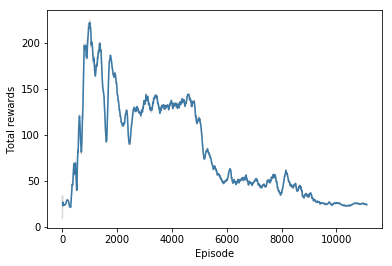

In [36]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

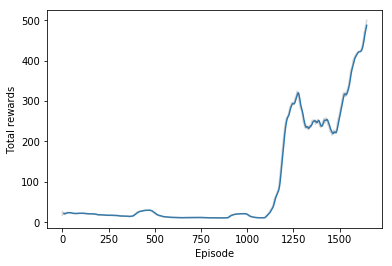

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

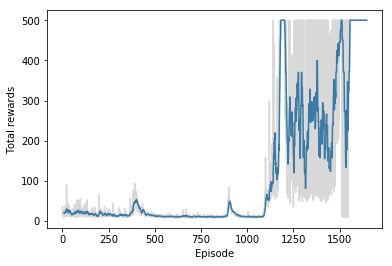

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

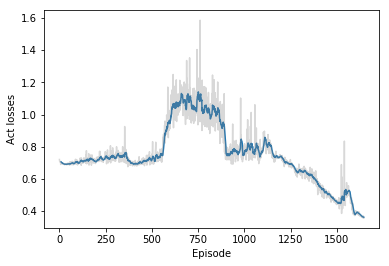

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

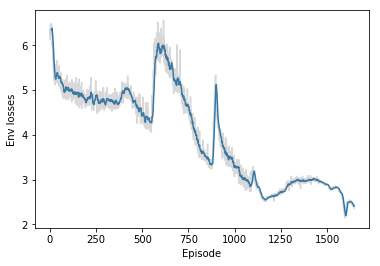

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

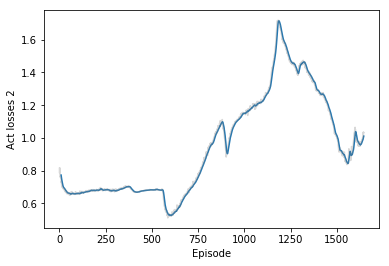

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
